In [1]:
import pandas as pd
import glob
import numpy as np
import matplotlib.pyplot as plt
import math
from mpl_toolkits.mplot3d import Axes3D
from scipy.optimize import least_squares
from scipy.optimize import curve_fit

# 1.读取数据

In [4]:
# 拟合圆的函数
def fit_circle(x, y):
	"""拟合圆并计算曲率半径"""
	def residuals(params):
		x0, y0, R = params
		return np.sqrt((x - x0)**2 + (y - y0)**2) - R

	# 初始猜测值（圆心在路径中心附近，半径取平均距离）
	x0_guess = np.mean(x)
	y0_guess = np.mean(y)
	R_guess = np.mean(np.sqrt((x - x0_guess)**2 + (y - y0_guess)**2))
	
	# 使用最小二乘法拟合圆
	result = least_squares(residuals, [x0_guess, y0_guess, R_guess])
	 # 拟合圆的圆心坐标和半径
	x0, y0, radius = result.x
	
	# 计算每个点的角度（相对于圆心）
	angles = np.arctan2(y - y0, x - x0)
	
	# 计算角度差（弧长）
	angle_diff = np.diff(angles)  # 计算连续点之间的角度差
	arc_length = np.sum(np.abs(angle_diff)) * radius  # 弧长 = 半径 * 角度差之和
	return radius, arc_length  # 返回曲率半径和弧长

# 计算曲率、运动时间和夹角的函数
def calculate_curvature_and_angles(head_points, timestamps, stability_threshold=0.01):
	# 朝向方向
	head_dirs = np.diff(head_points, axis=0)  # 计算连续点之间的差值，代表朝向变化
	head_dirs = np.vstack([head_dirs, head_dirs[-1]])  # 补充最后一个方向，使得与head_points长度一致
	positions = head_points
	
	# 计算每50个连续点的运动曲率半径、时间、夹角
	window_size = 75
	window_interval = 5
	num_windows = (len(head_points)-window_size-1) // window_interval
	curvatures = []
	omegas = []
	angles = []
	velocity_fowards = []
	for i in range(num_windows):
		start_idx = i * window_interval
		end_idx = i * window_interval + window_size

		# 获取当前窗口的位置数据
		x = positions[start_idx:end_idx, 0]
		y = positions[start_idx:end_idx, 1]
		
		# 拟合曲率半径和弧长
		radius, arc_length = fit_circle(x, y)
		curvatures.append(radius)

		# 计算角速度（omega），即弧长除以半径和时间差
		omega = arc_length / radius / (timestamps[end_idx-1] - timestamps[start_idx])
		omegas.append(omega)
	
		# 计算夹角：朝向方向和切线方向的夹角
		# 计算路径切向方向：相邻两点之间的方向
		tangent_dirs = positions[start_idx + 1:end_idx + 1] - positions[start_idx:end_idx]  # 相邻点的差值
		tangent_angles = np.arctan2(tangent_dirs[:, 1], tangent_dirs[:, 0])  # 计算切线方向的角度
		
		# 计算朝向方向的角度
		head_angles = np.arctan2(head_dirs[start_idx:end_idx, 1], head_dirs[start_idx:end_idx, 0])  # 头部方向角度
		
		# 计算夹角：朝向方向和路径切线的夹角
		angle_differences = np.abs(tangent_angles - head_angles)  # 计算角度差
		angle_differences = np.minimum(angle_differences, 2 * np.pi - angle_differences)  # 夹角是小于180度的

		# 计算平均夹角
		angles.append(np.mean(angle_differences))
		velocity_fowards.append(omega * radius * np.cos(np.mean(angle_differences)))
	# 查找稳定阶段：通过检查曲率、角速度和夹角的变化来判断稳定阶段
	stable_velocity_fowards = []
	stable_curvatures = []
	stable_omegas = []
	stable_angles = []
	
	# 计算稳定阶段（即变化幅度小于某个阈值的段）
	for i in range(1, len(curvatures)):
		if abs(velocity_fowards[i] - velocity_fowards[i-1]) < stability_threshold :
			stable_velocity_fowards.append(velocity_fowards[i])
			stable_curvatures.append(curvatures[i])
			stable_omegas.append(omegas[i])
			stable_angles.append(angles[i])

	# 提取稳定阶段的平均值
	avg_stable_velocity_fowards = get_stable_value(np.array(stable_velocity_fowards), threshold=0.01, method="mean") if get_stable_value(np.array(stable_velocity_fowards), threshold=0.01, method="mean") else None
	avg_stable_curvatures = np.mean(stable_curvatures) if stable_curvatures else None
	avg_stable_omegas = np.mean(stable_omegas) if stable_omegas else None
	avg_stable_angles = np.mean(stable_angles) if stable_angles else None
	
	return avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards

def get_stable_value(data, threshold=0.01, method="mean"):
	"""
	提取数组的最终稳定值
	
	参数：
	data (numpy.ndarray): 输入的数据数组
	threshold (float): 变化阈值，用于判断数据是否稳定，默认0.01
	method (str): 提取稳定值的方法，"mean"为计算均值，"last"为取最后一个值，默认"mean"
	
	返回：
	stable_value (float): 最终稳定值
	"""
	# 计算数据的差分
	diff_data = np.abs(np.diff(data))  # 计算相邻元素的差值（绝对值）

	# 找出变化小于阈值的位置，表示系统已稳定
	stable_indices = np.where(diff_data < threshold)[0]  # 获取变化小于阈值的位置索引

	# 如果找到了稳定阶段
	if len(stable_indices) > 0:
		last_stable_index = stable_indices[-1]  # 最后一个稳定点的索引
		stable_segment = data[last_stable_index:]  # 提取稳定阶段的所有数据
		
		if method == "mean":
			stable_value = np.mean(stable_segment)  # 计算稳定阶段的平均值
		elif method == "last":
			stable_value = stable_segment[-1]  # 取稳定阶段的最后一个值
		else:
			raise ValueError("Invalid method! Use 'mean' or 'last'.")
	else:
		# 如果没有找到明显的稳定阶段，直接返回最后一个值
		stable_value = data[-1]
	
	return stable_value

['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


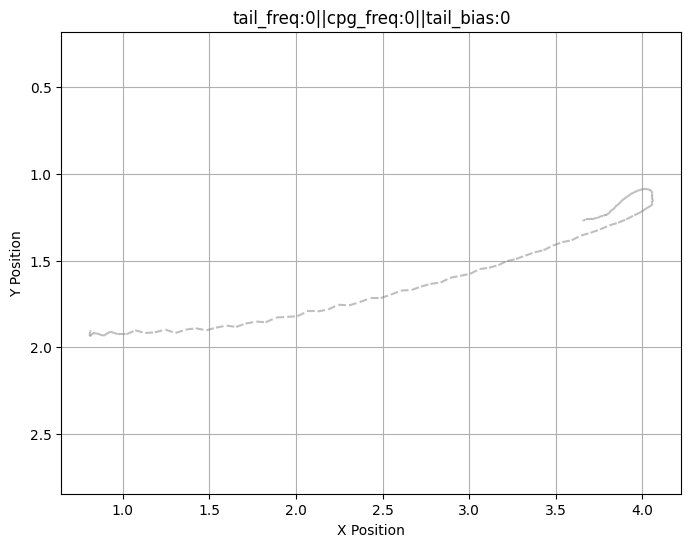

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


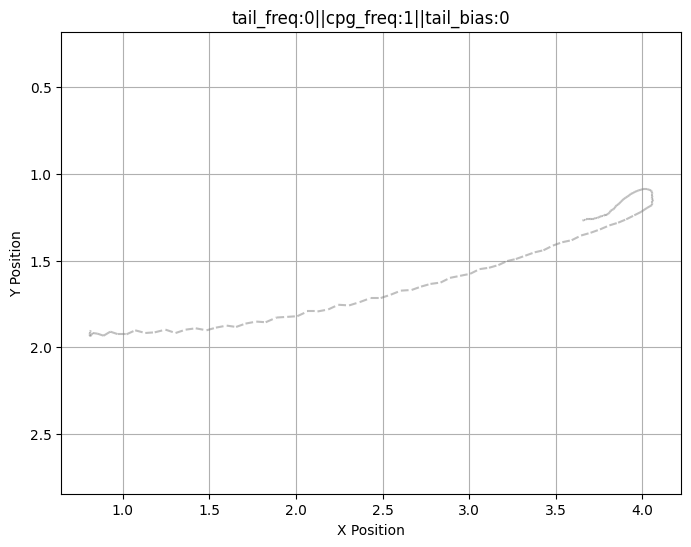

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


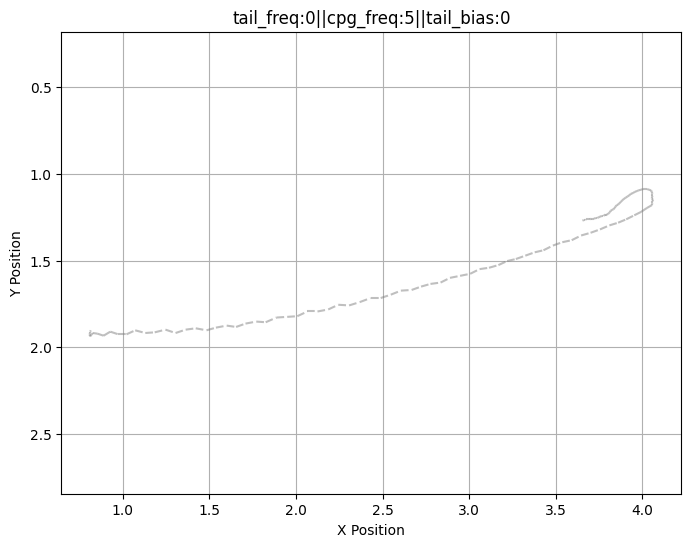

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


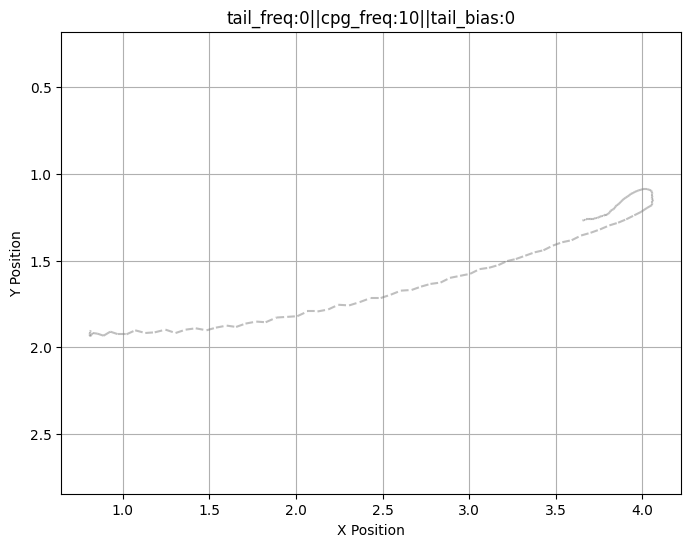

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


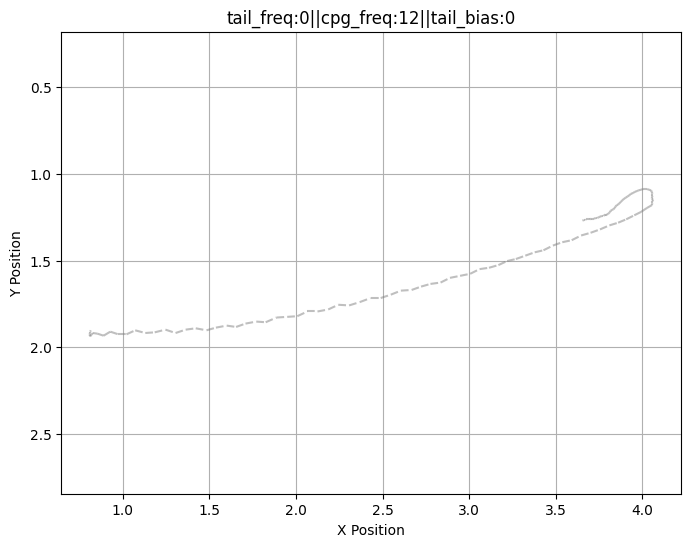

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


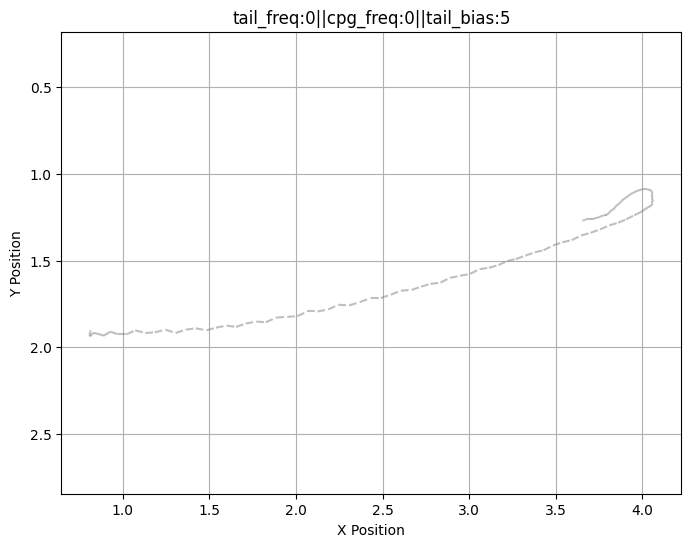

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


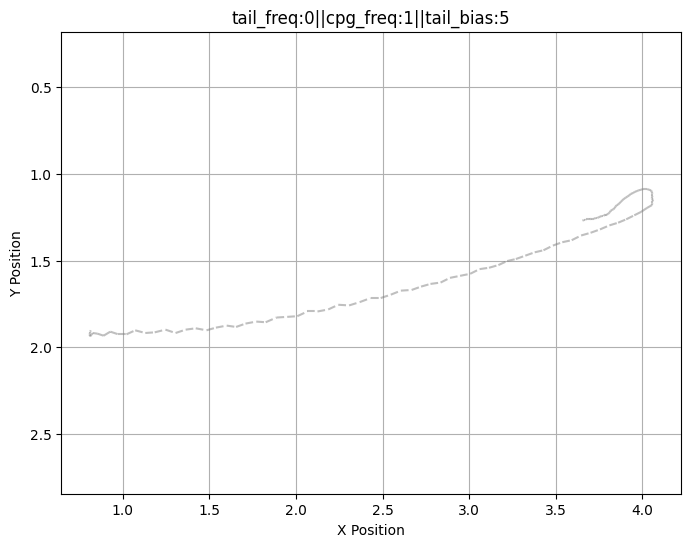

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


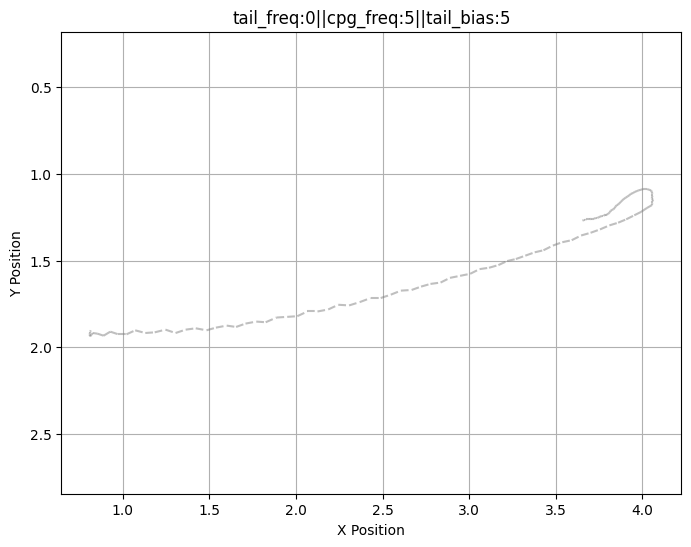

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


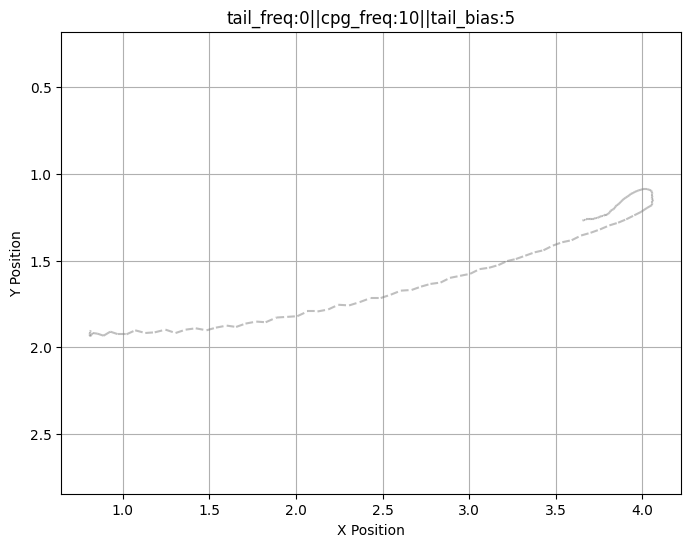

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


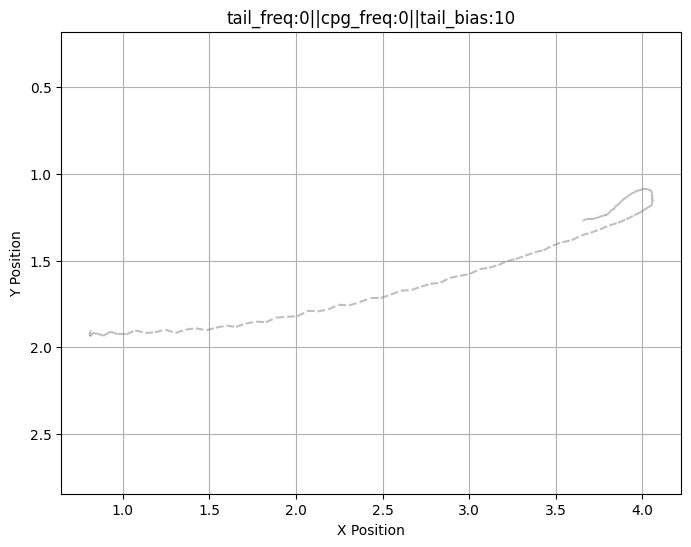

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


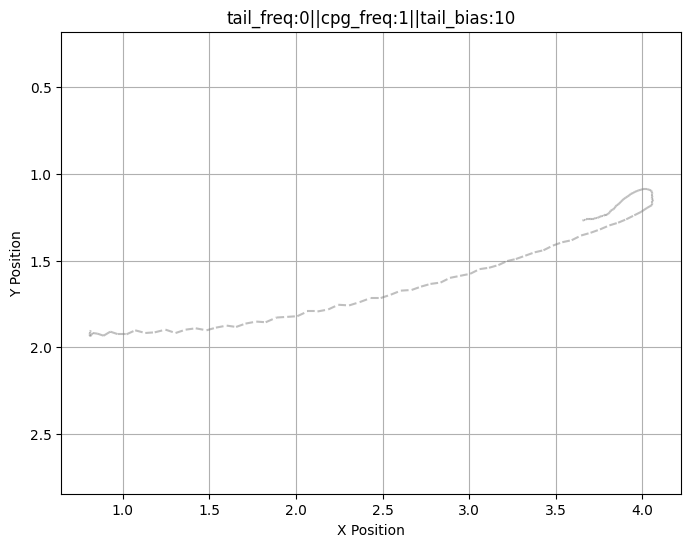

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


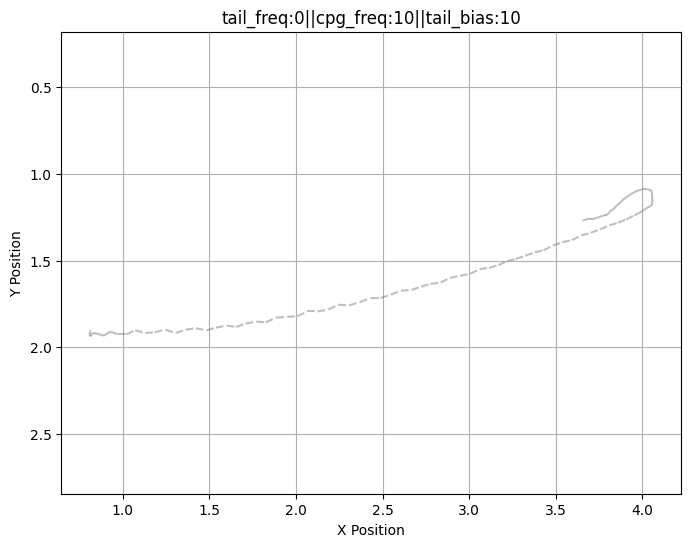

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


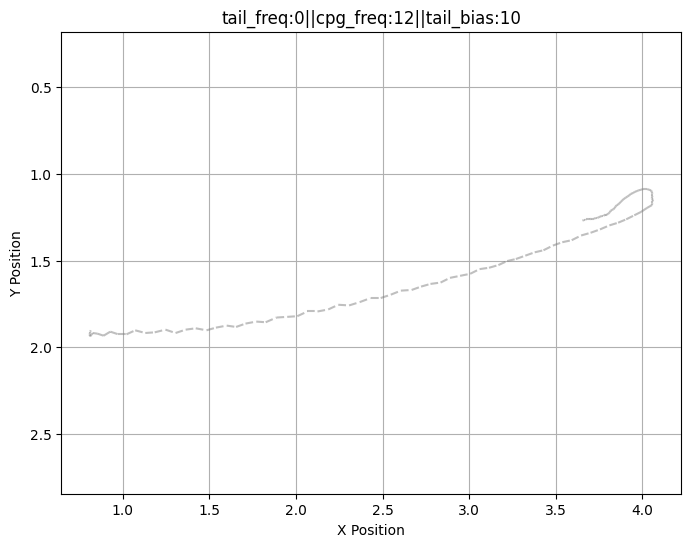

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


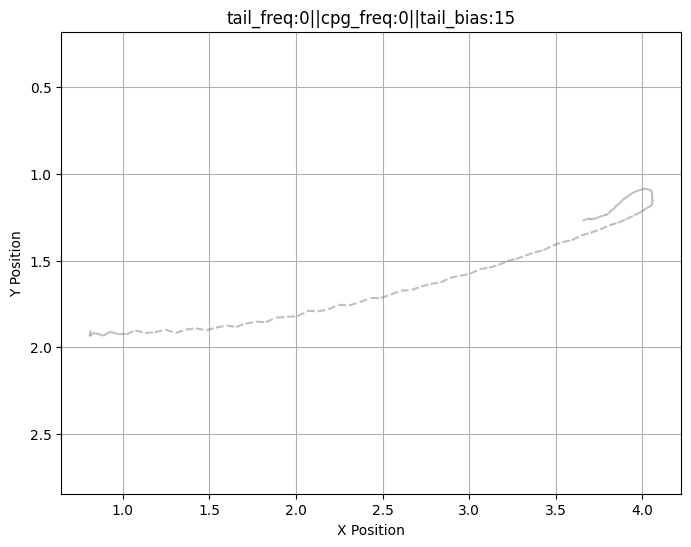

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


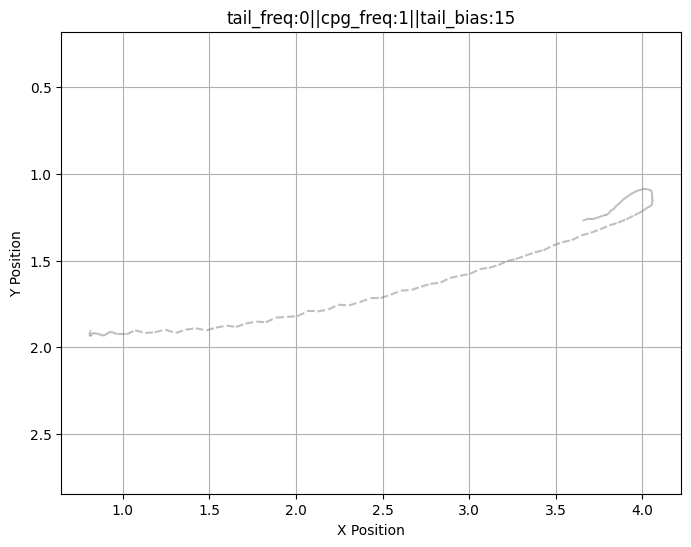

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


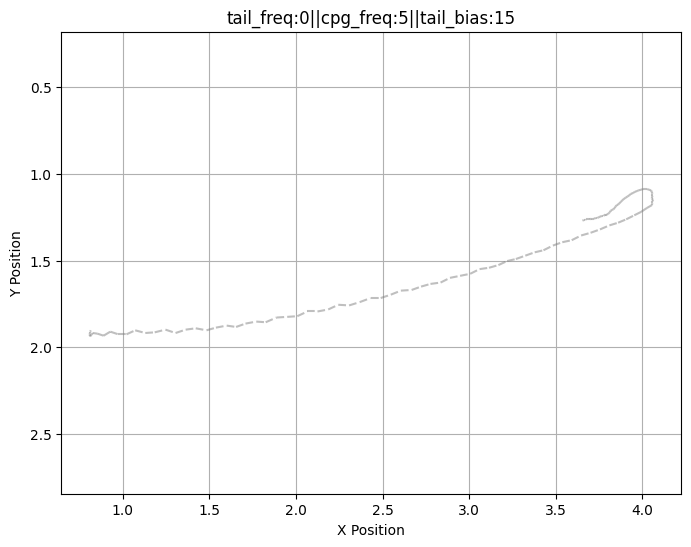

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


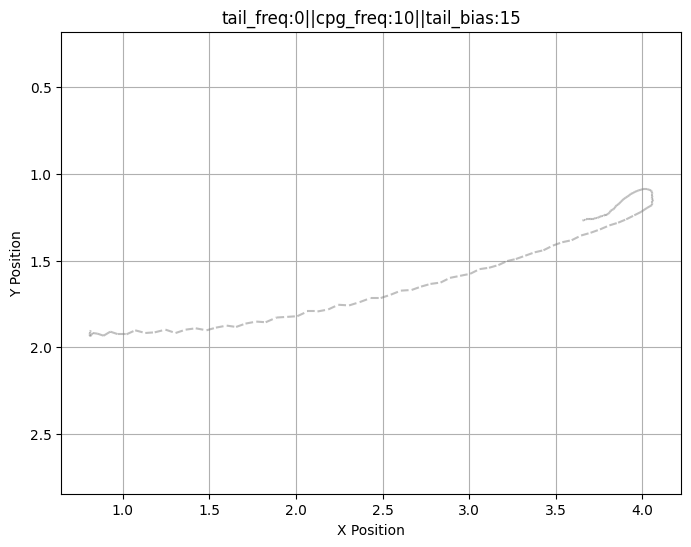

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


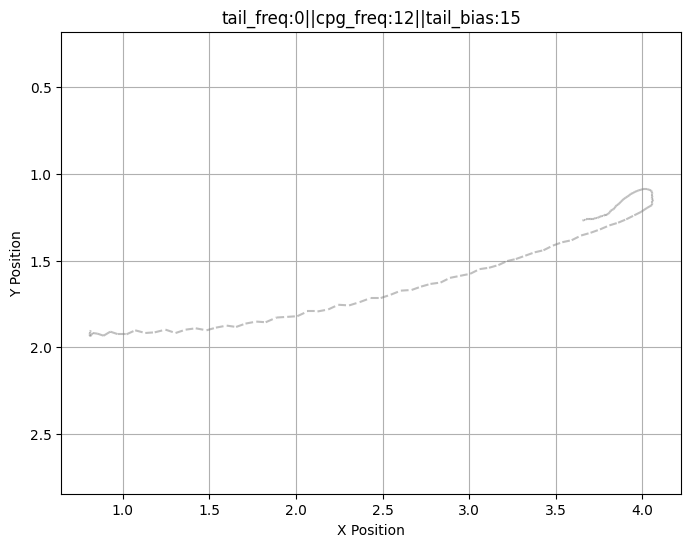

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


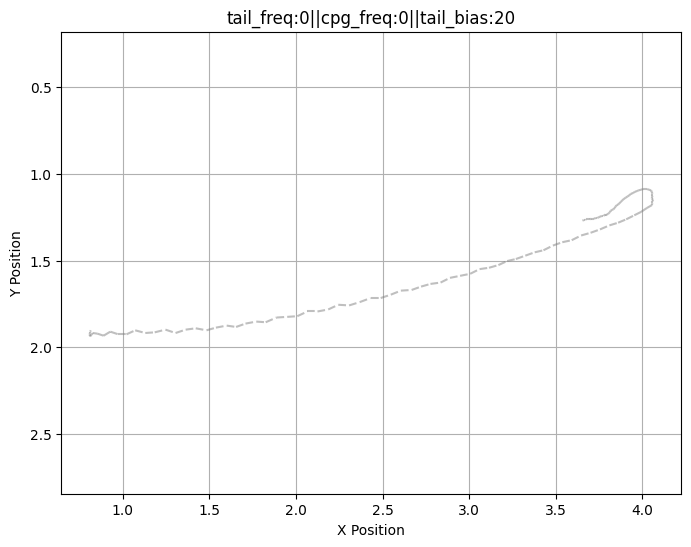

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


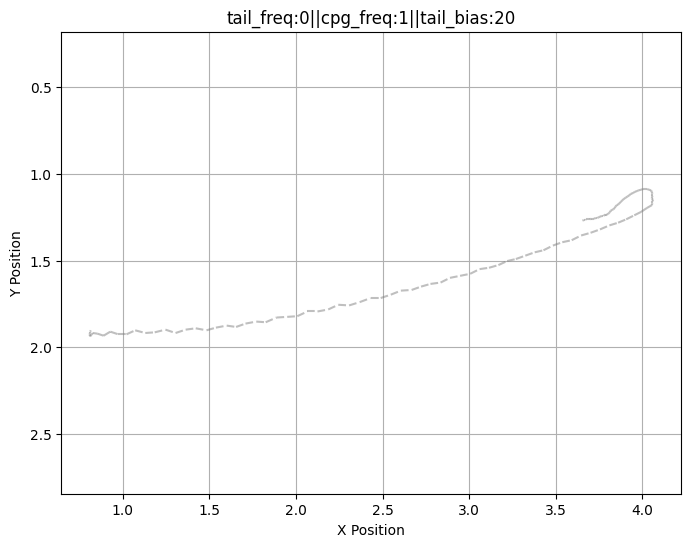

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


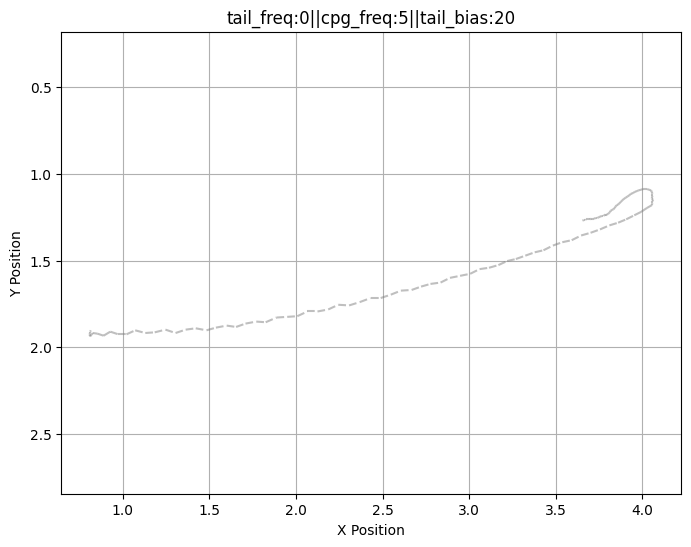

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


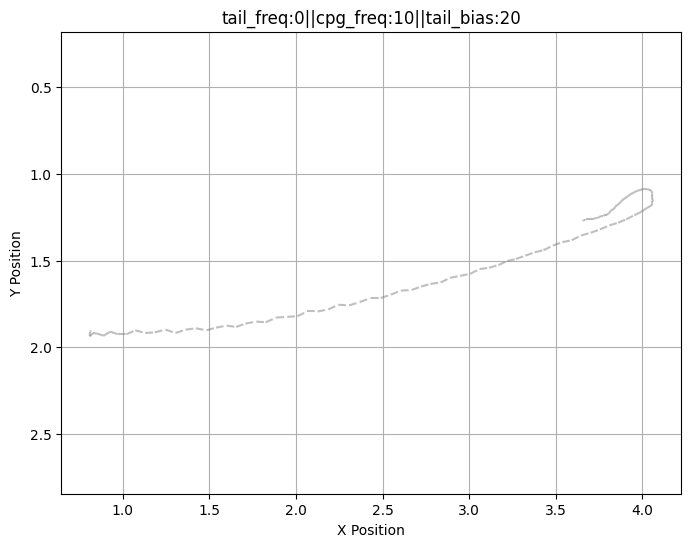

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


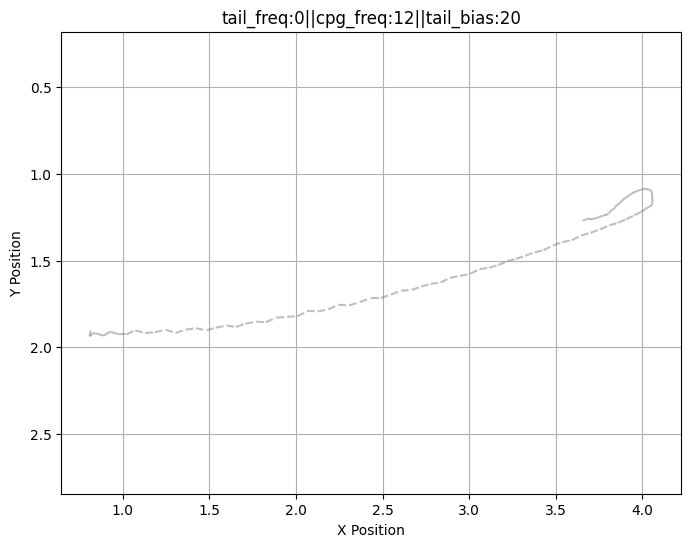

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


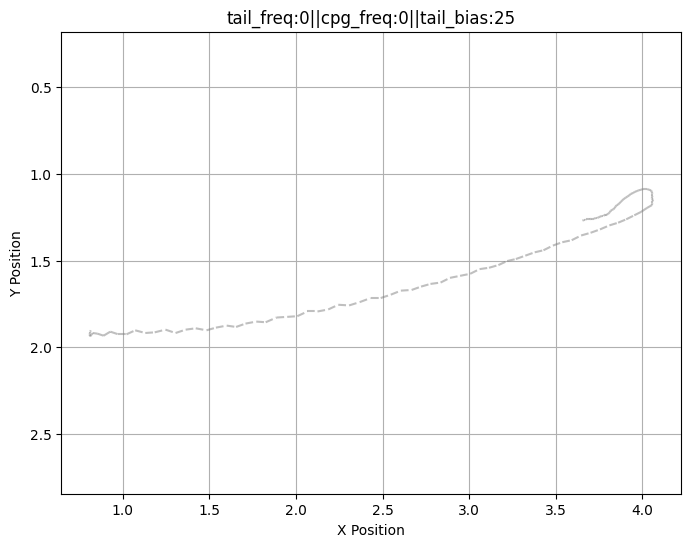

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


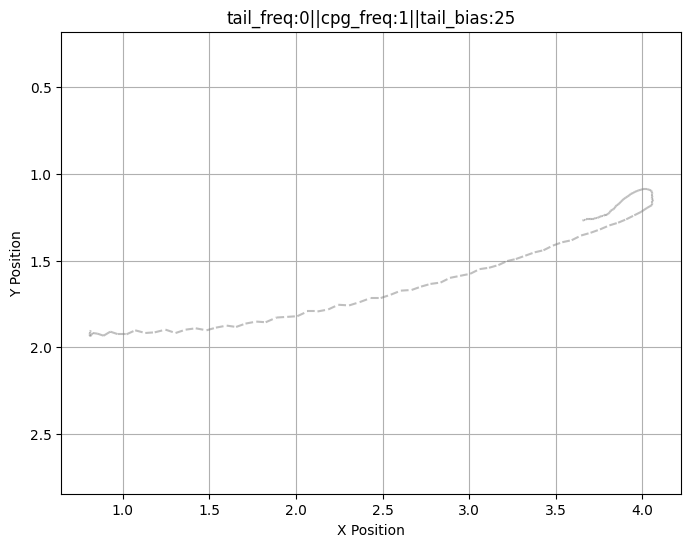

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


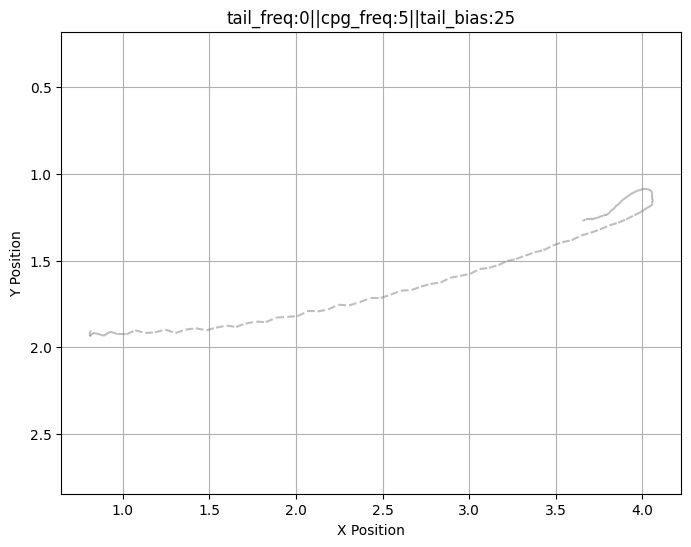

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


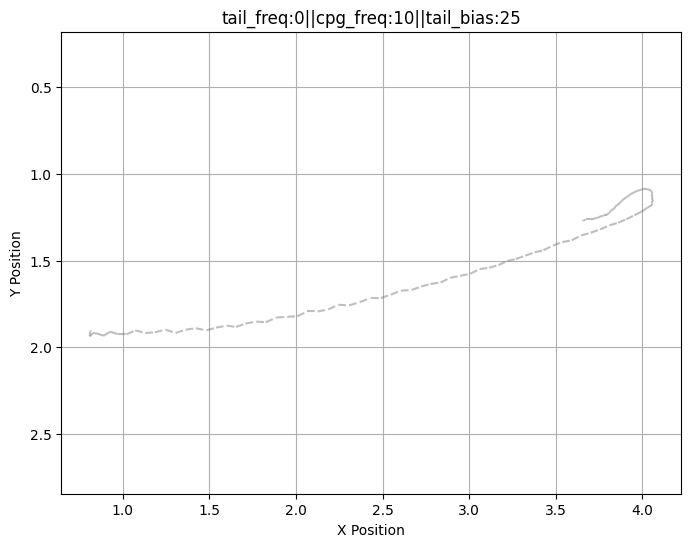

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


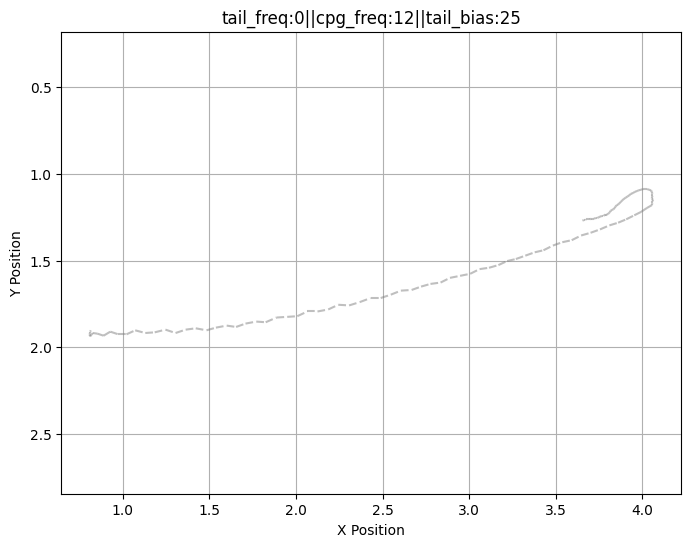

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


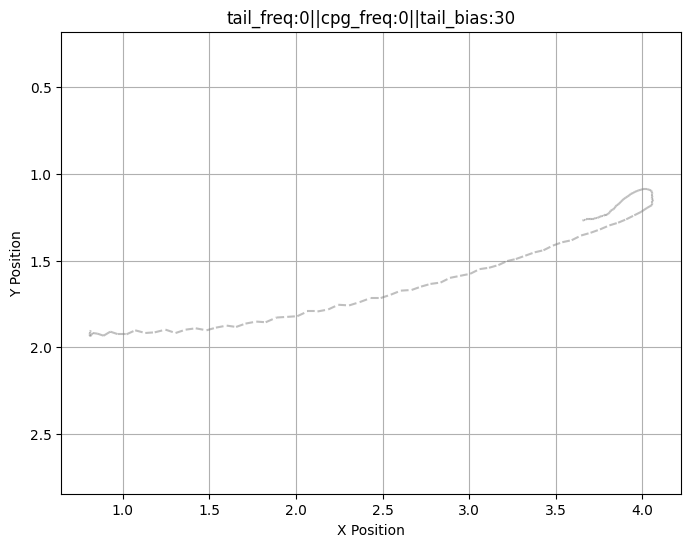

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


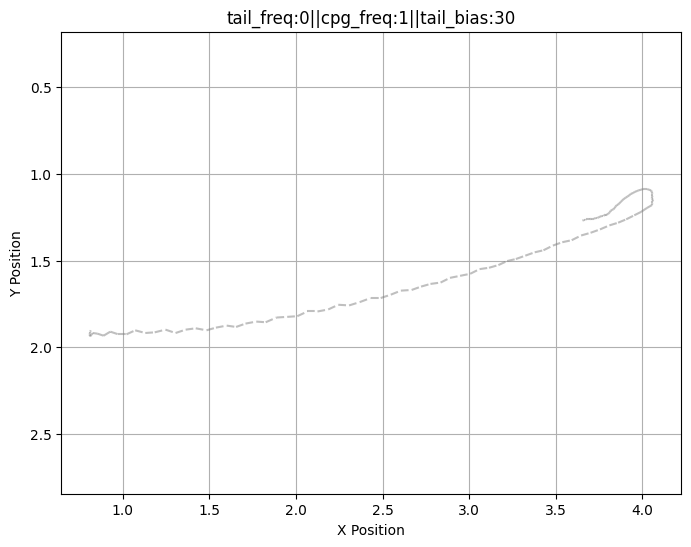

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


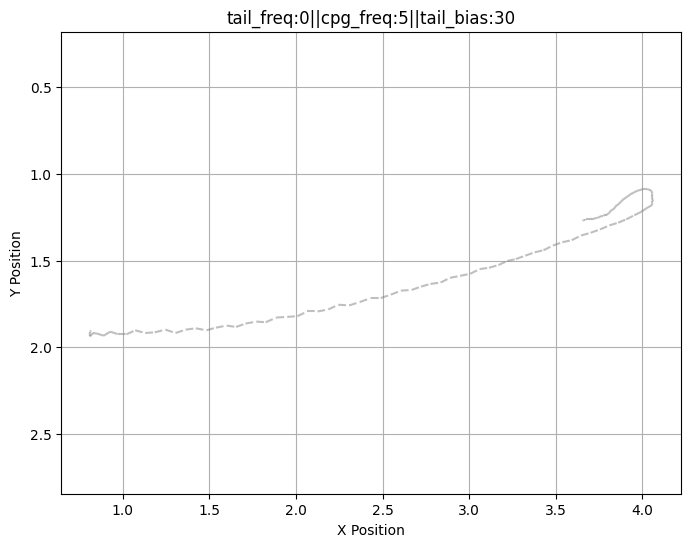

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


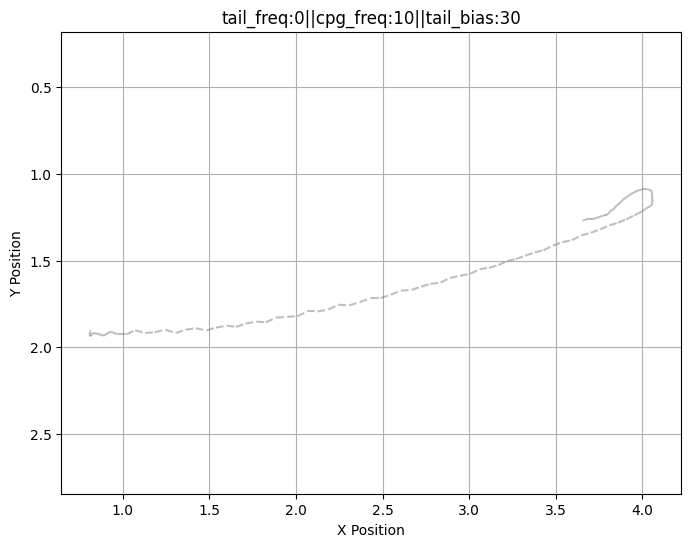

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


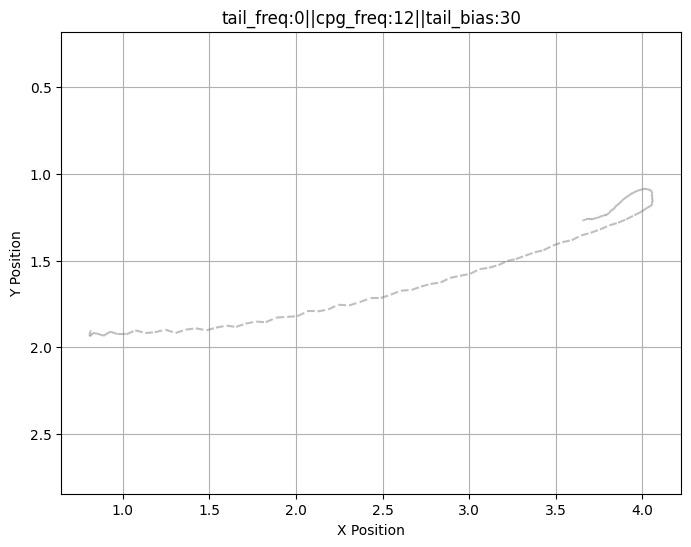

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


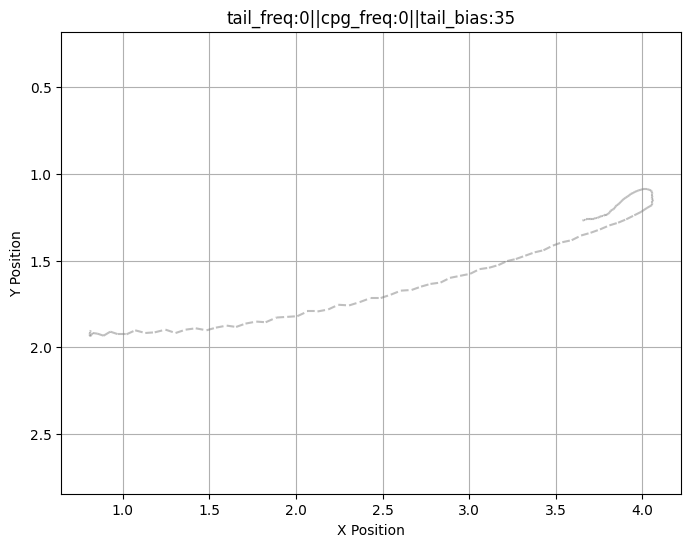

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


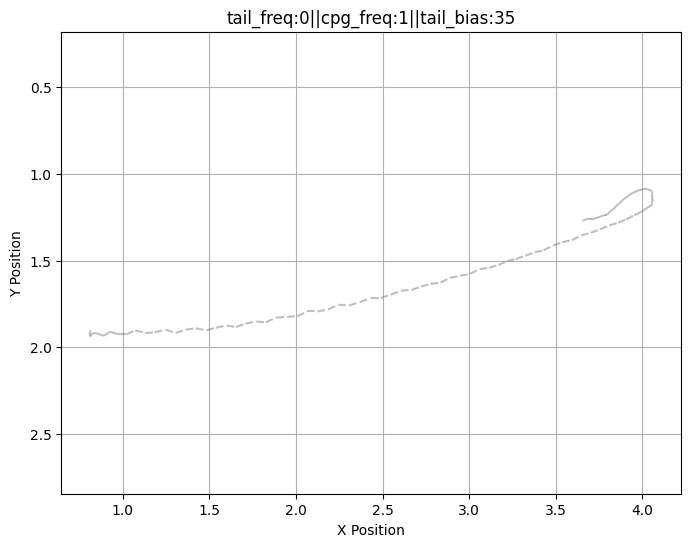

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


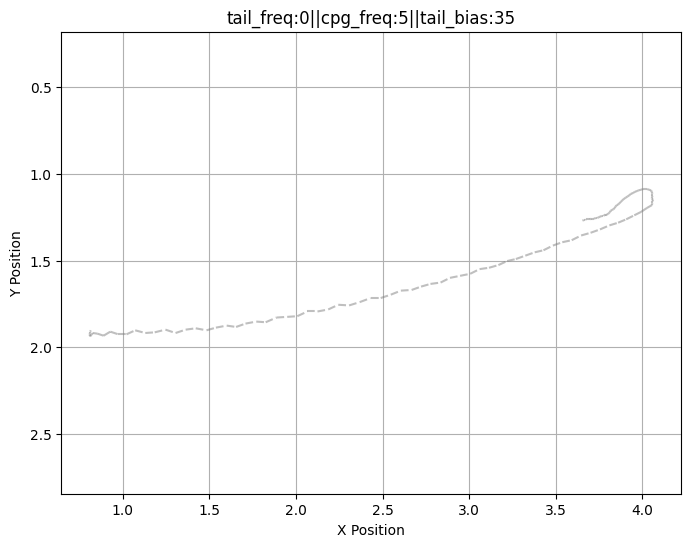

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


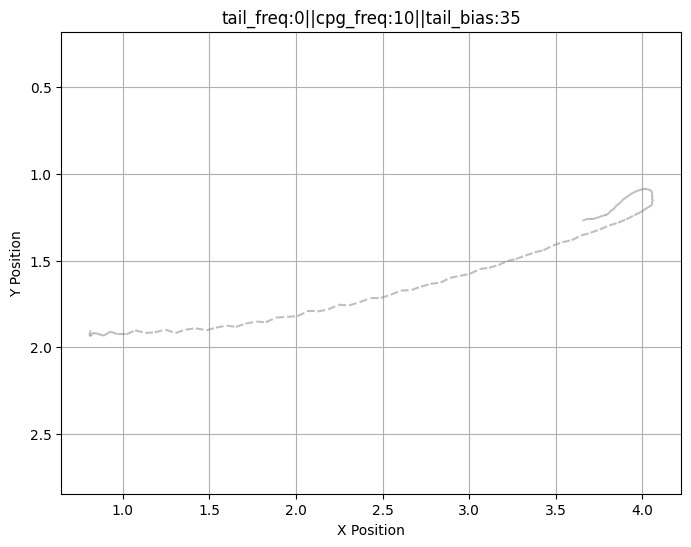

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


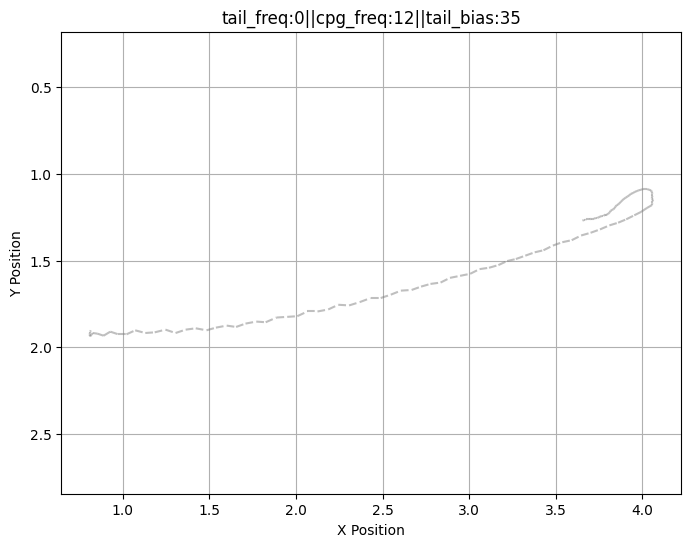

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


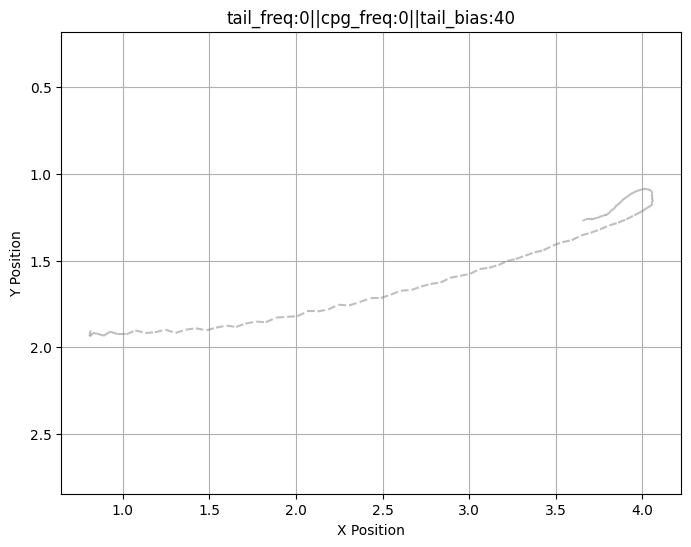

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


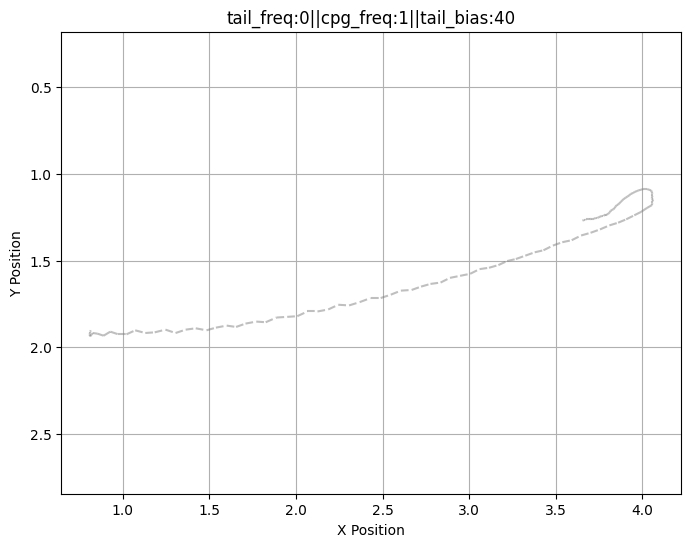

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


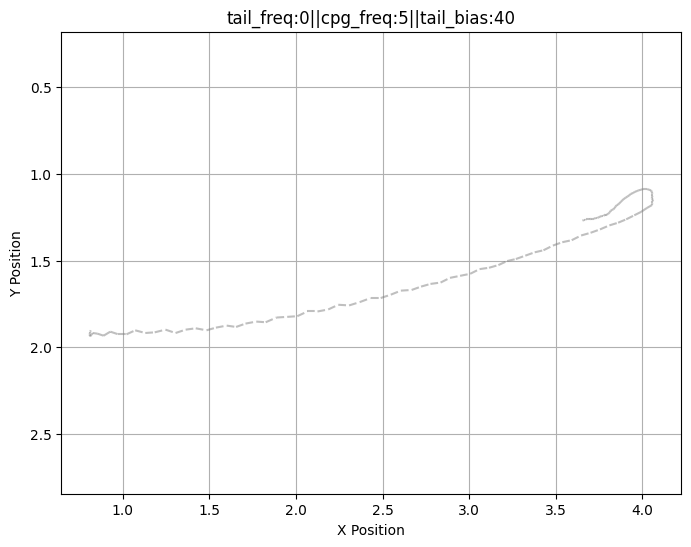

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


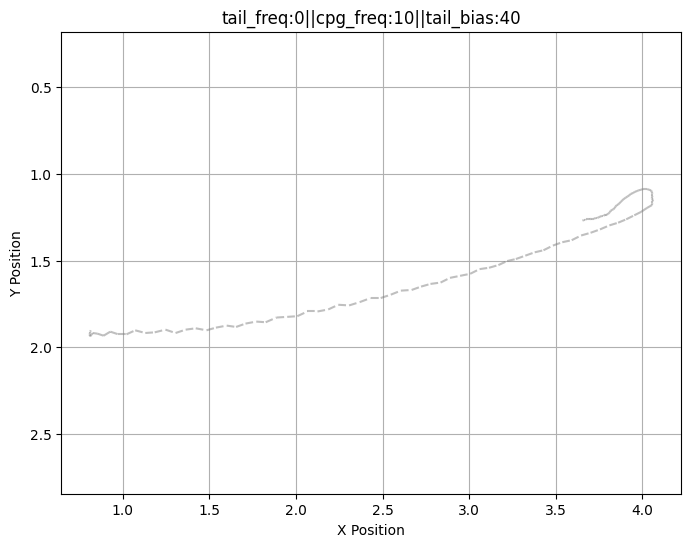

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


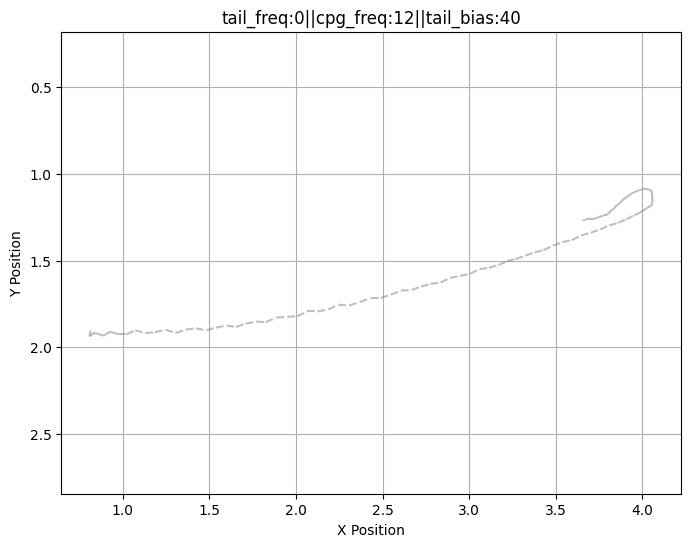

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


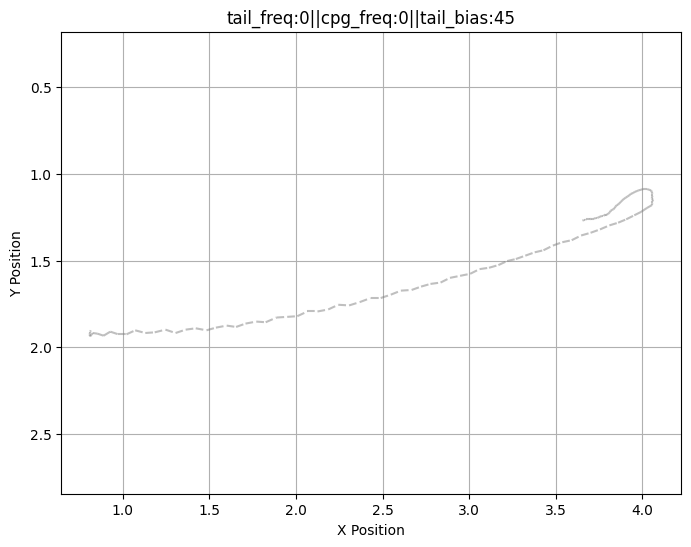

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


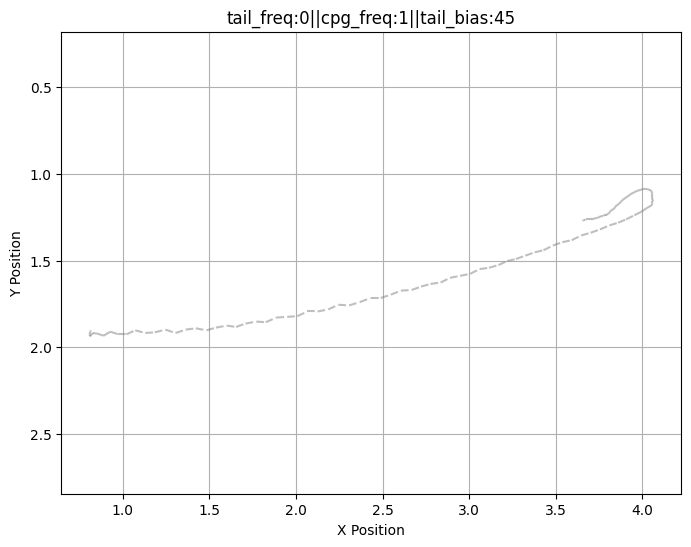

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


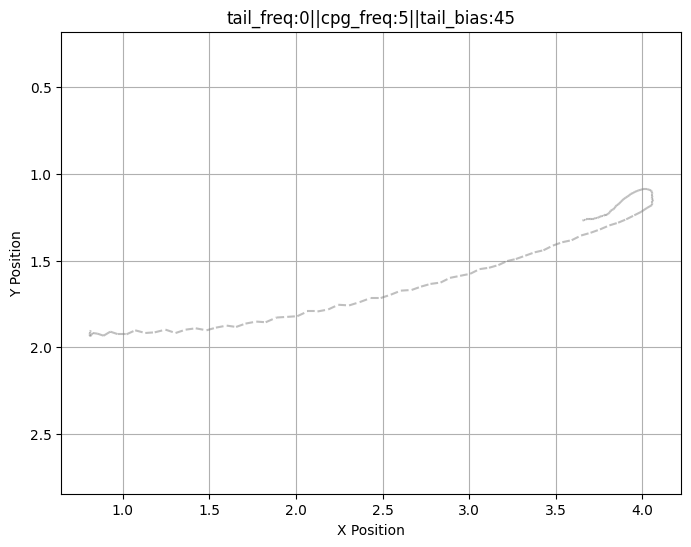

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


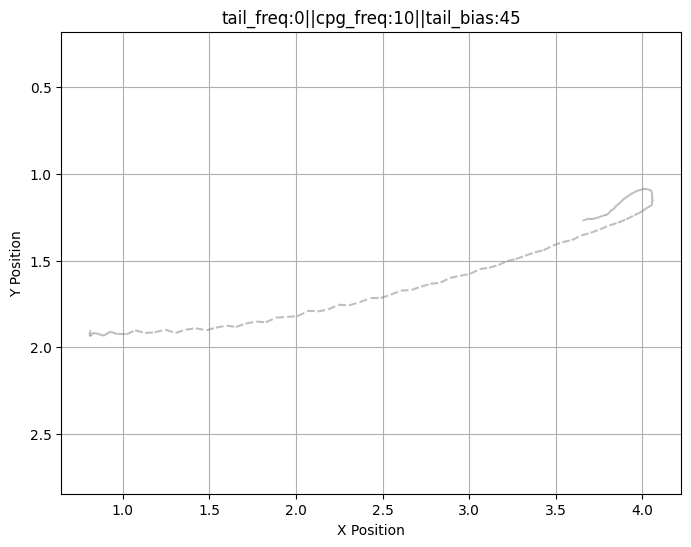

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


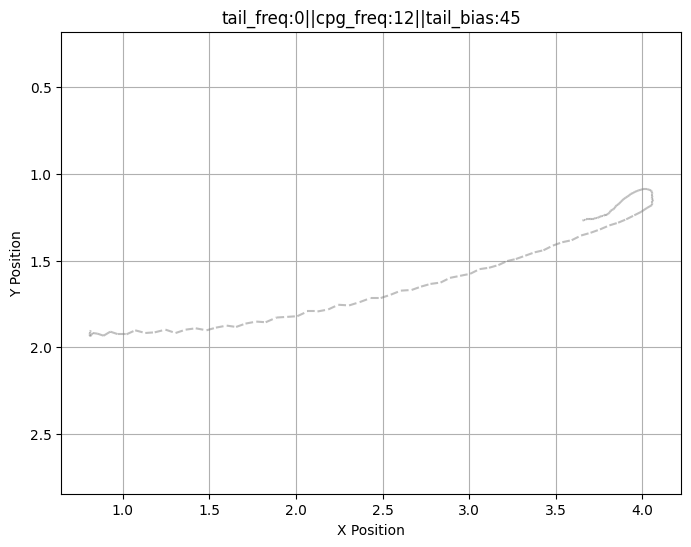

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


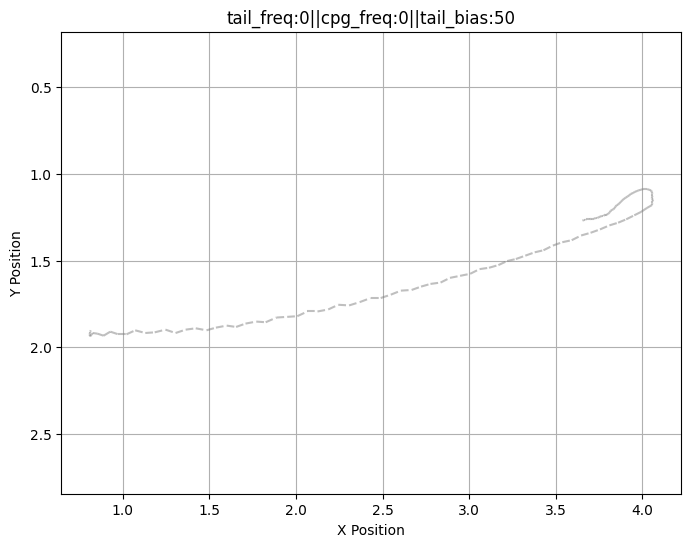

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


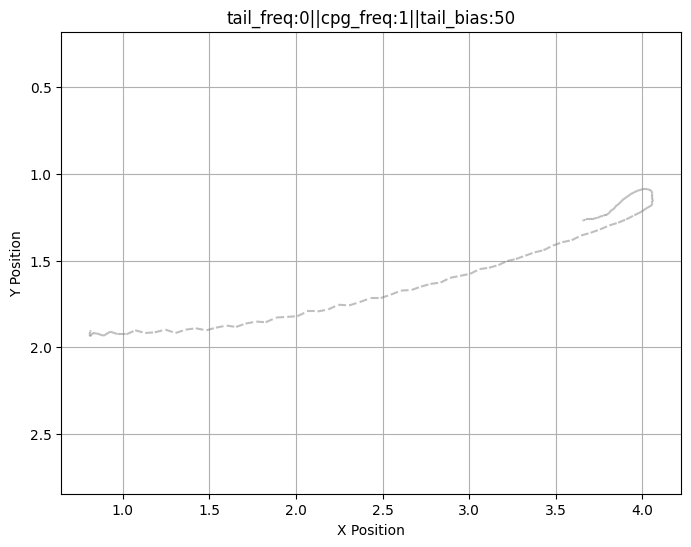

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


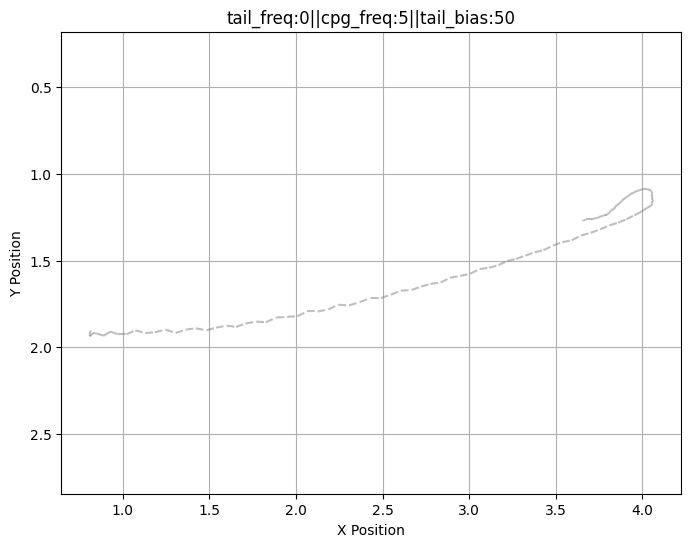

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


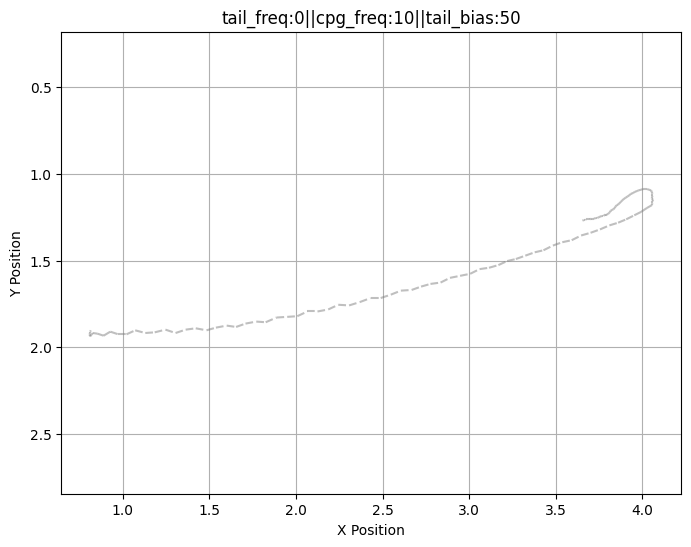

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


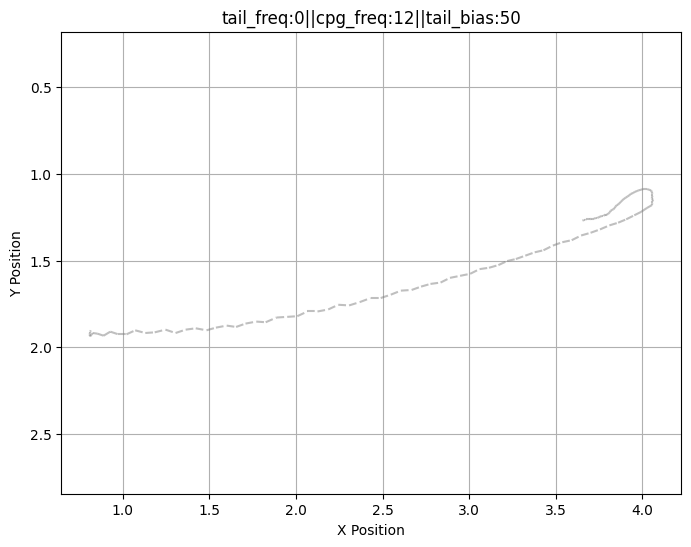

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


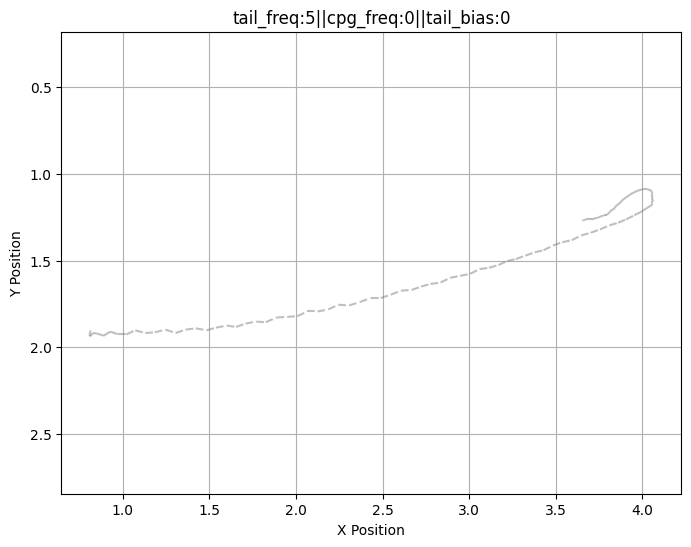

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


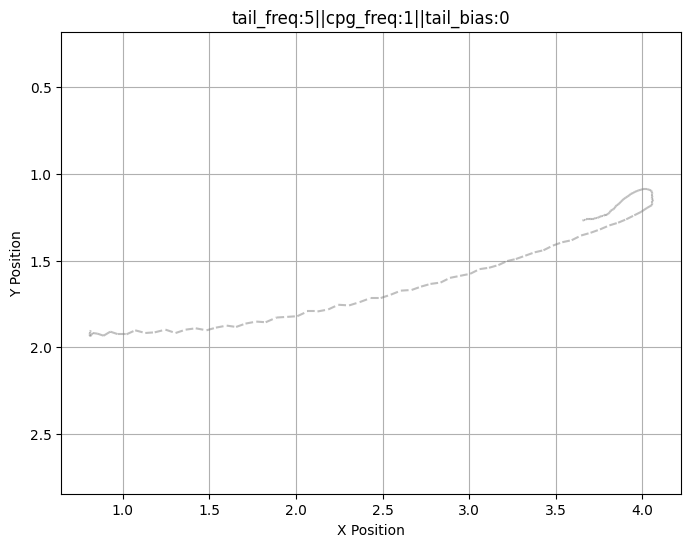

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


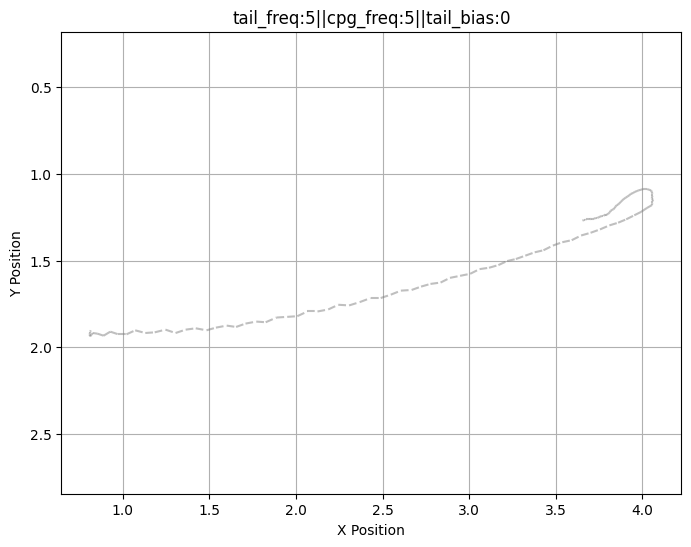

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


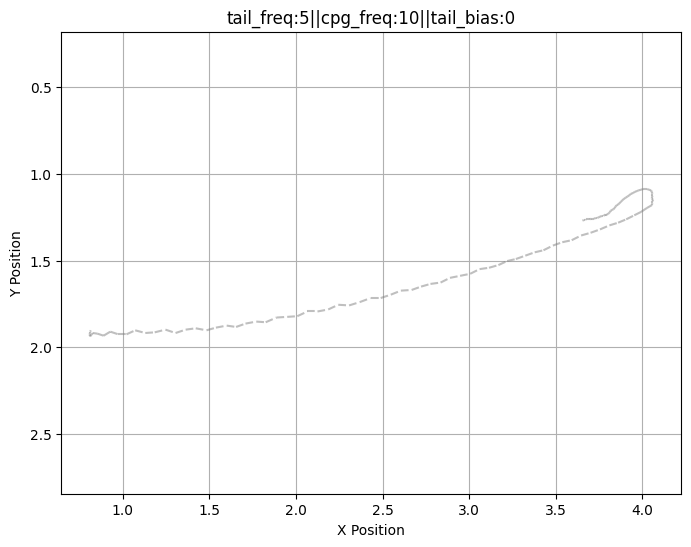

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


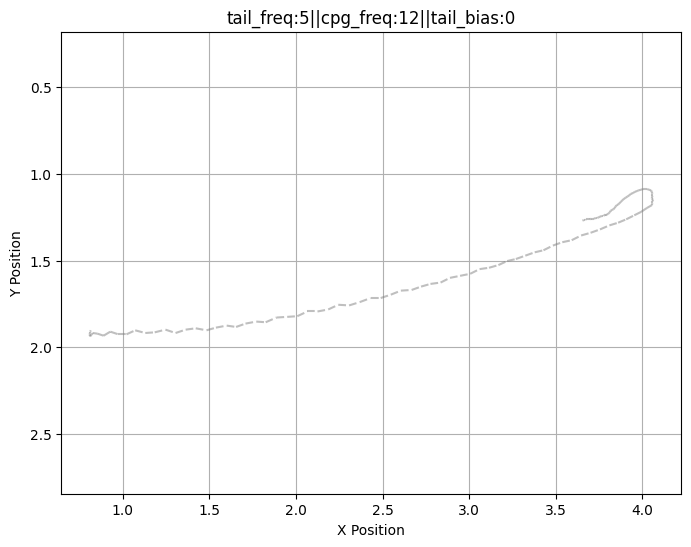

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


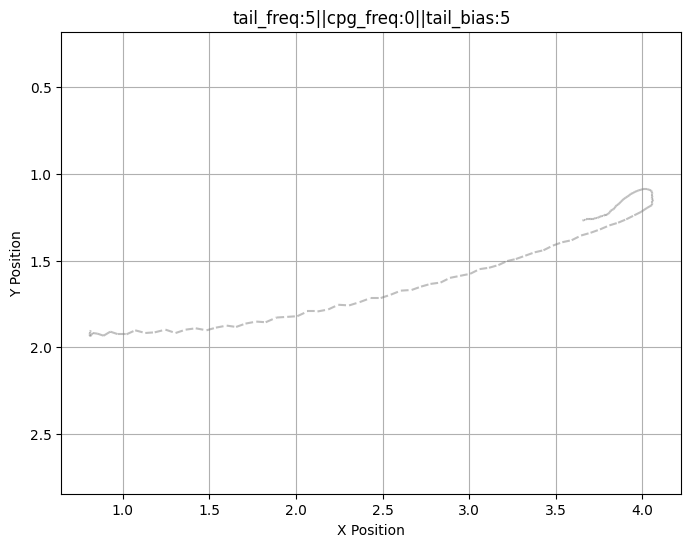

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


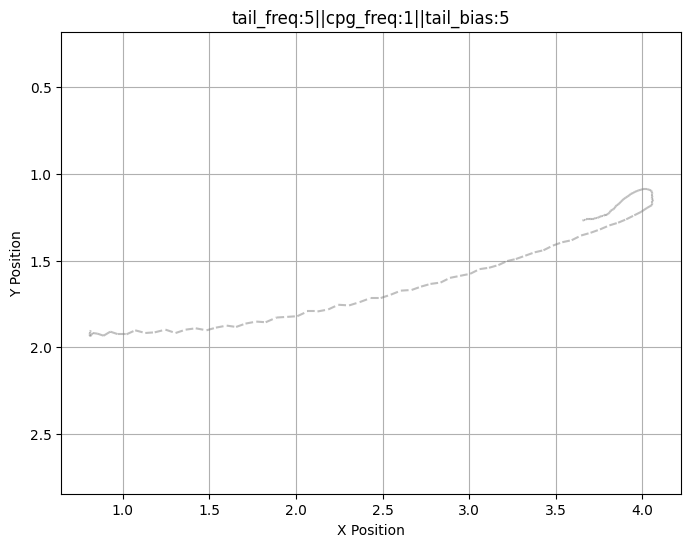

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


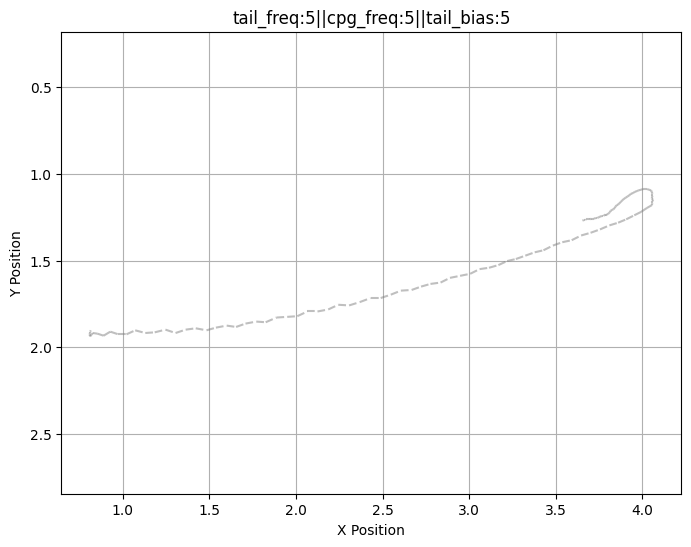

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


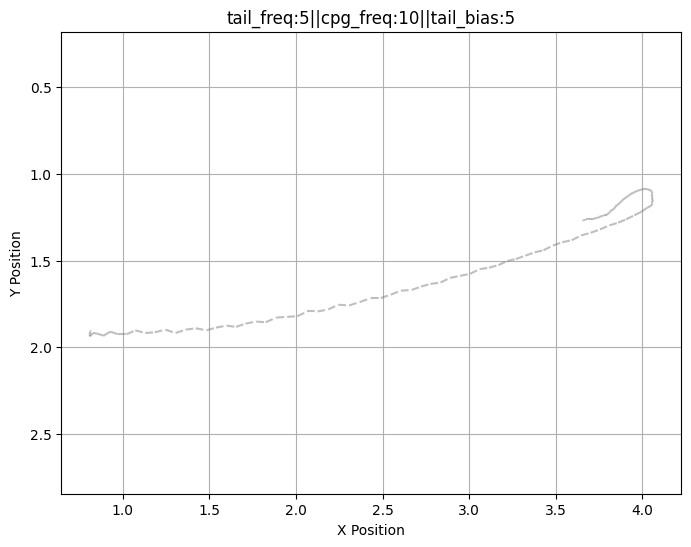

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


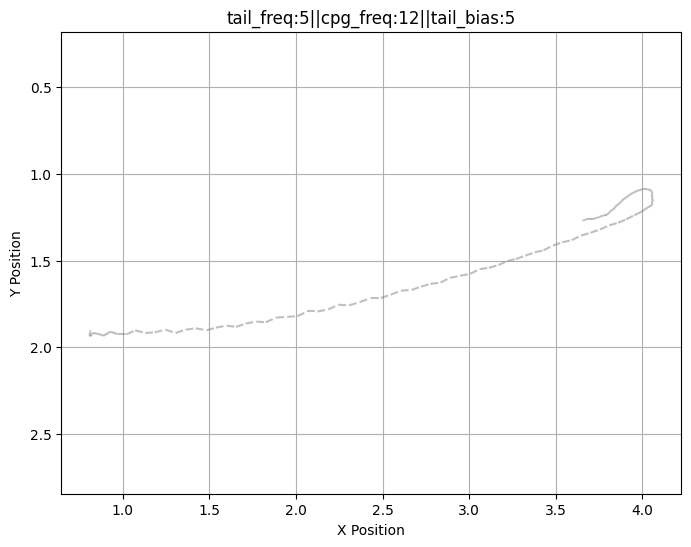

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


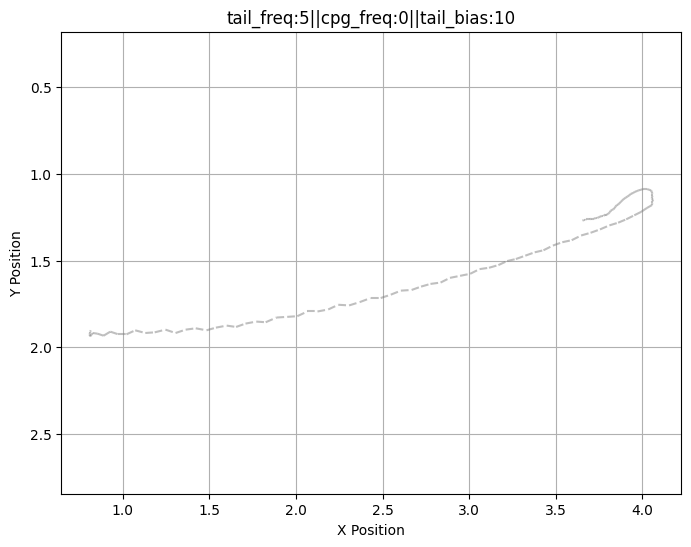

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


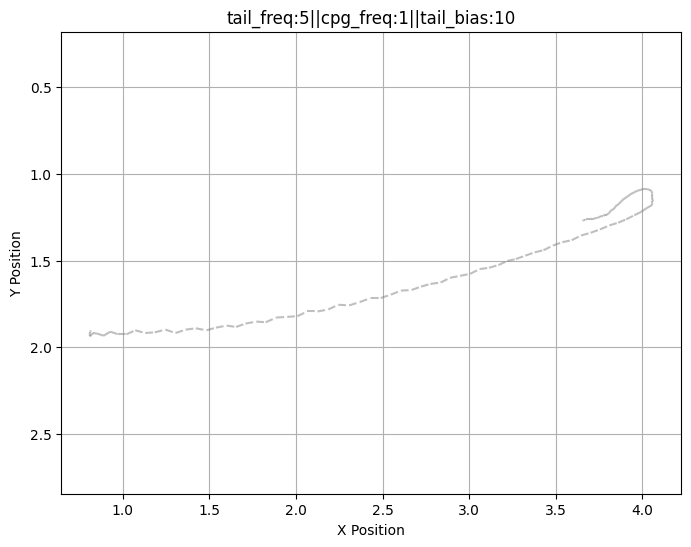

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


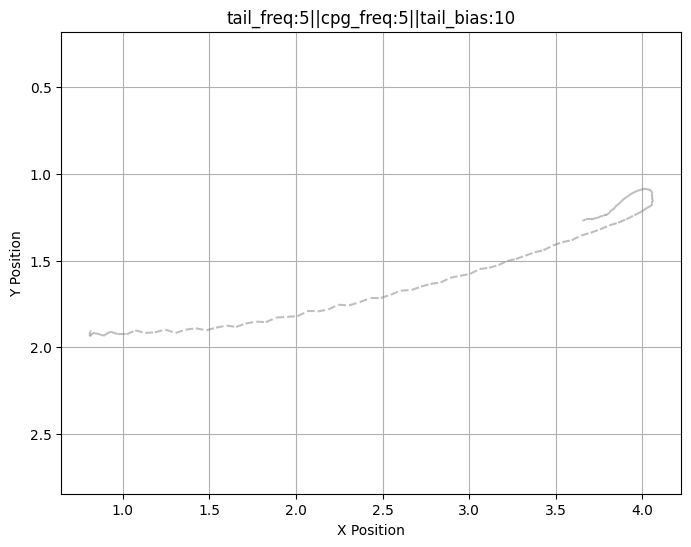

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


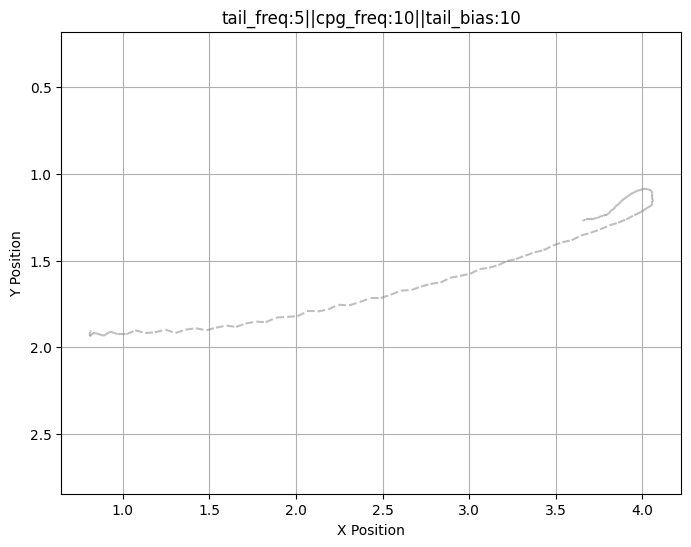

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


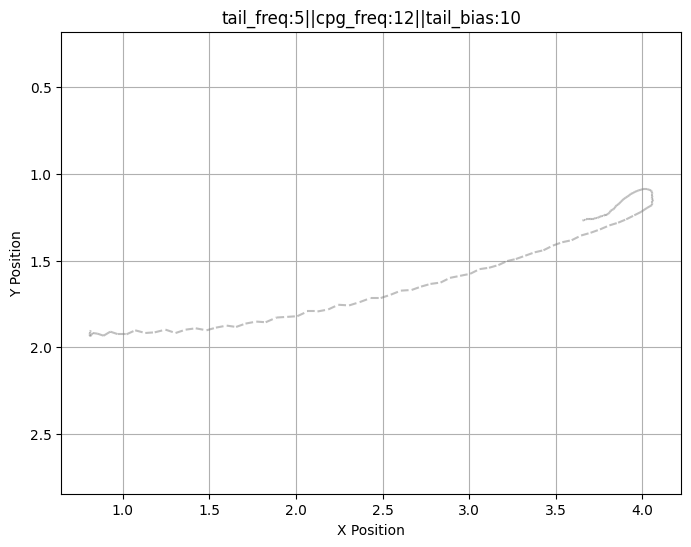

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


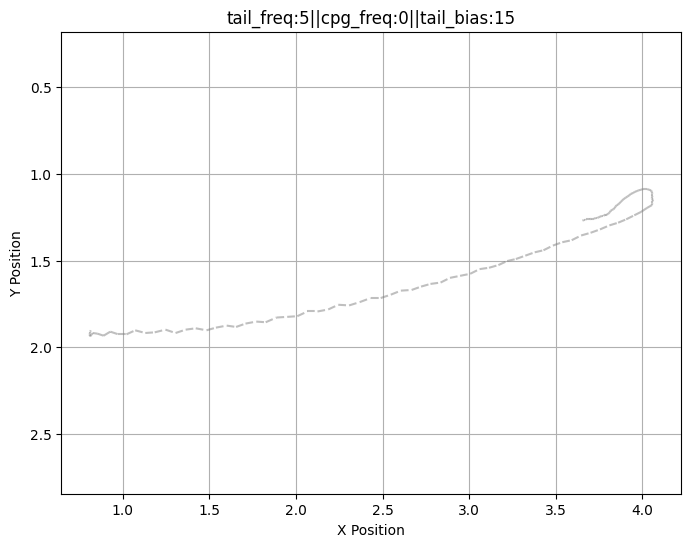

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


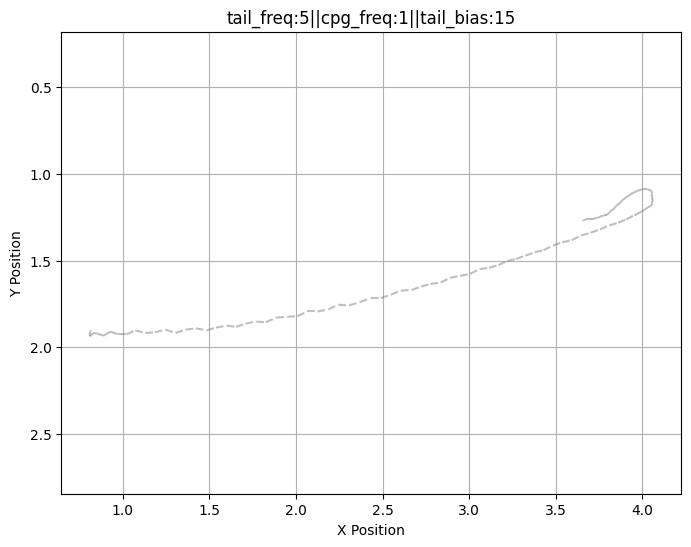

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


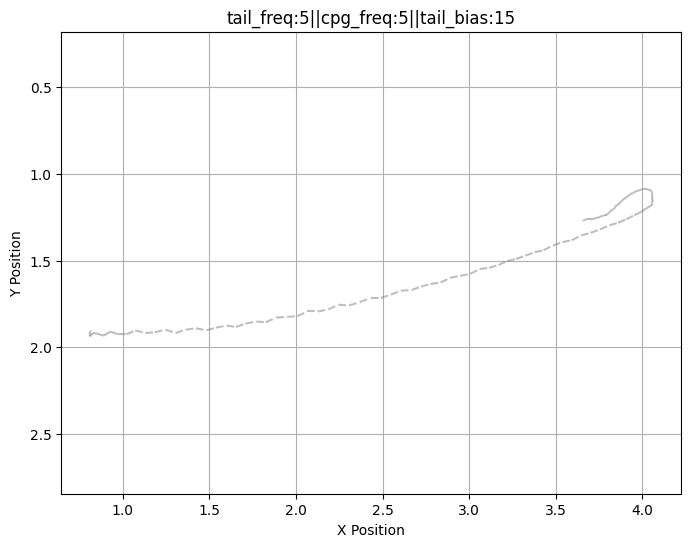

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


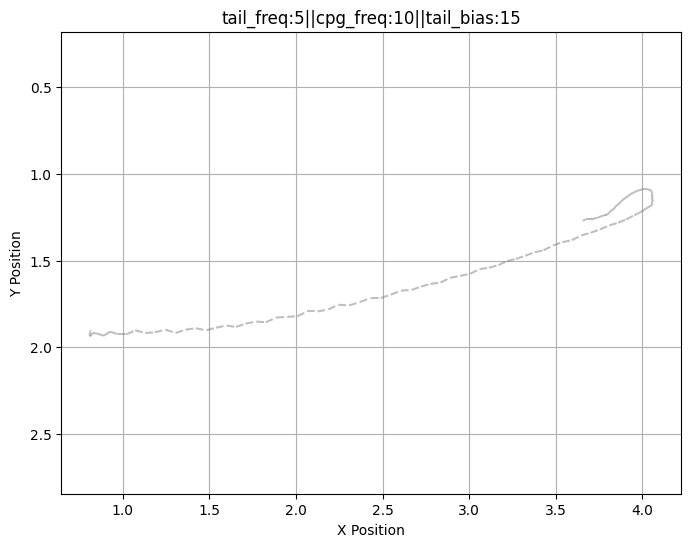

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


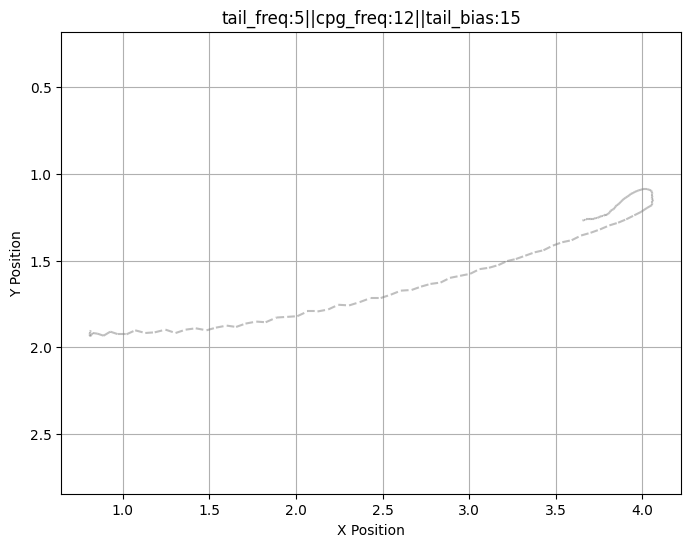

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


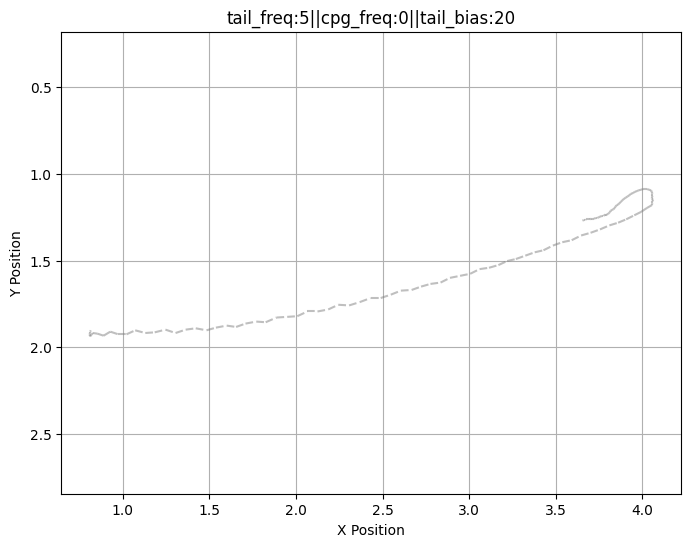

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


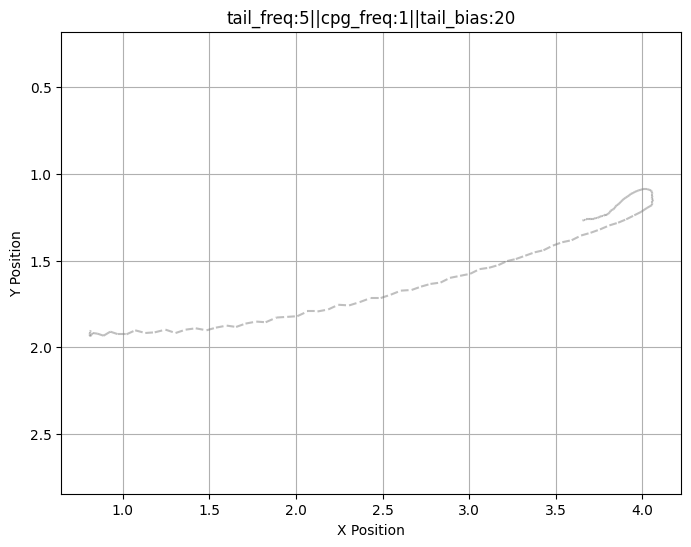

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


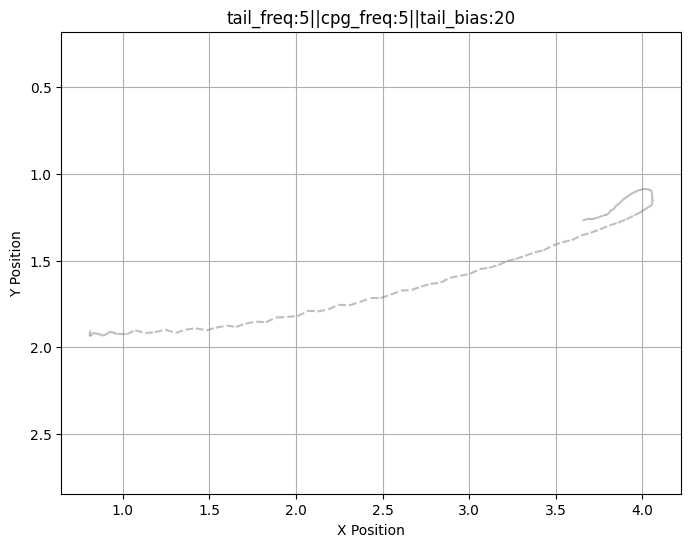

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


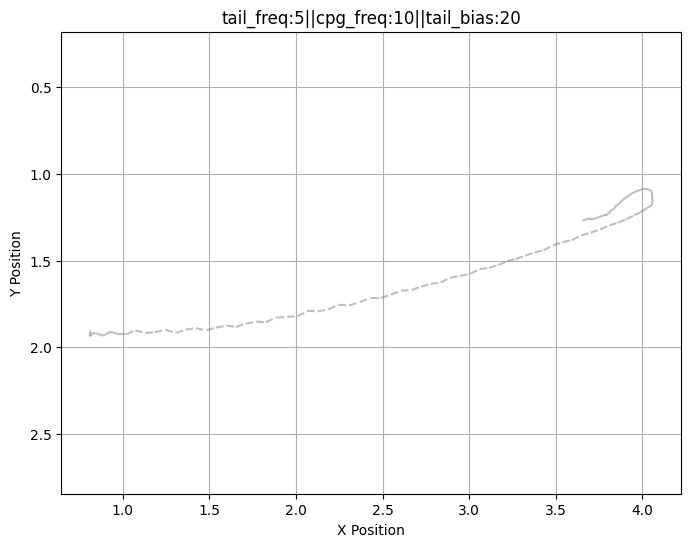

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


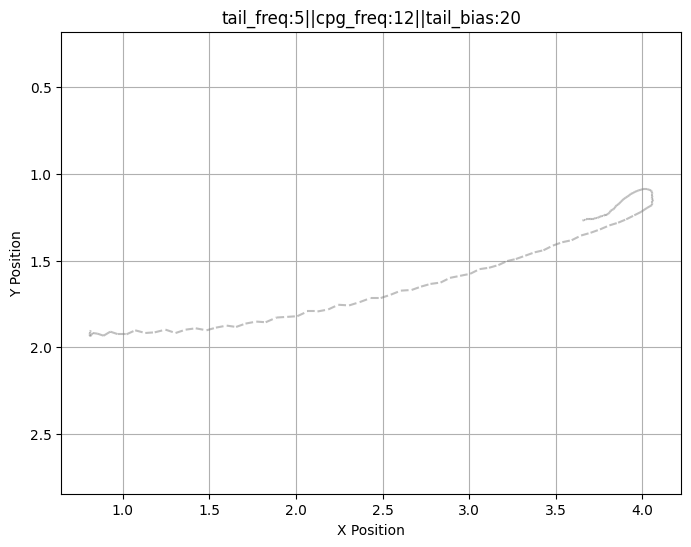

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


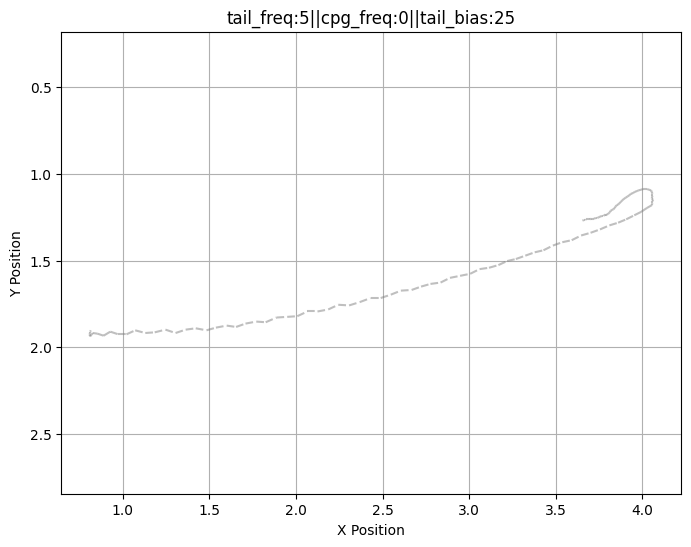

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


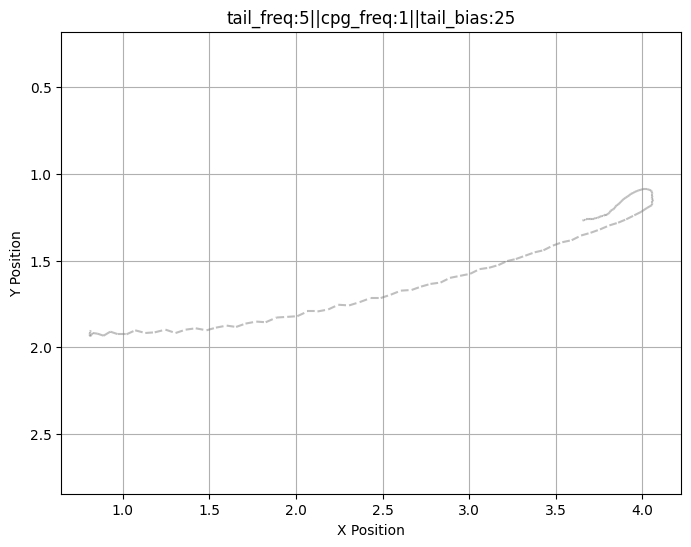

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


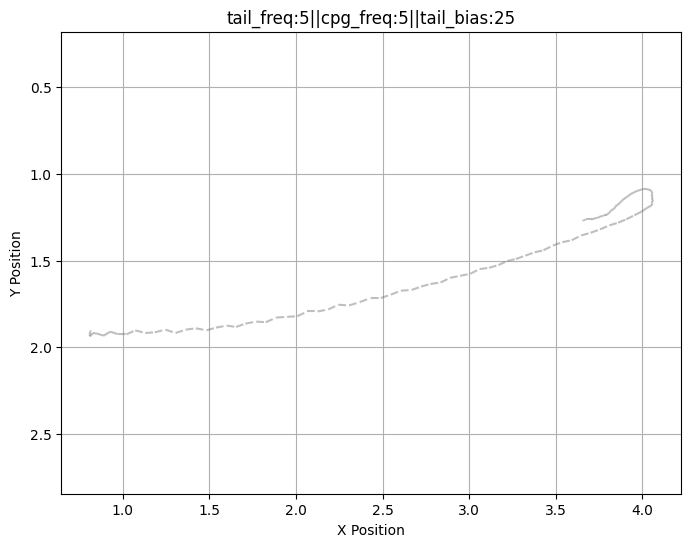

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


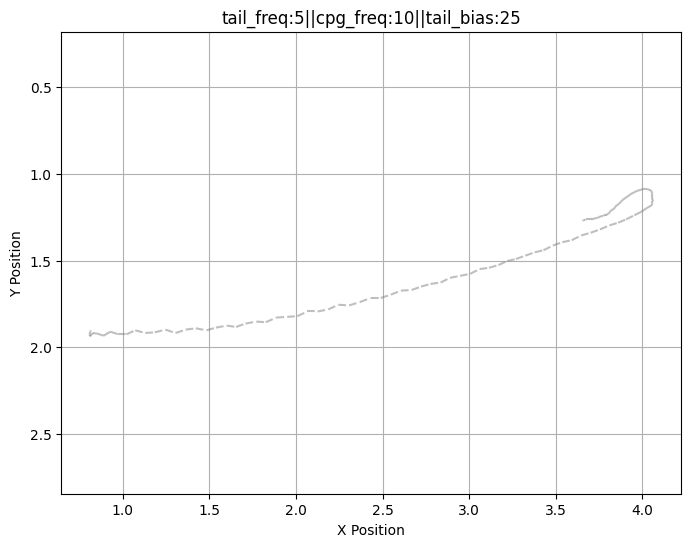

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


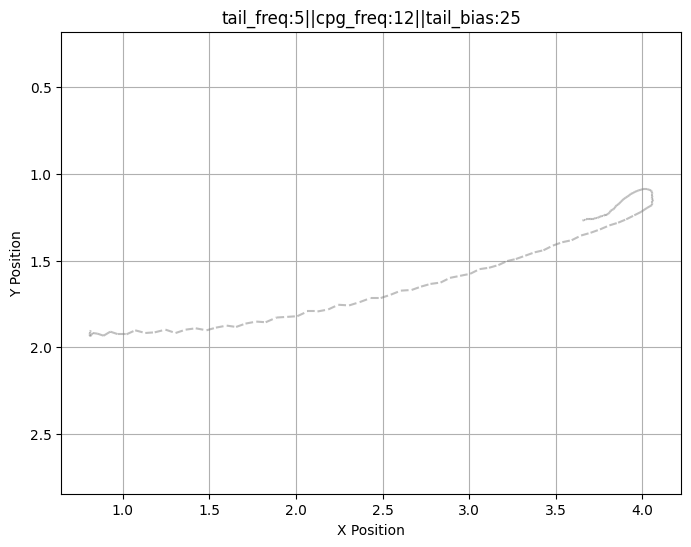

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


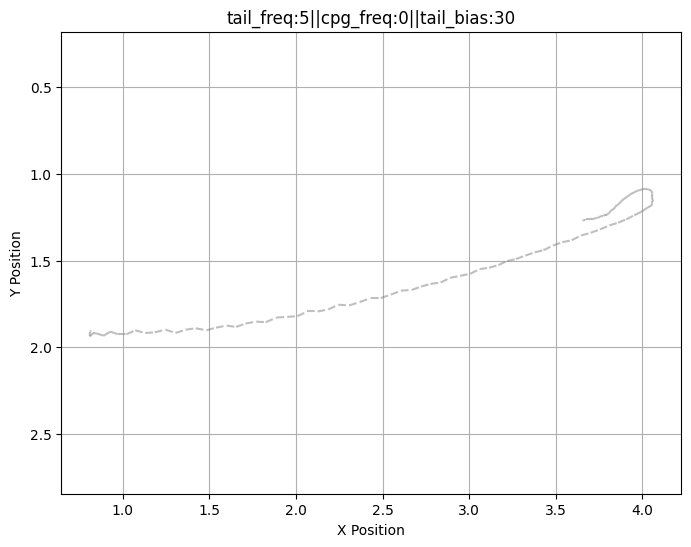

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


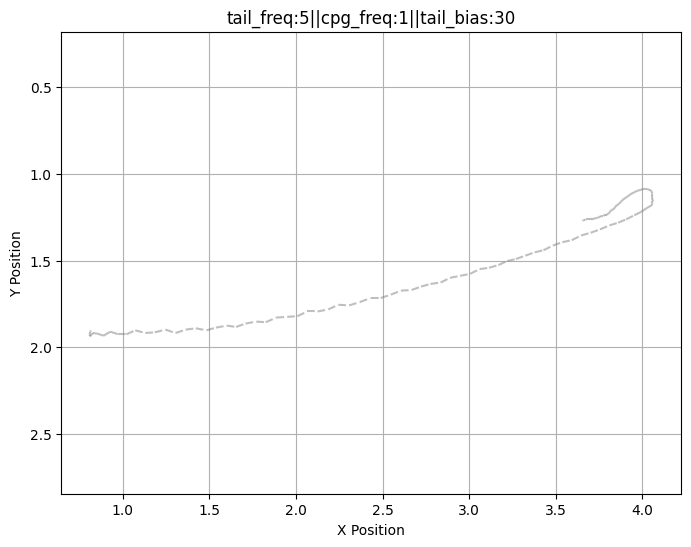

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


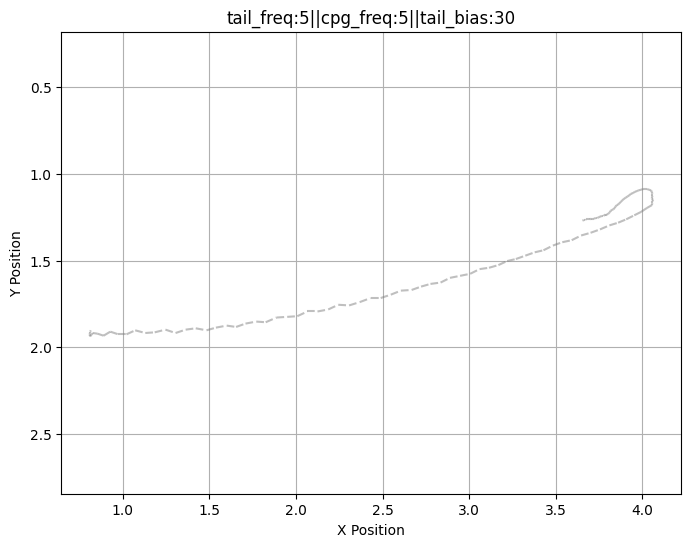

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


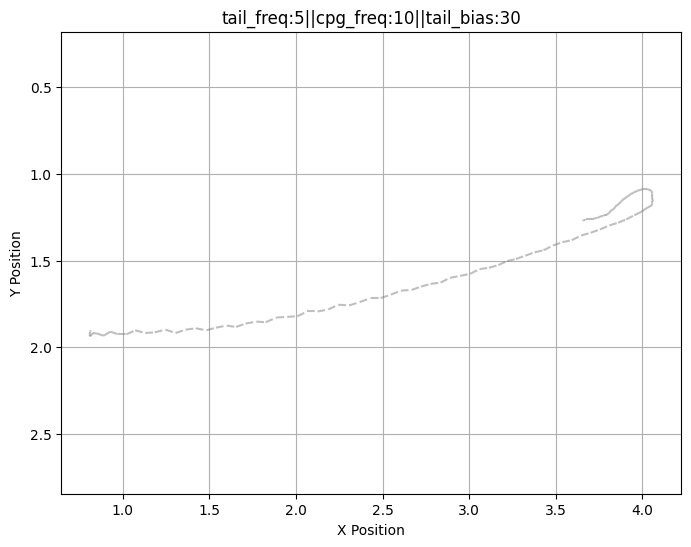

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


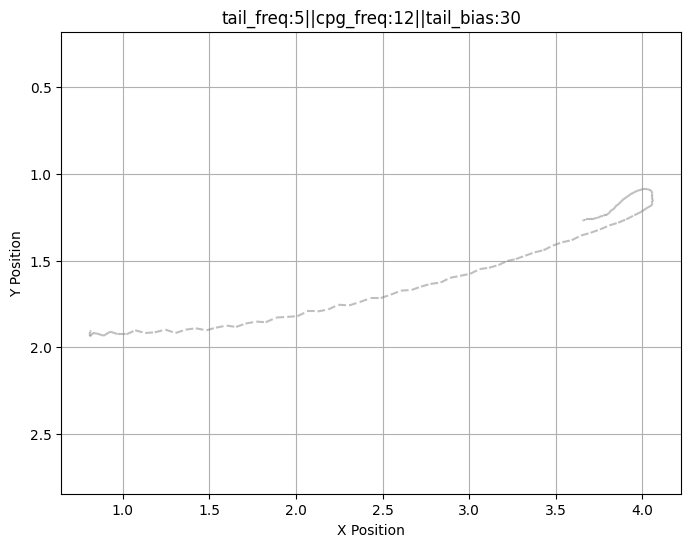

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


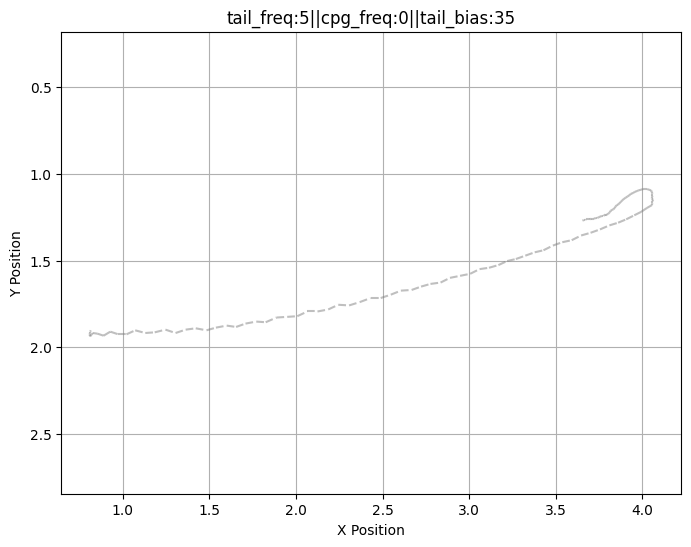

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


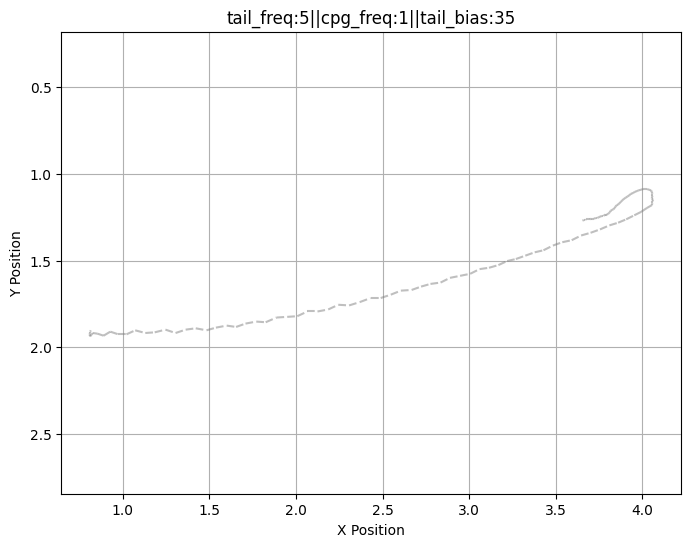

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


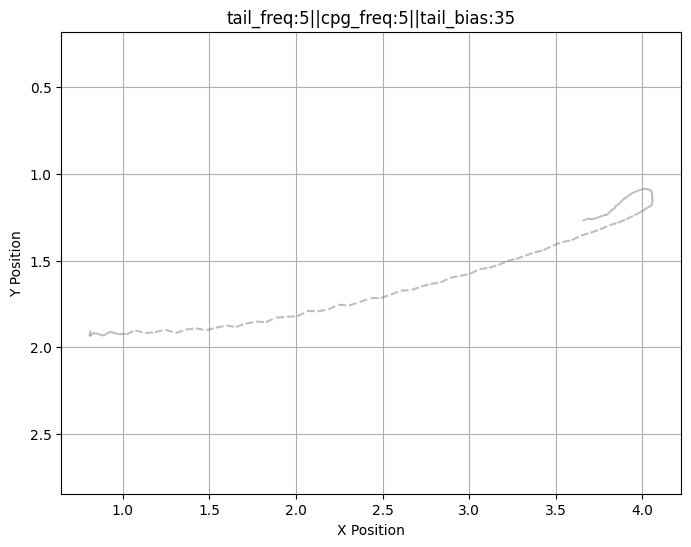

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


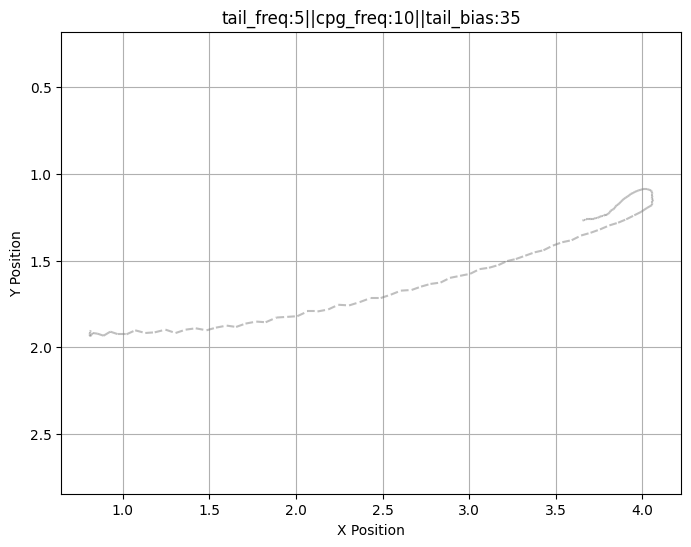

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


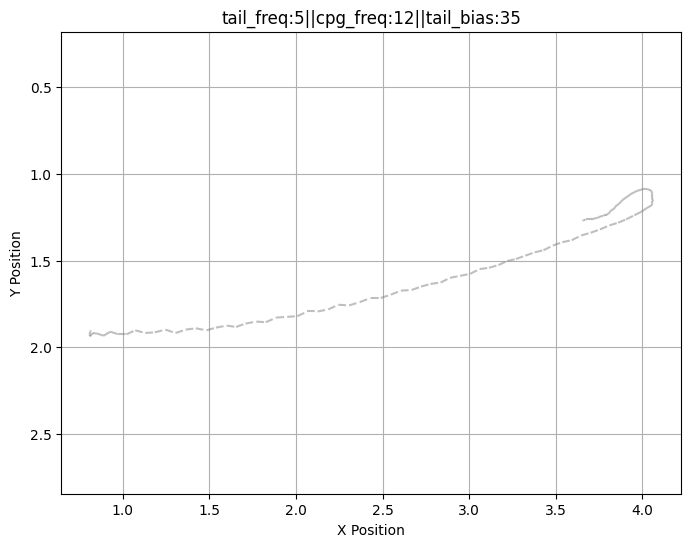

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


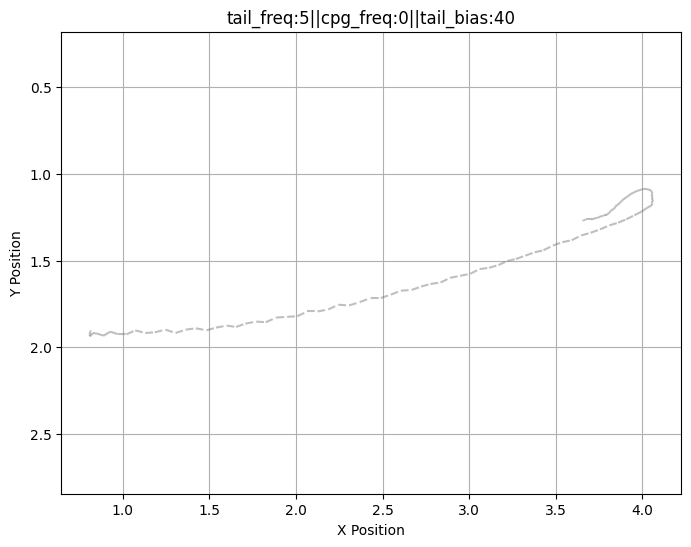

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


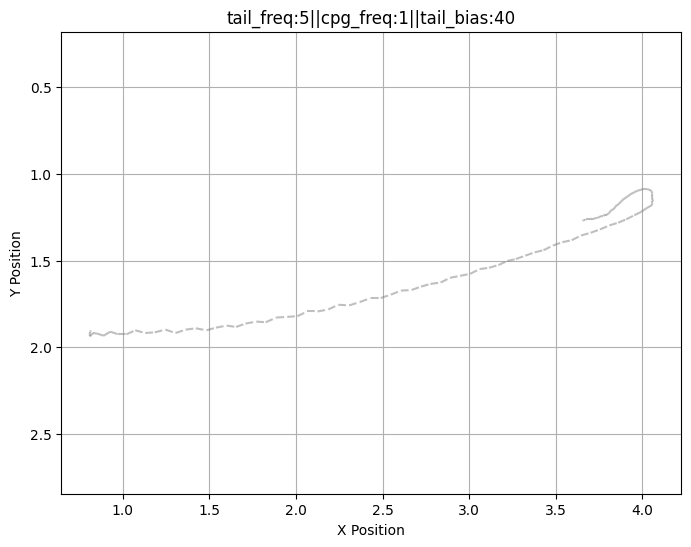

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


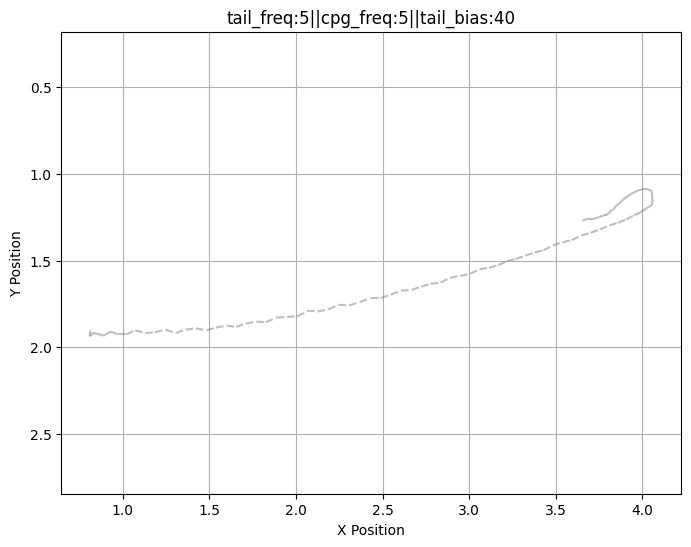

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


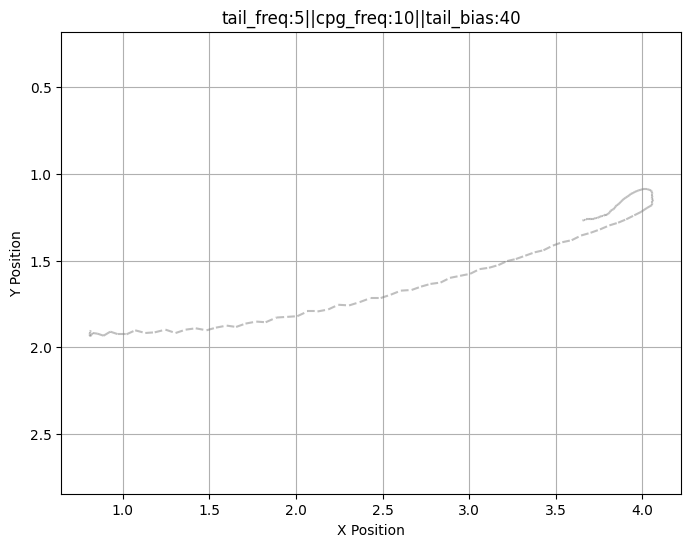

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


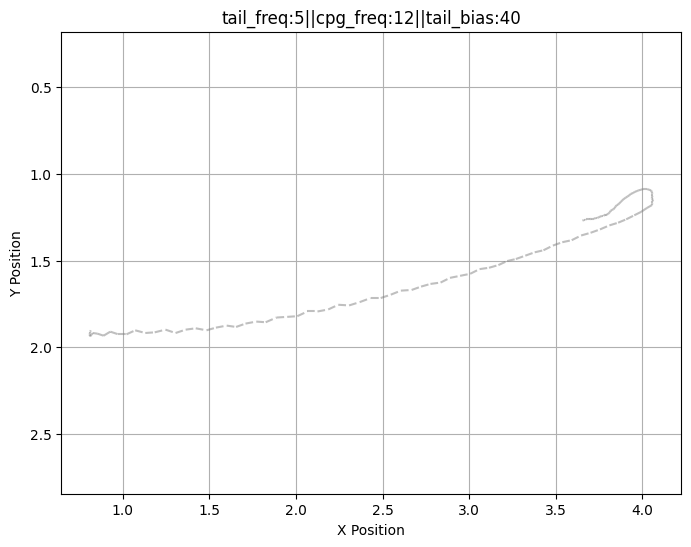

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


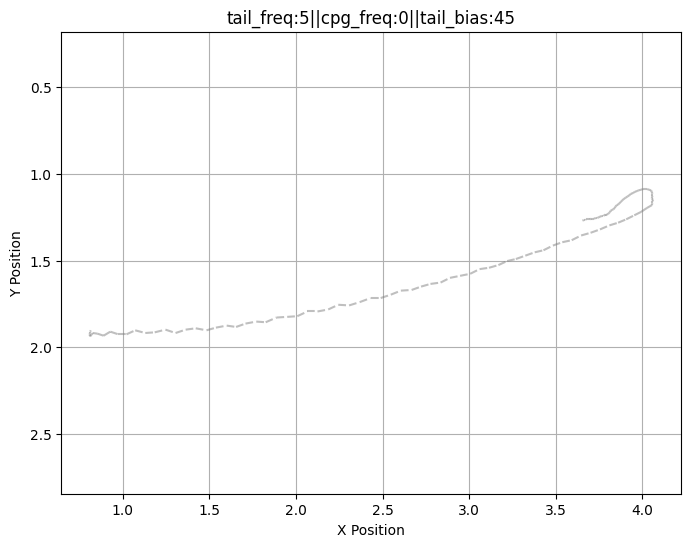

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


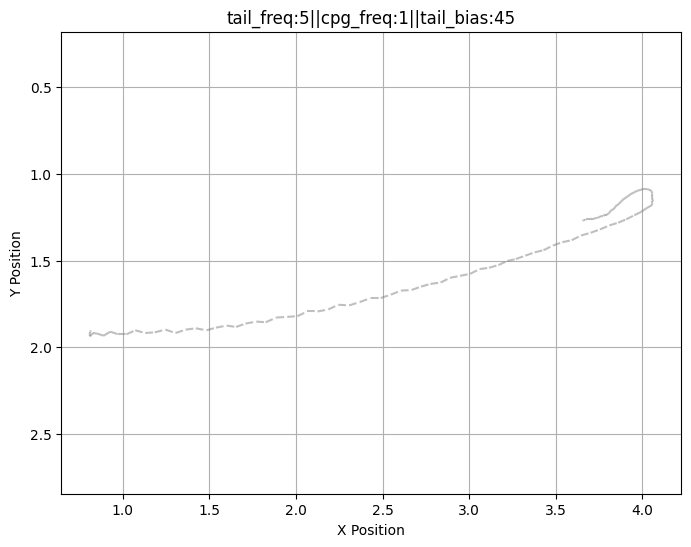

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


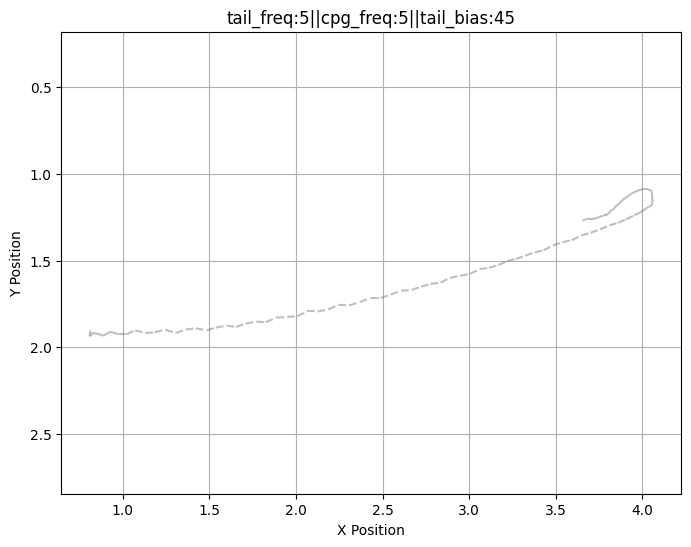

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


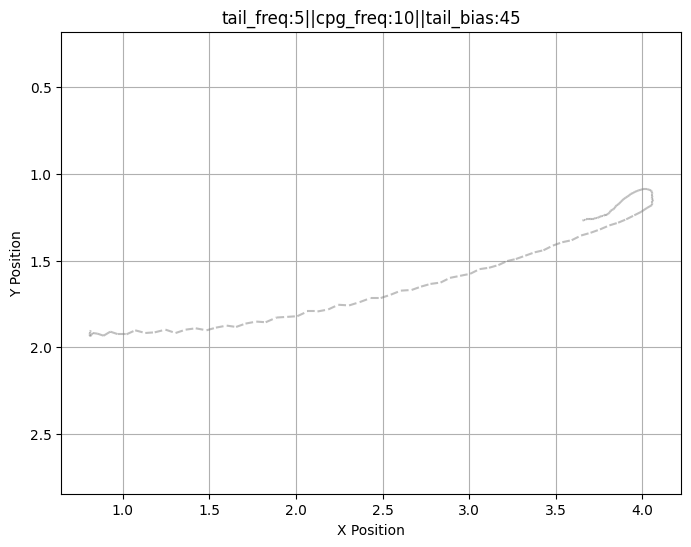

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


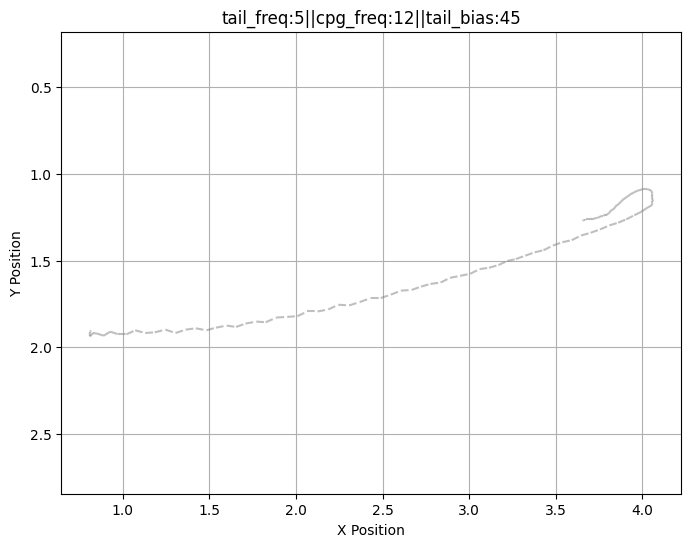

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


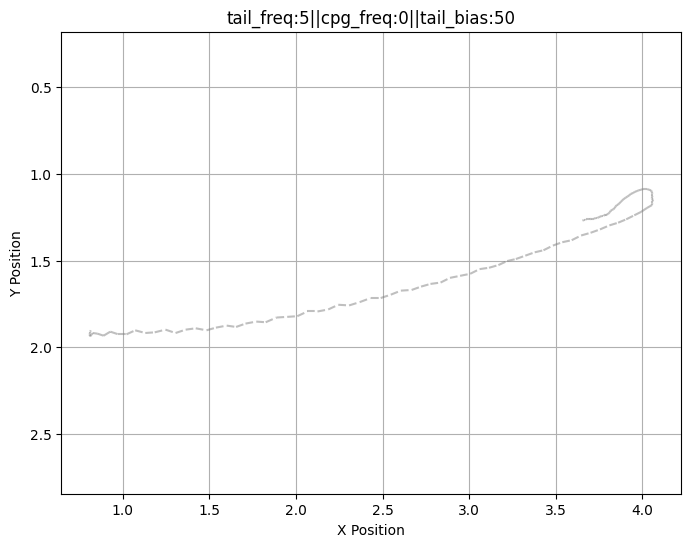

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


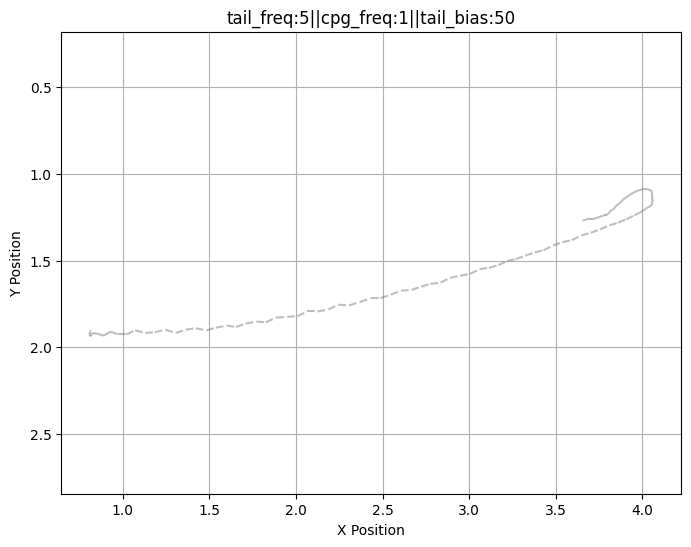

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


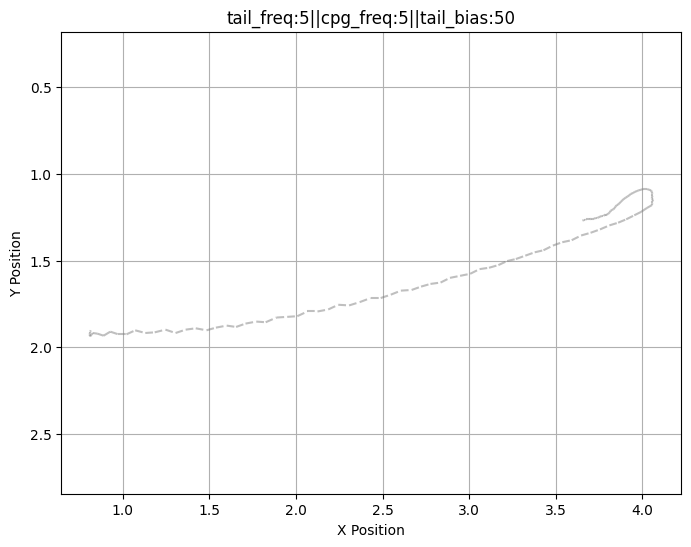

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


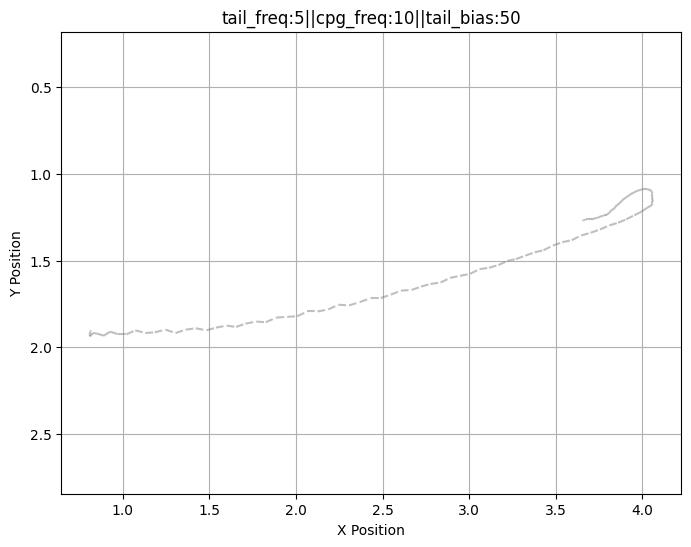

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


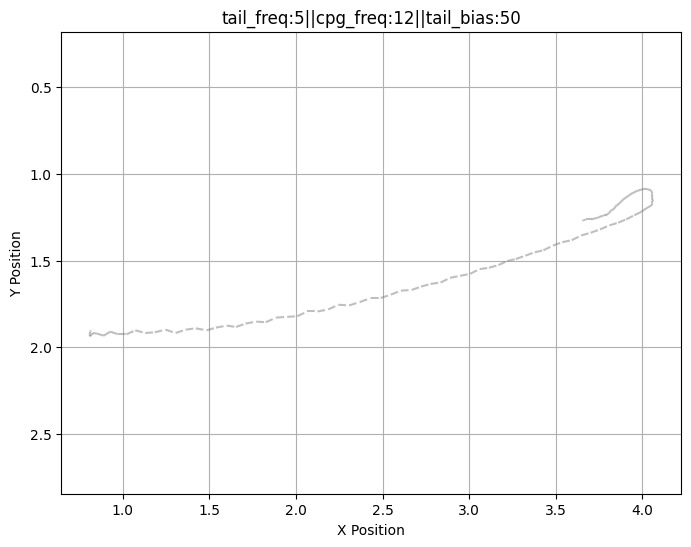

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


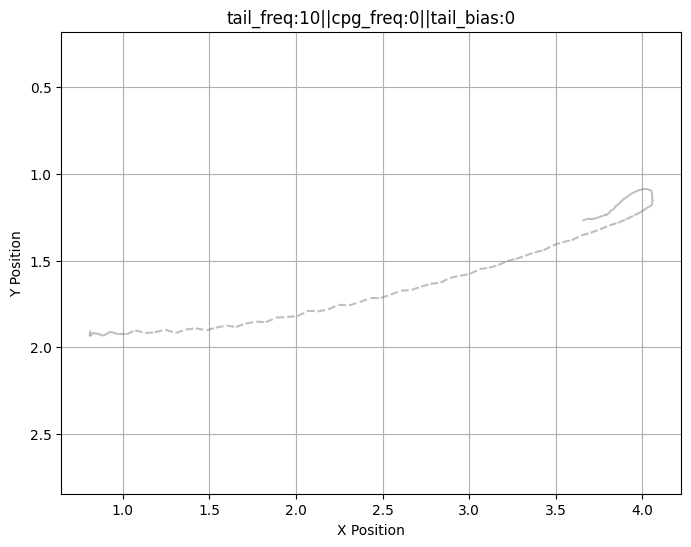

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


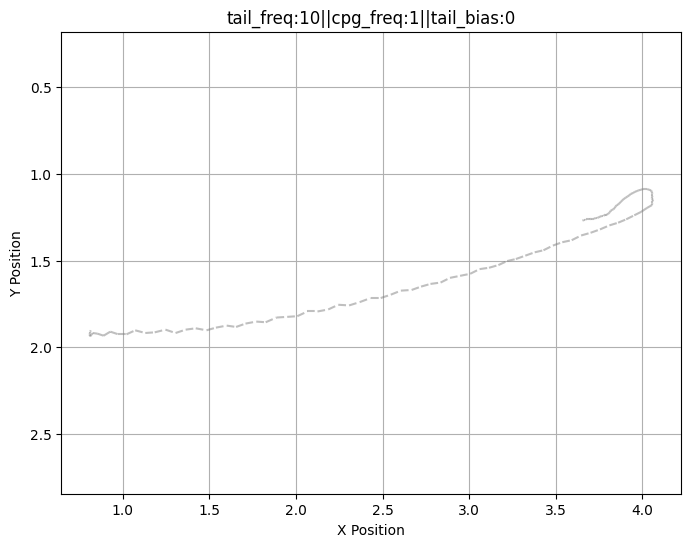

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


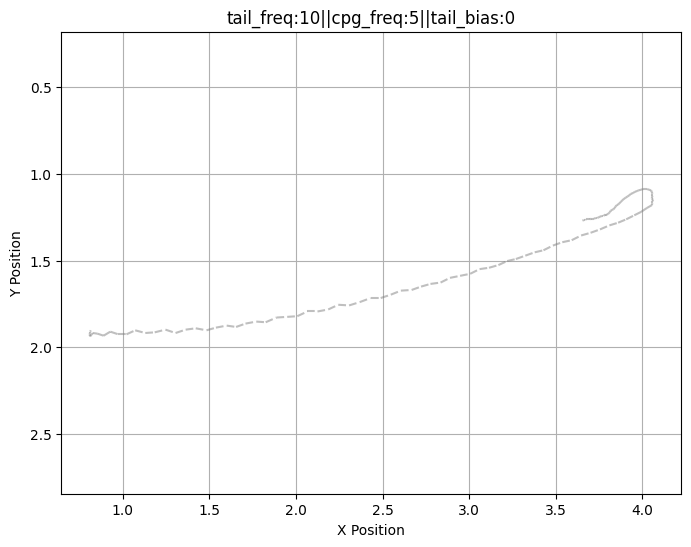

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


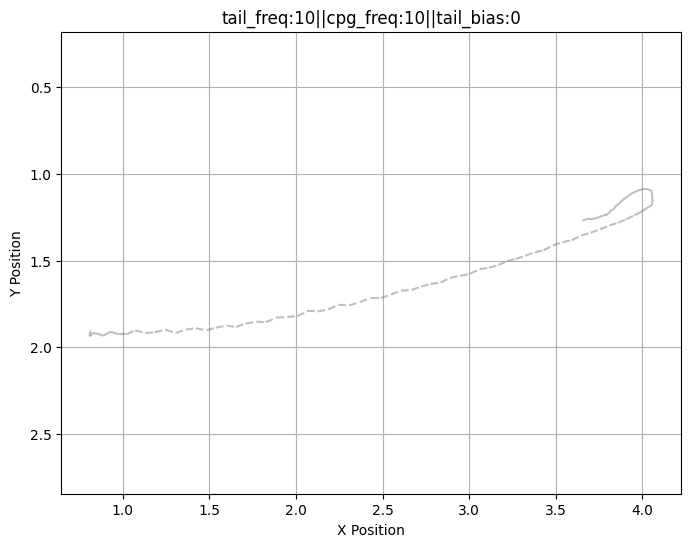

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


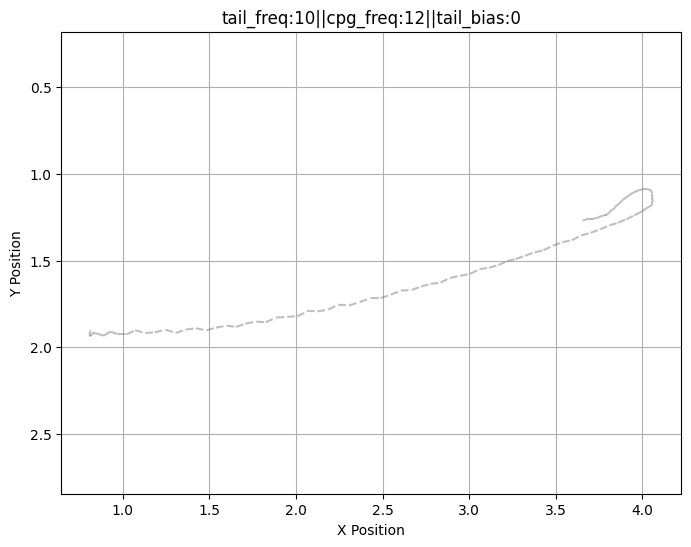

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


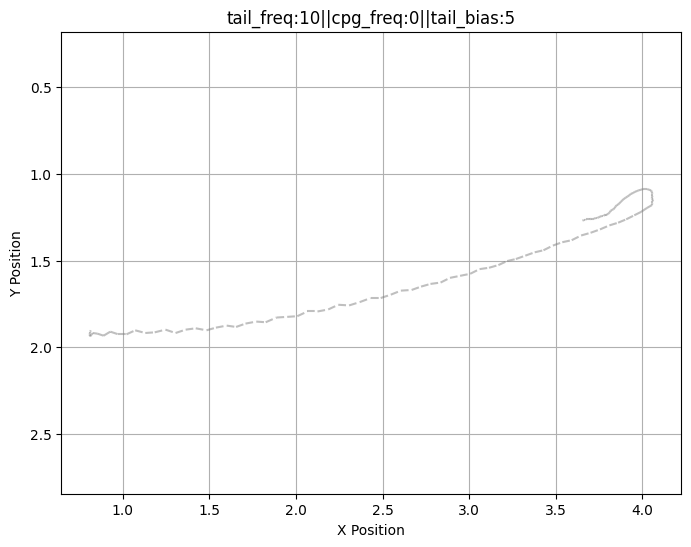

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


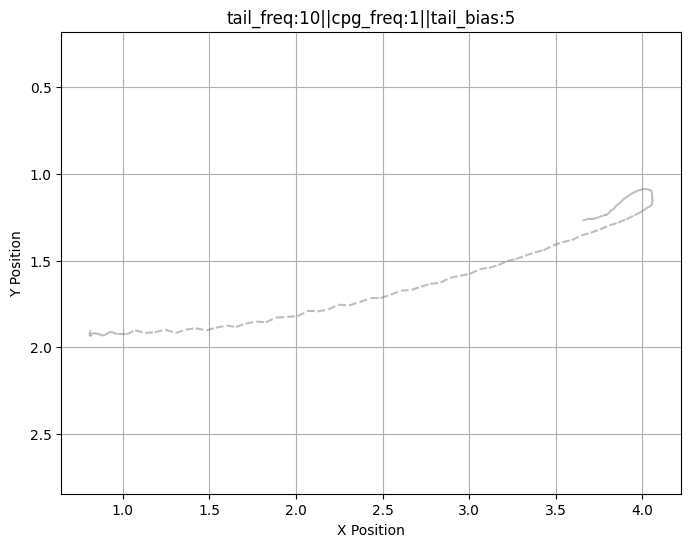

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


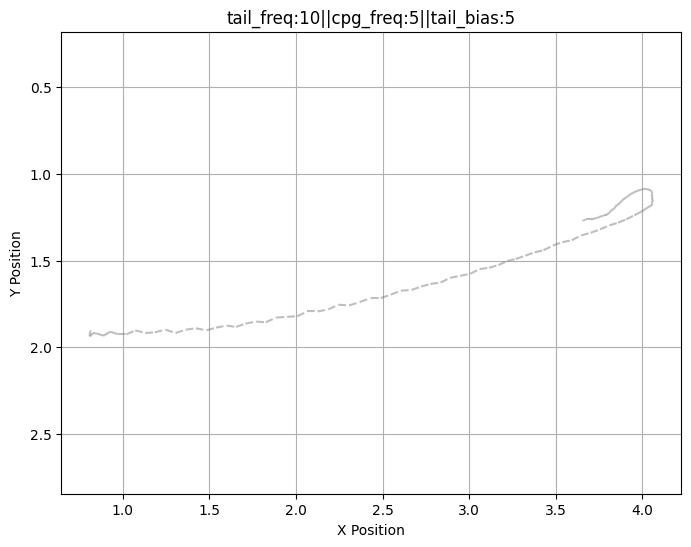

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


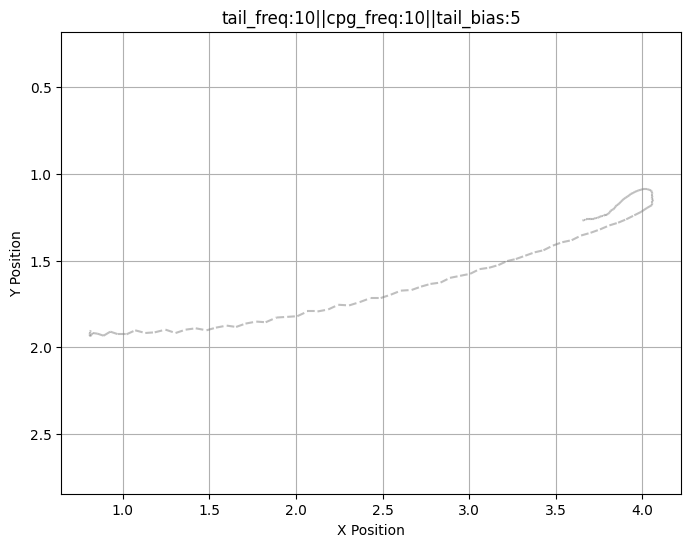

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


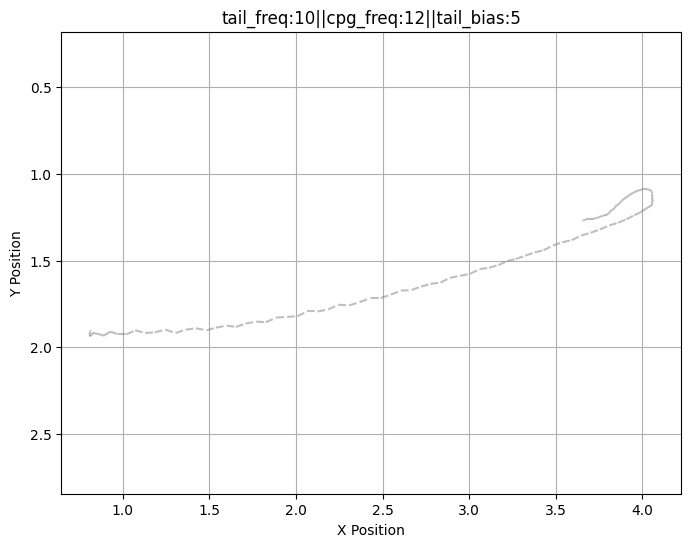

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


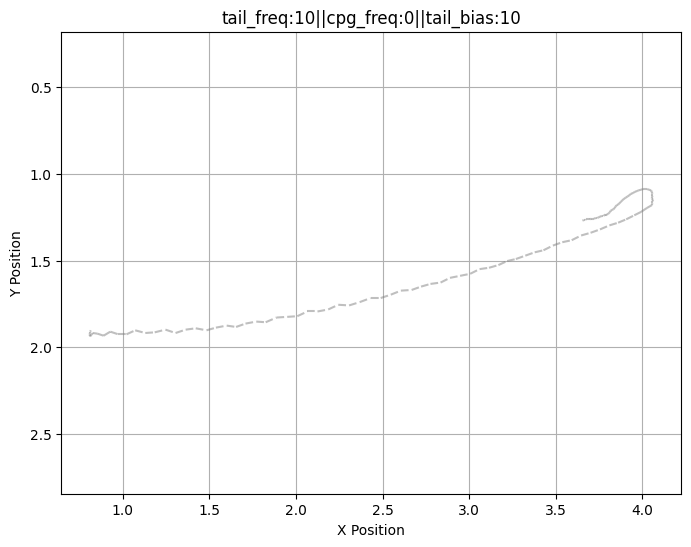

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


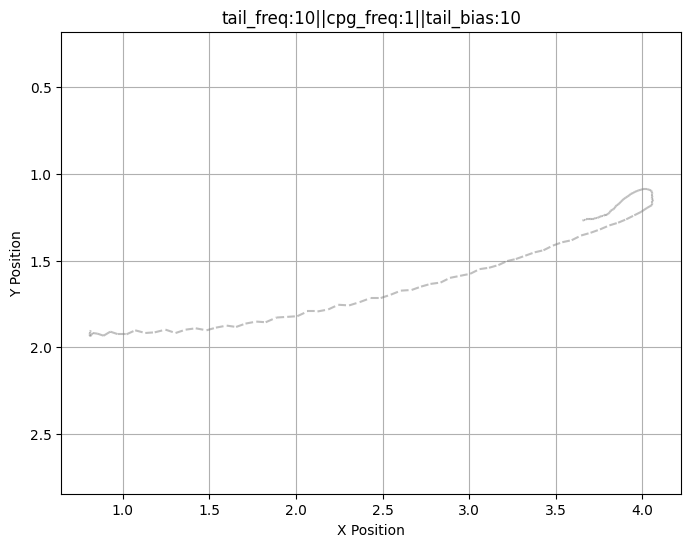

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


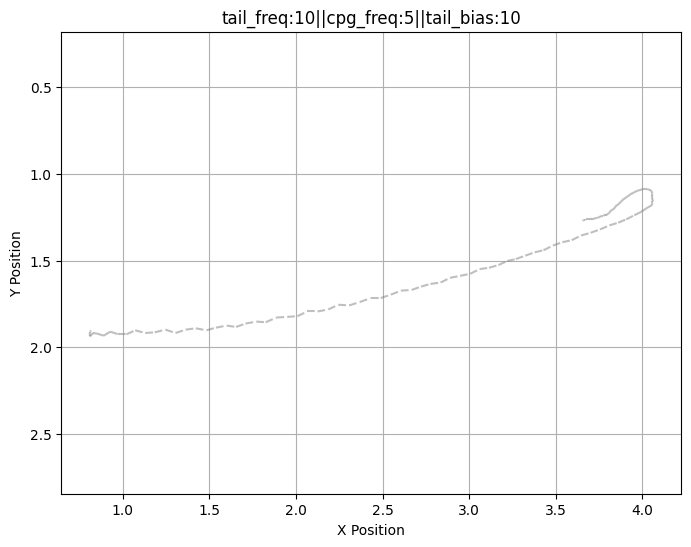

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


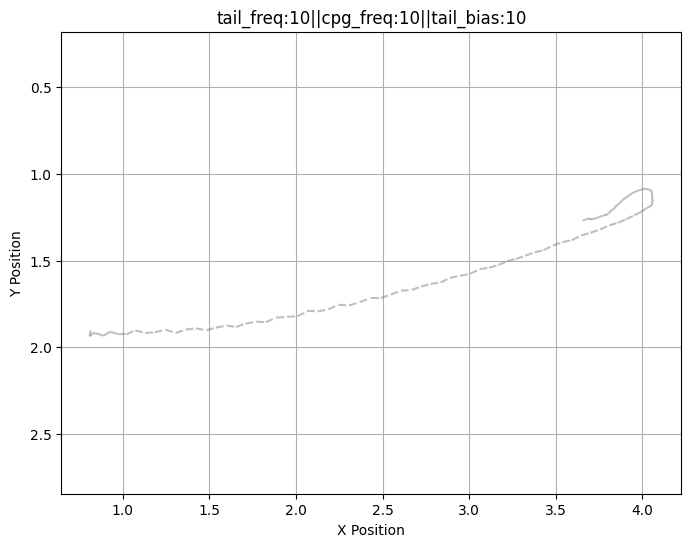

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


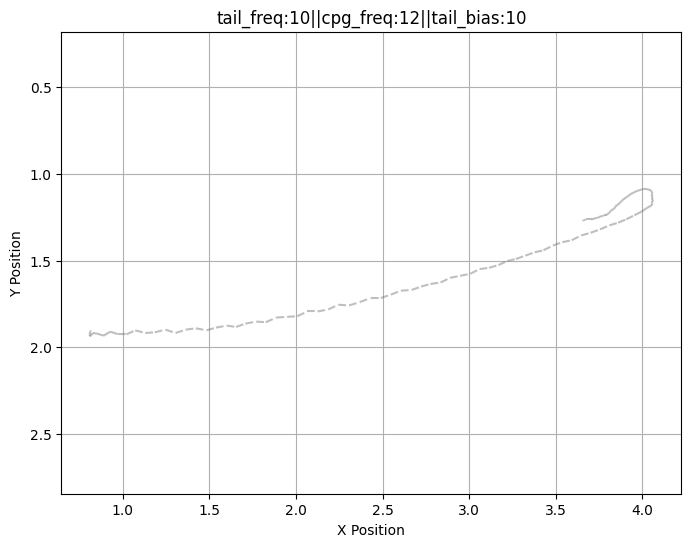

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


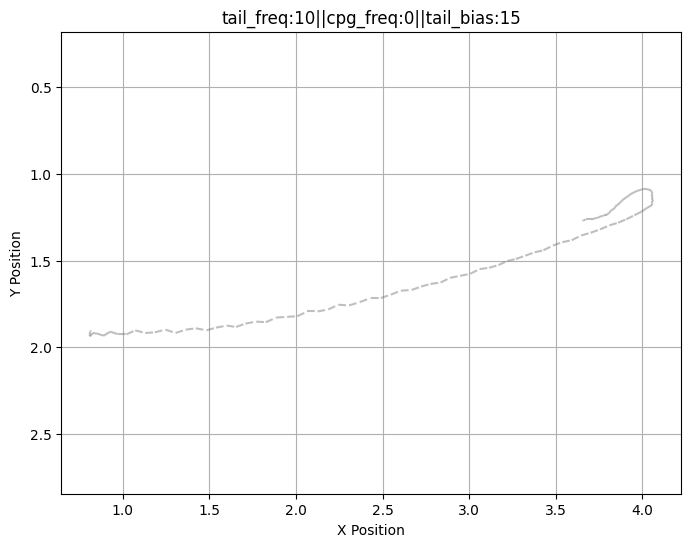

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


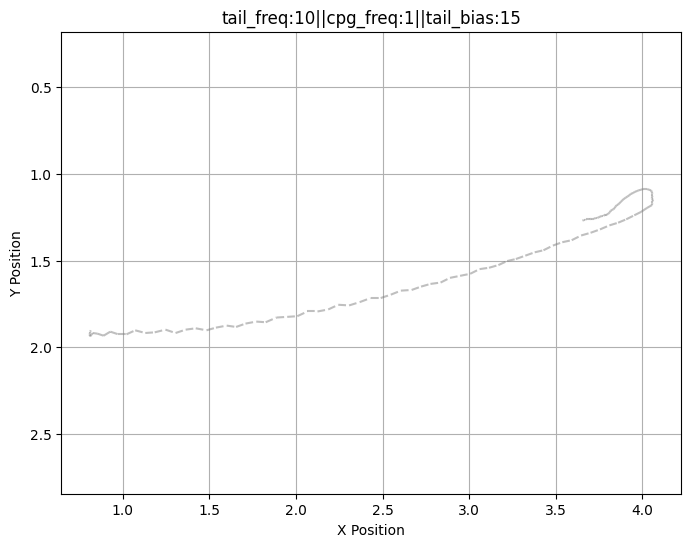

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


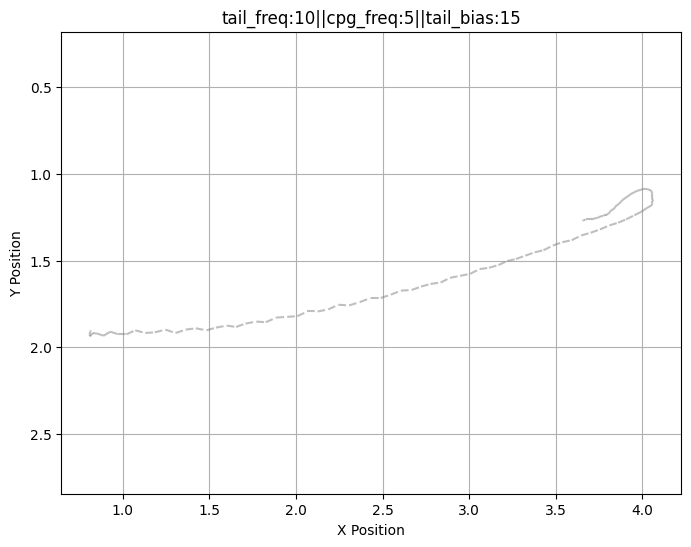

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


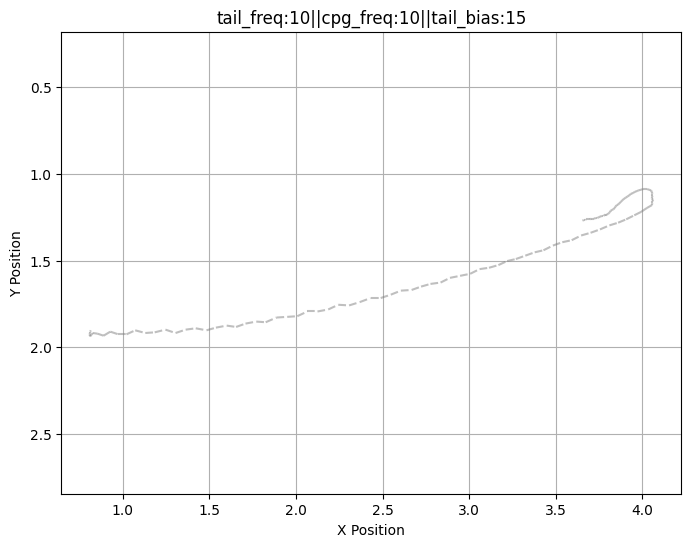

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


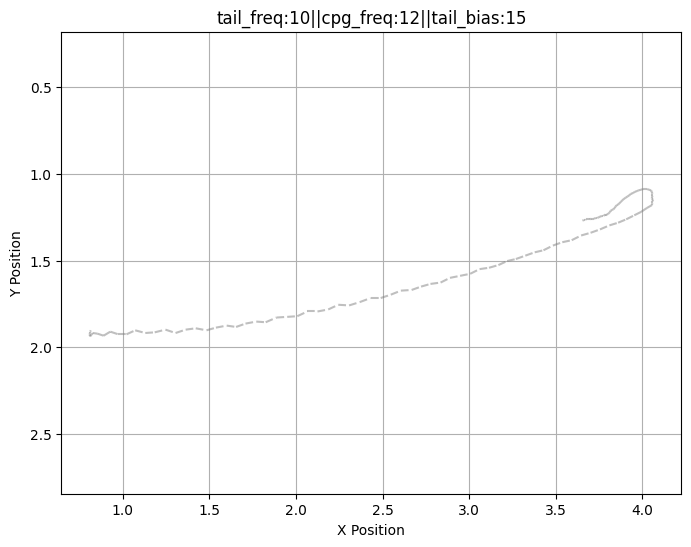

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


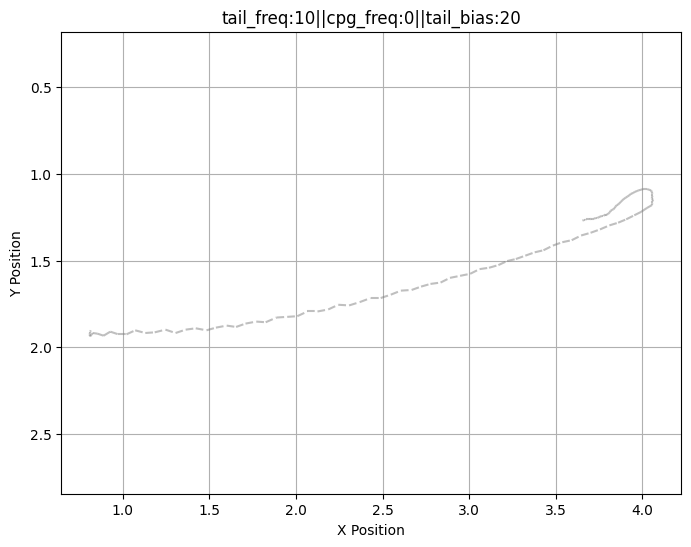

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


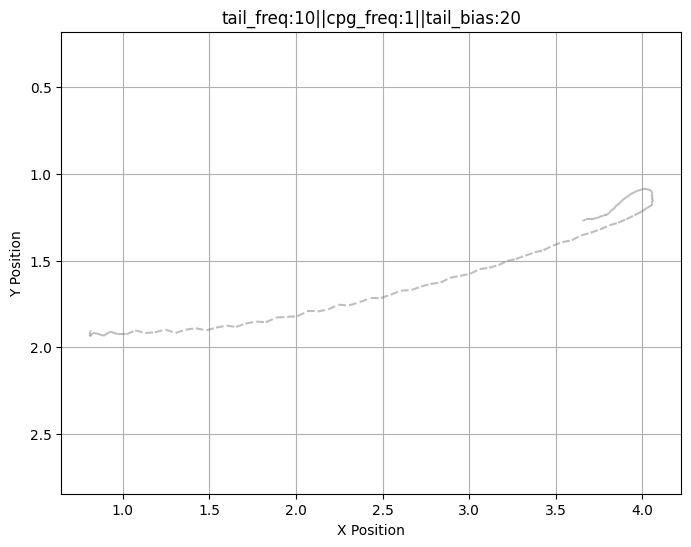

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


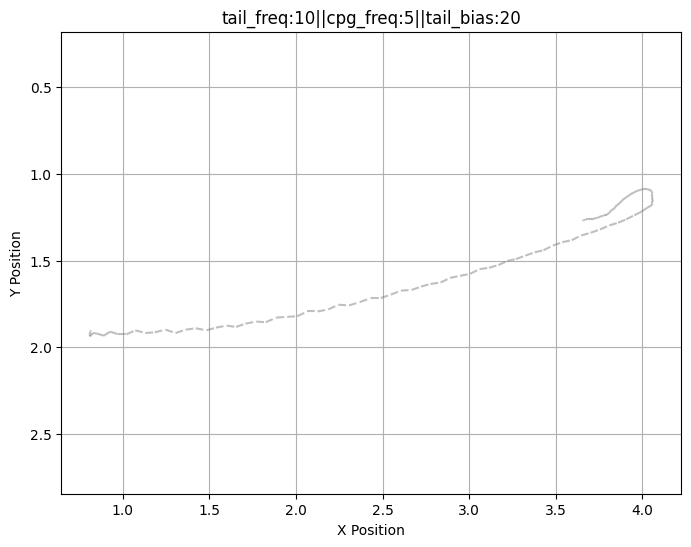

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


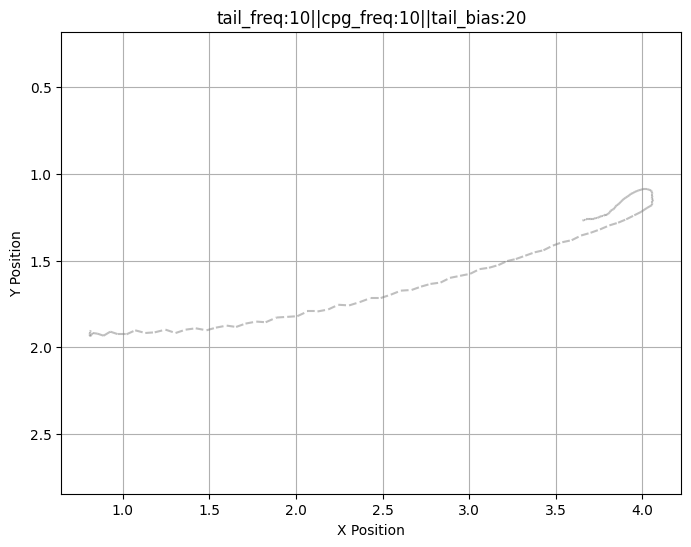

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


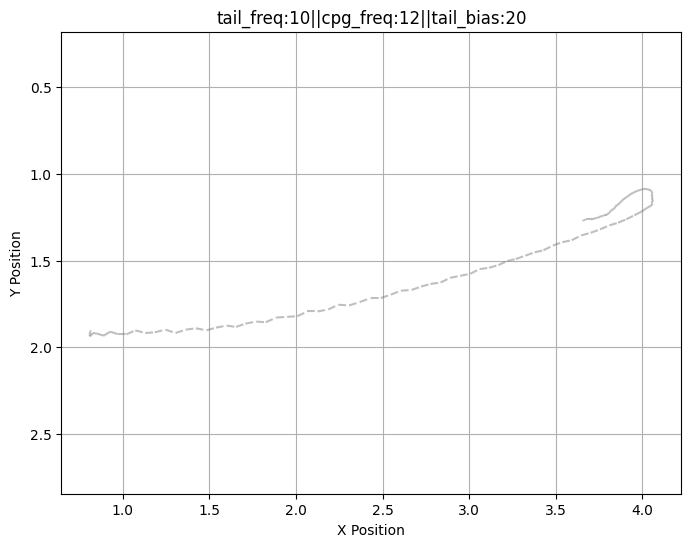

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


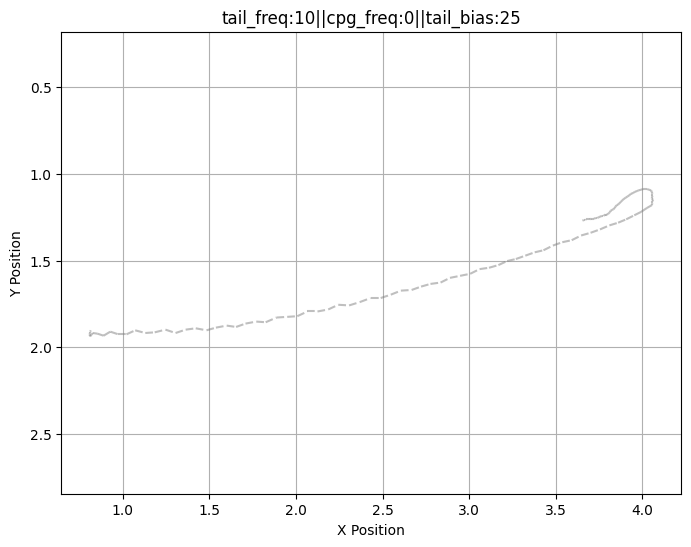

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


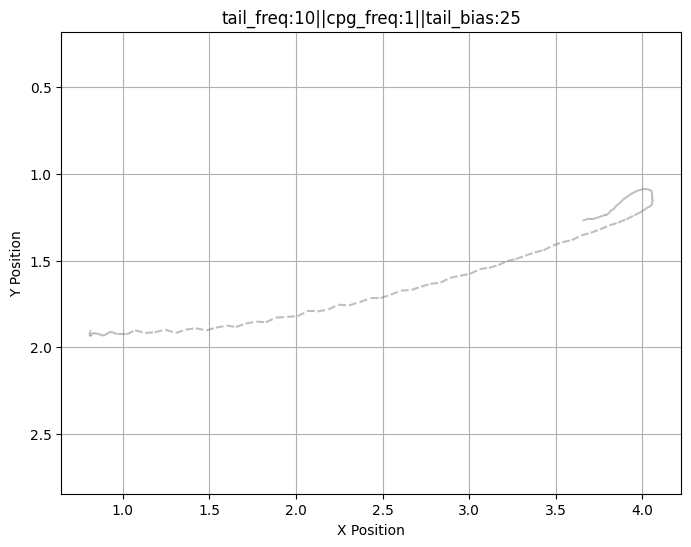

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


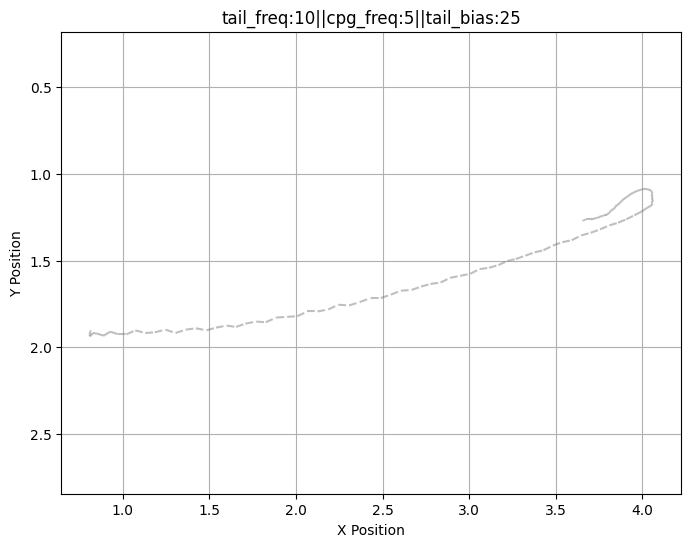

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


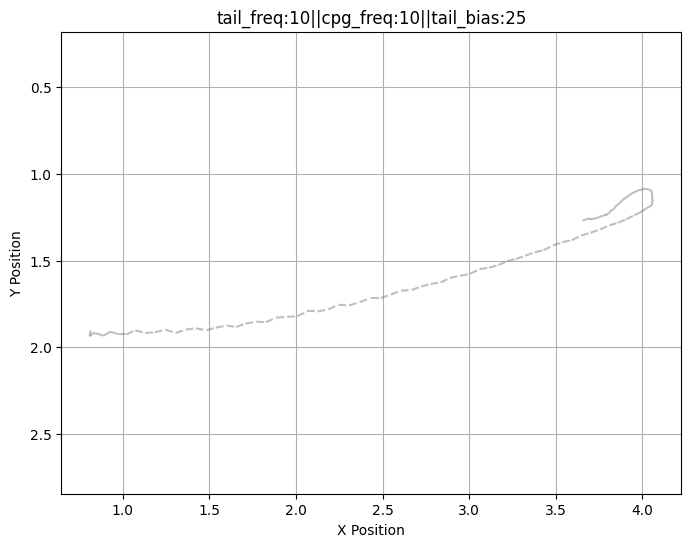

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


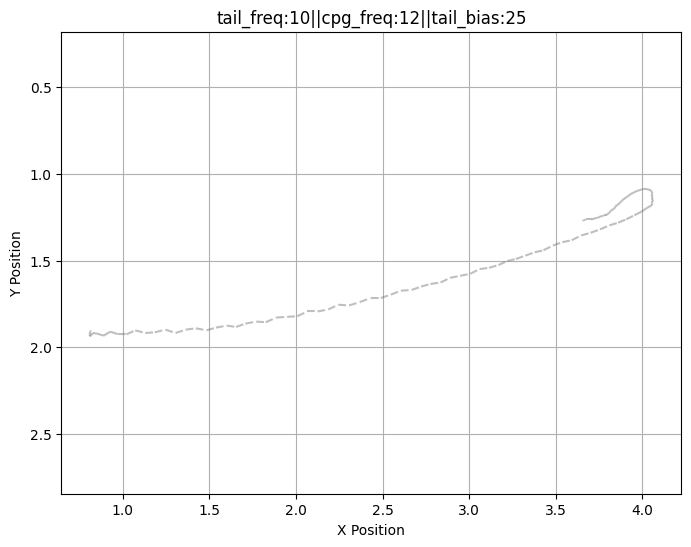

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


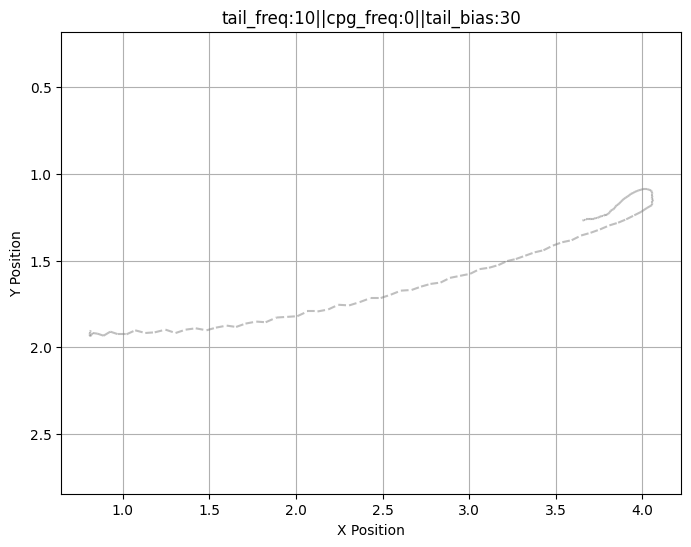

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


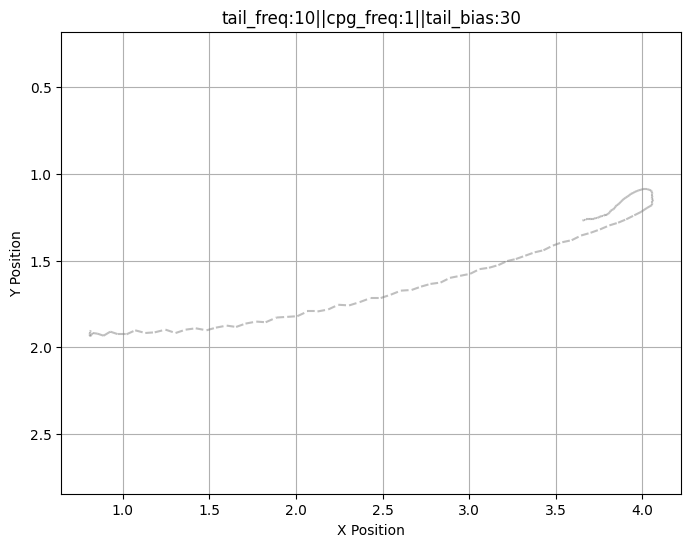

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


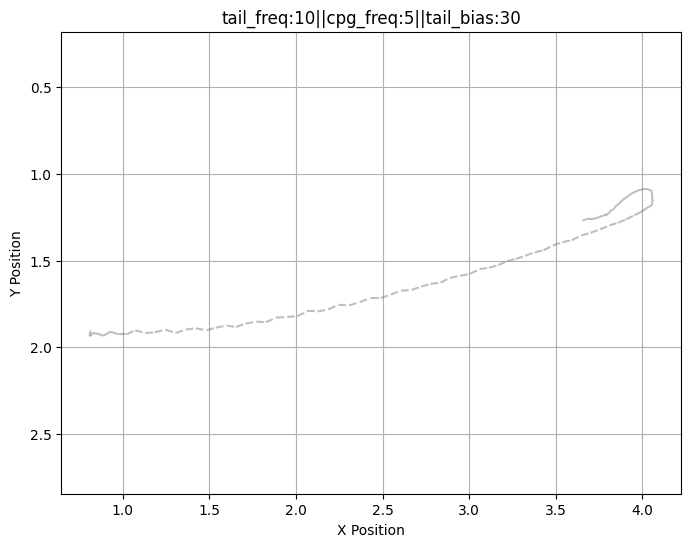

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


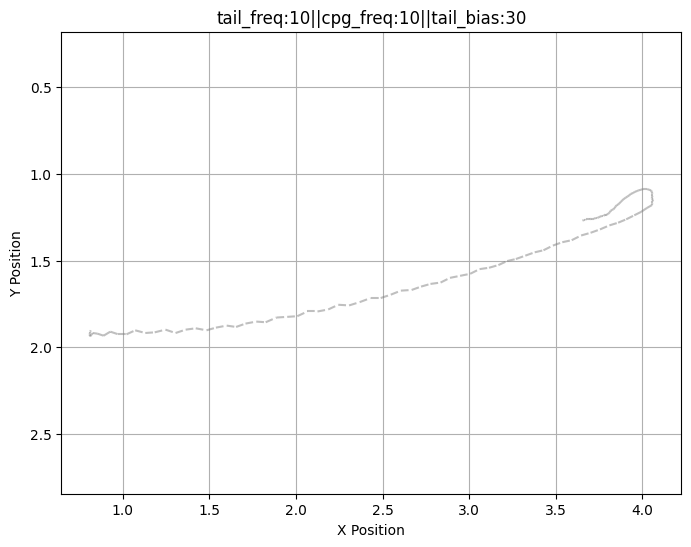

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


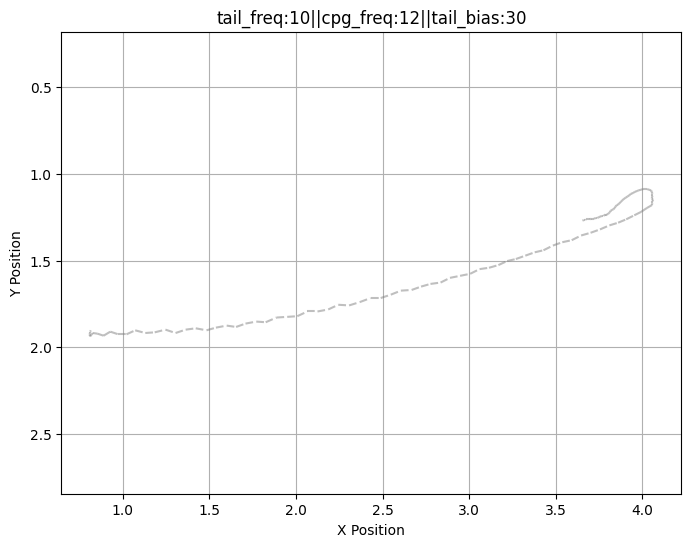

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


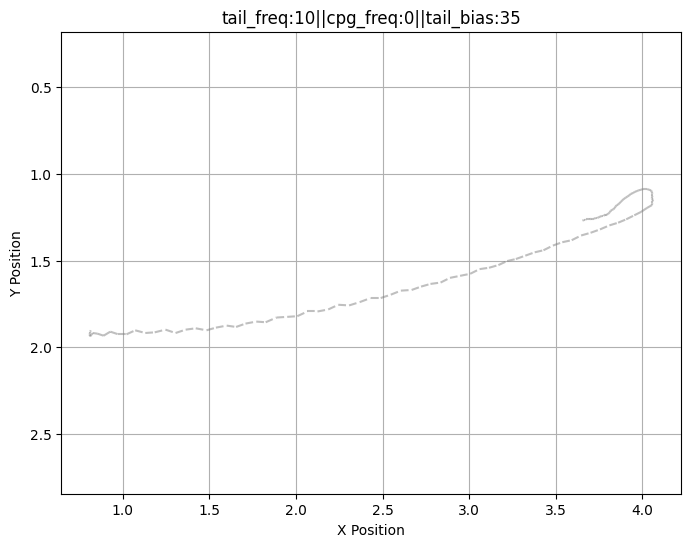

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


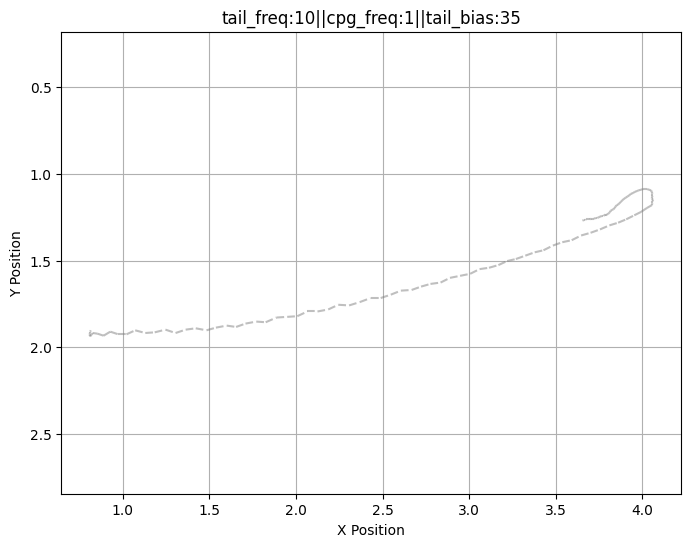

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


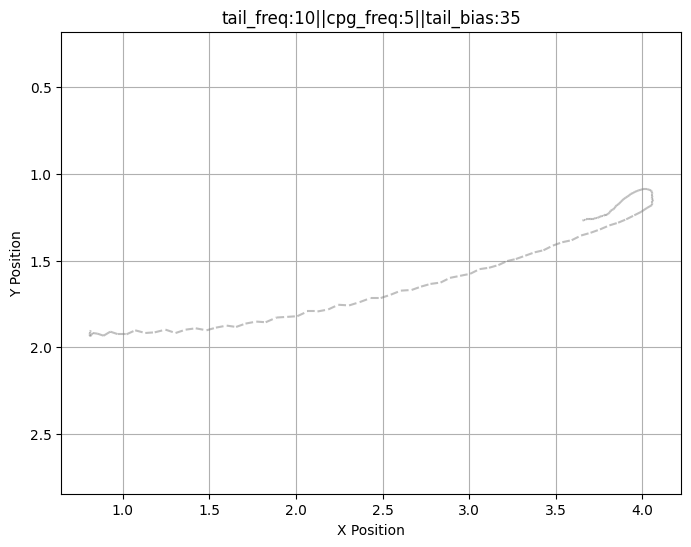

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


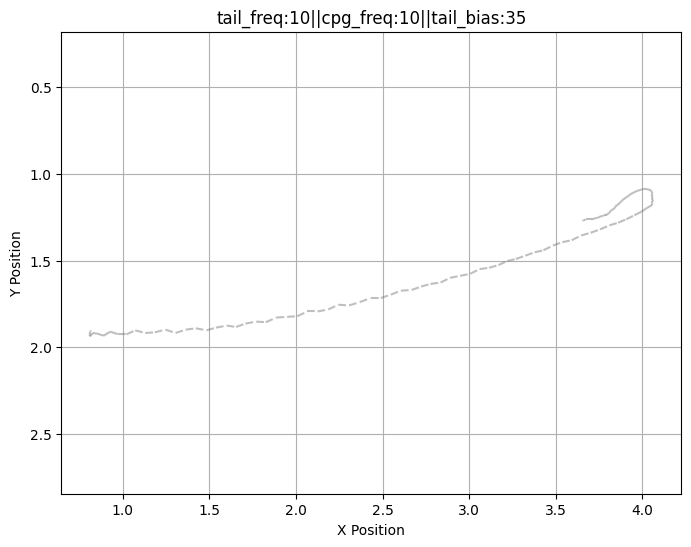

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


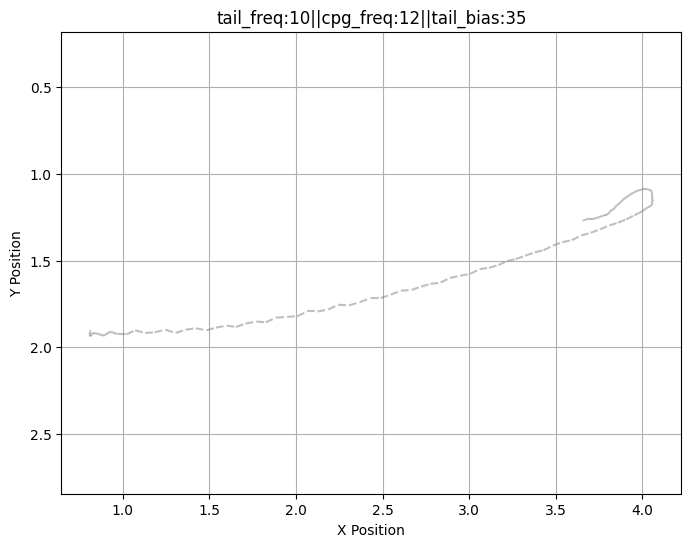

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


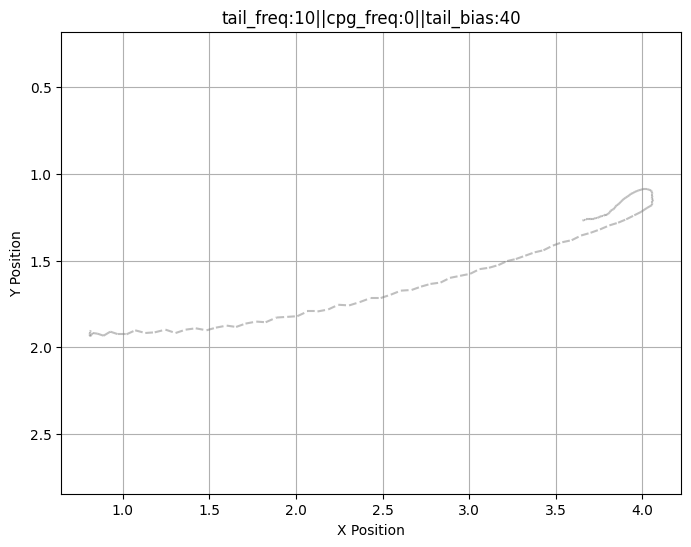

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


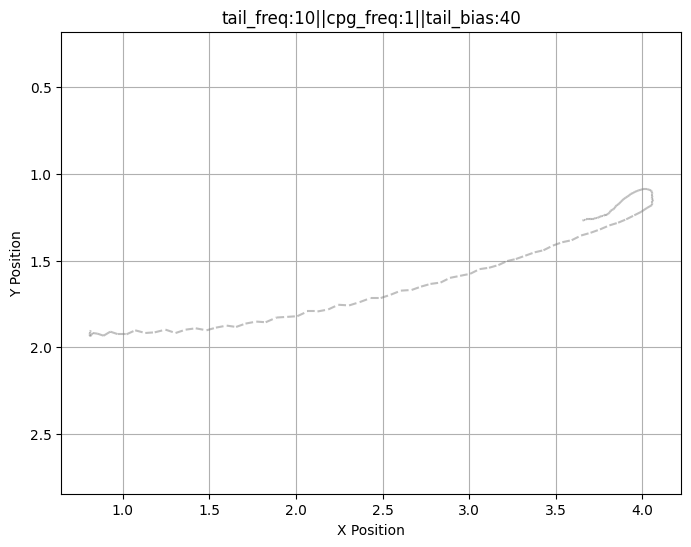

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


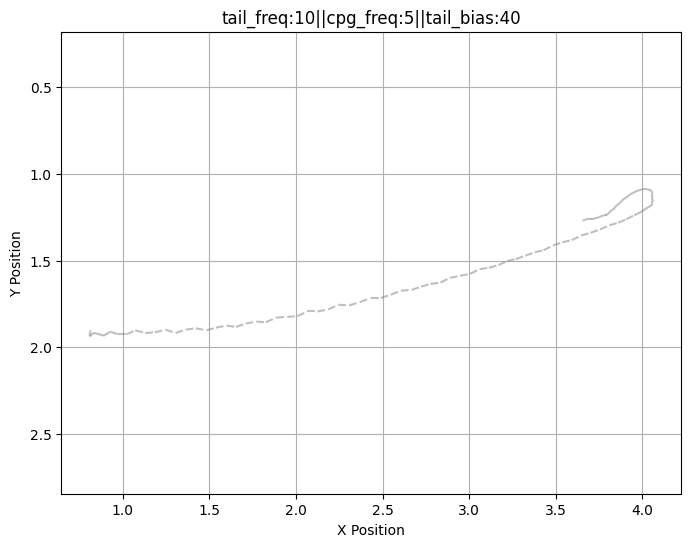

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


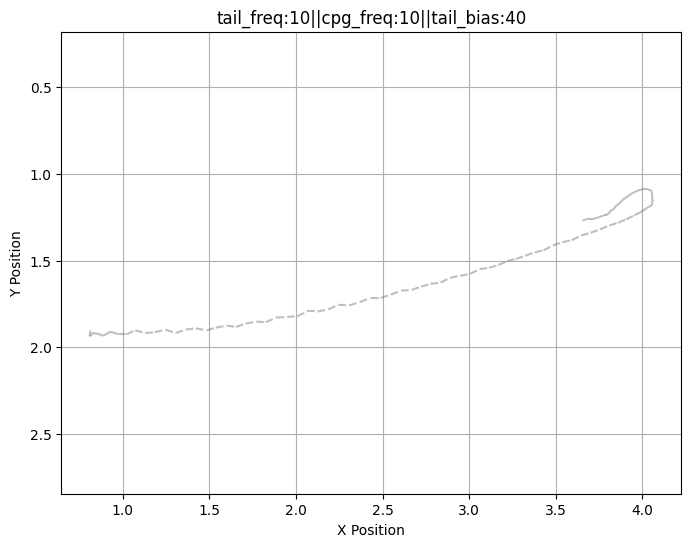

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


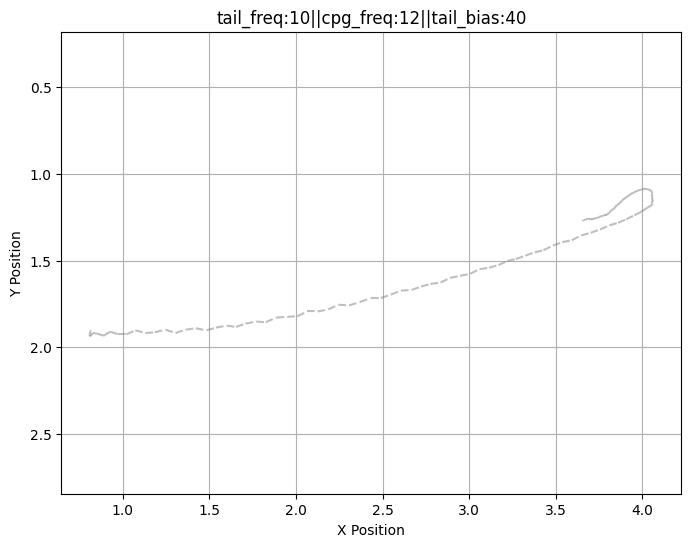

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


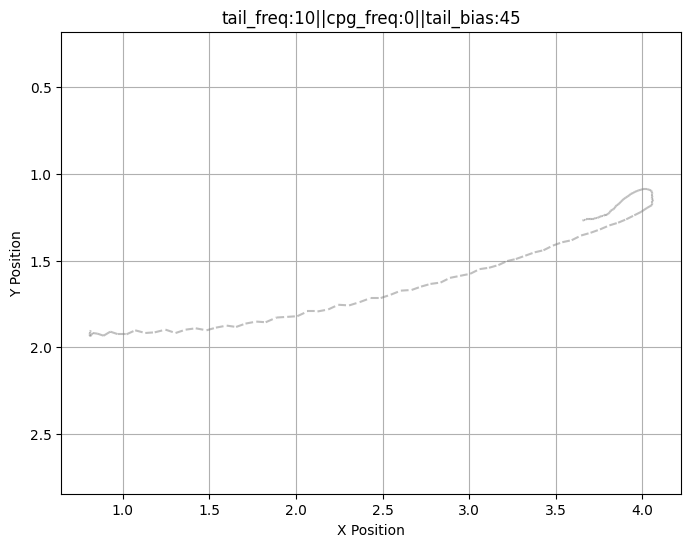

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


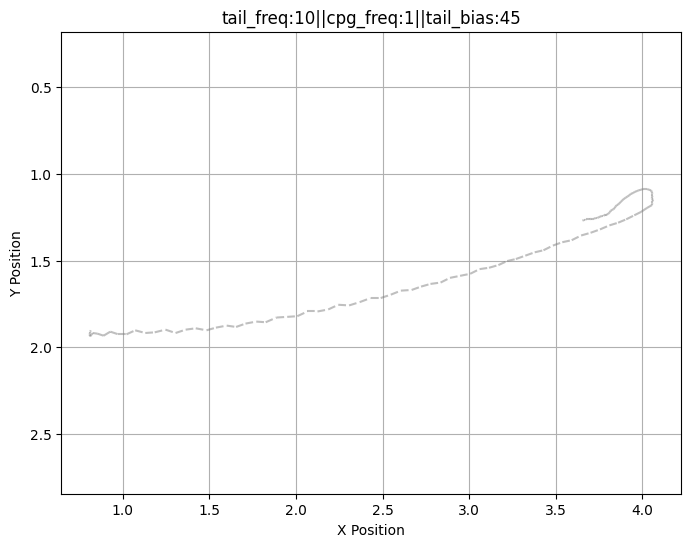

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


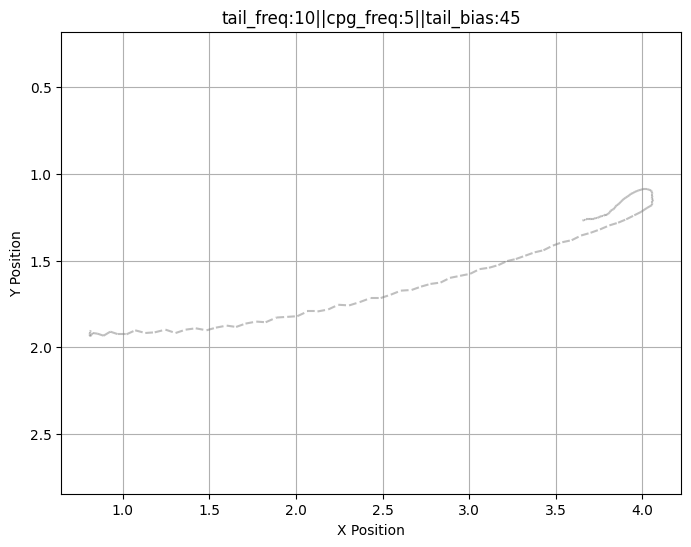

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


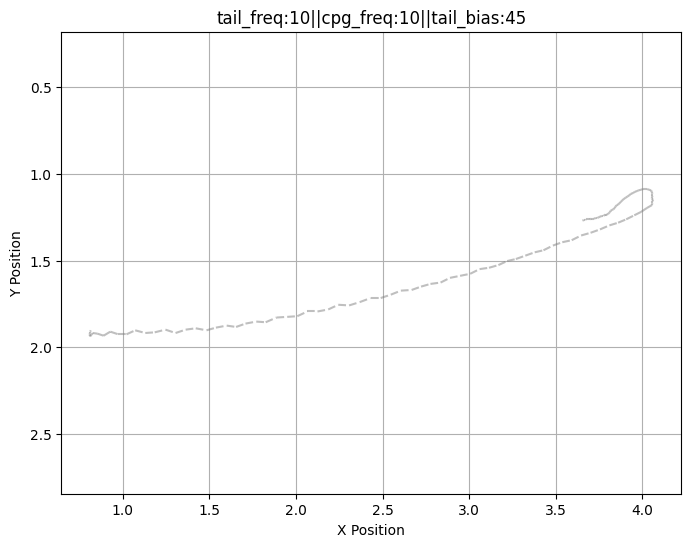

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


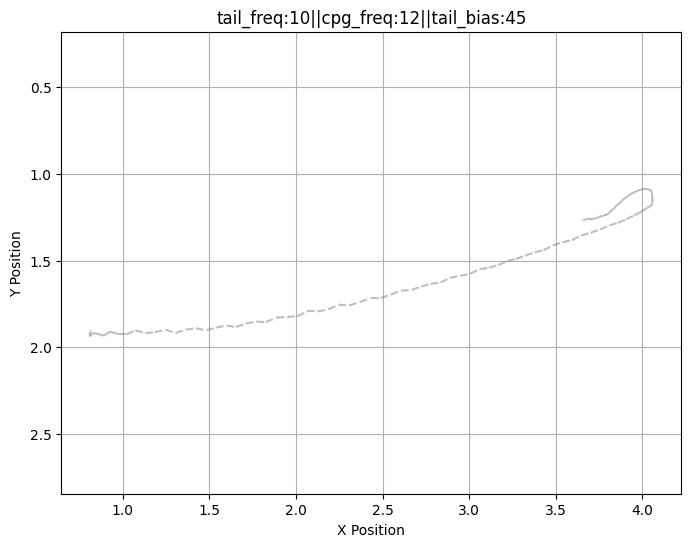

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


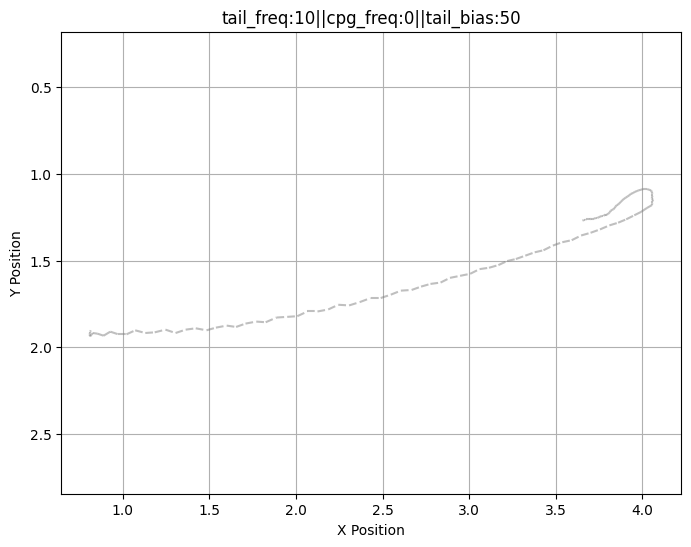

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


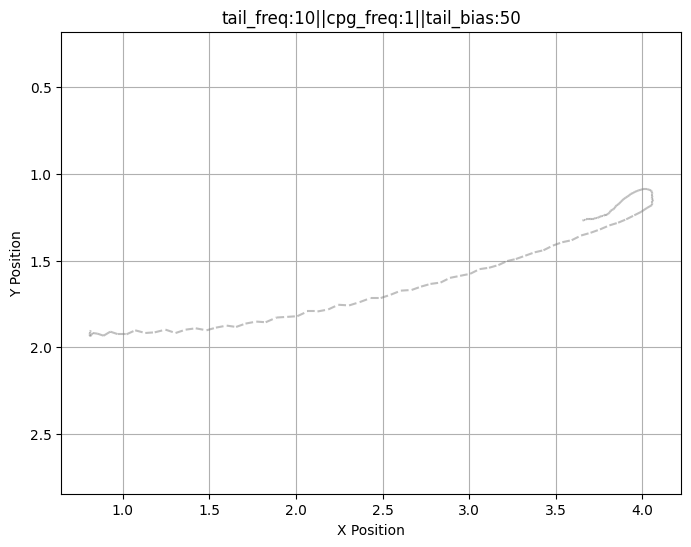

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


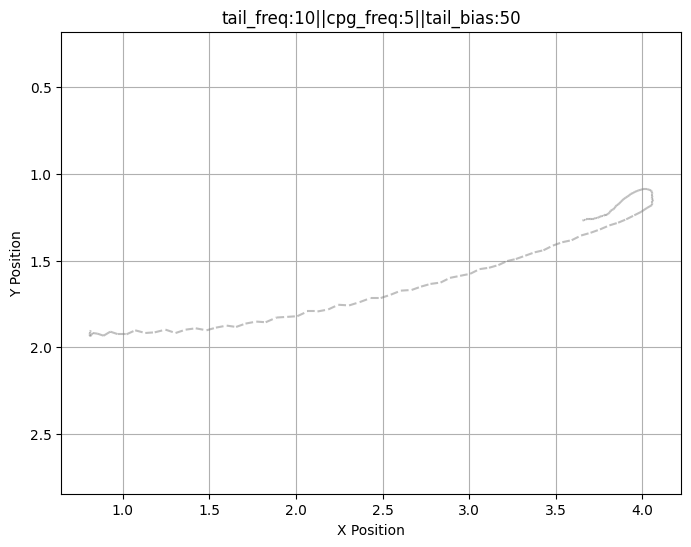

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


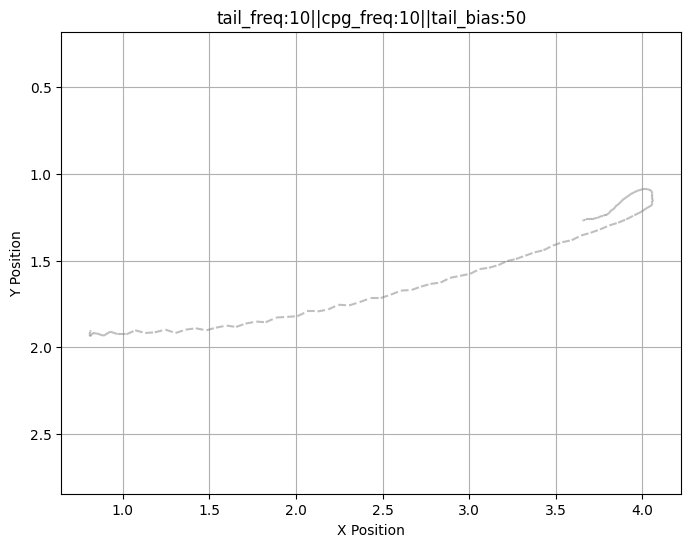

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


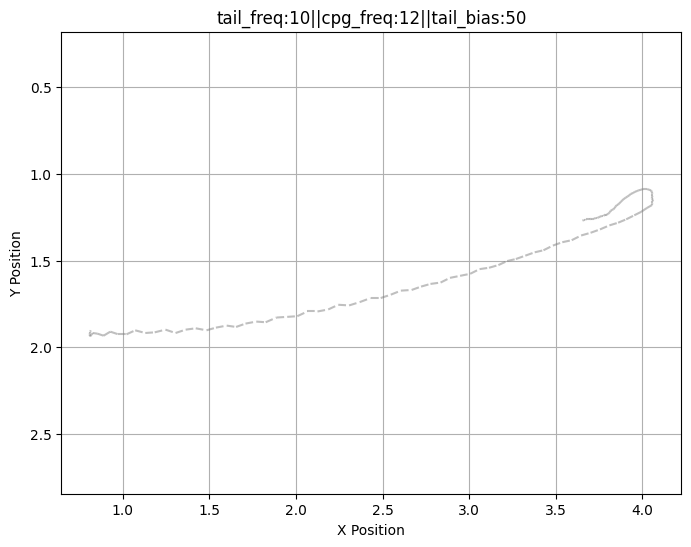

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


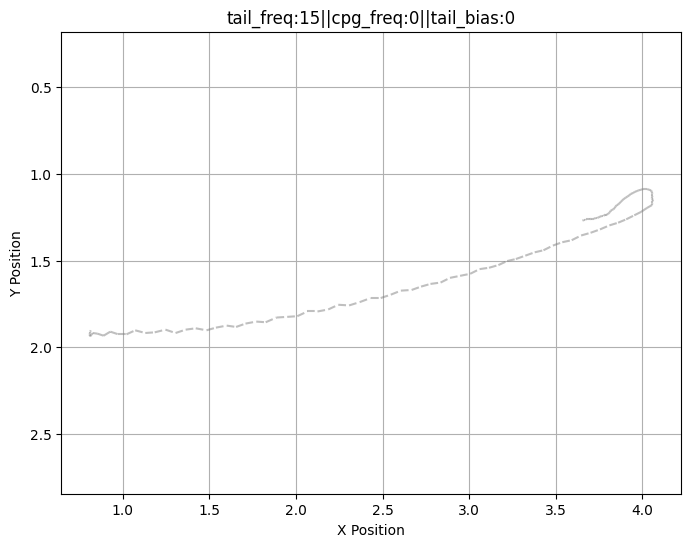

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


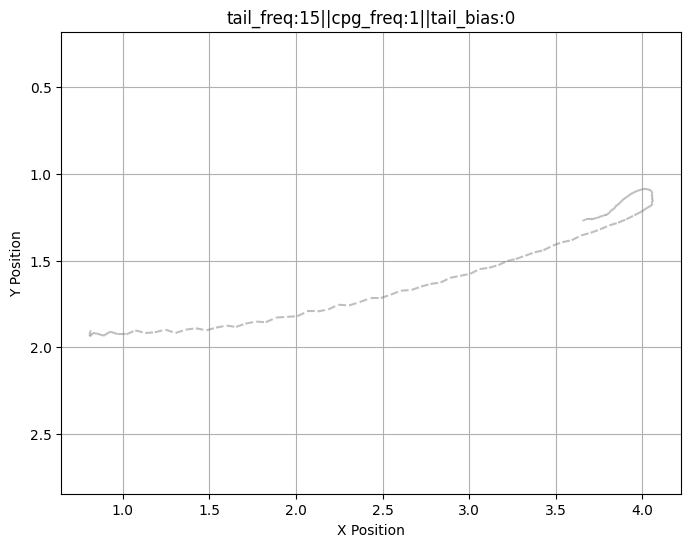

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


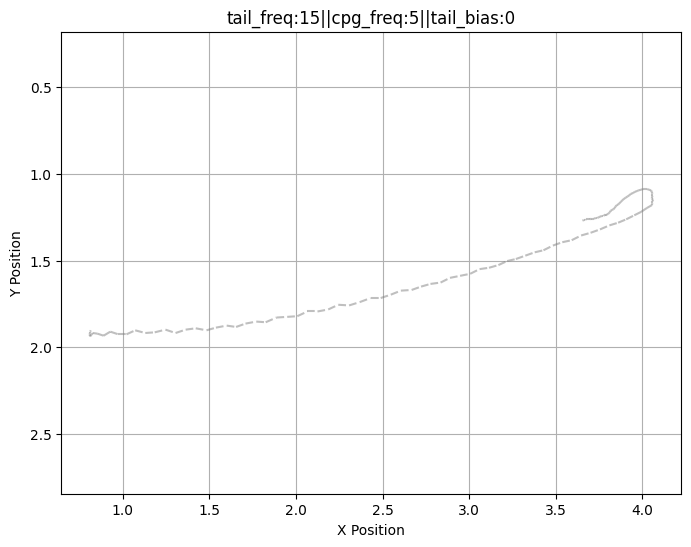

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


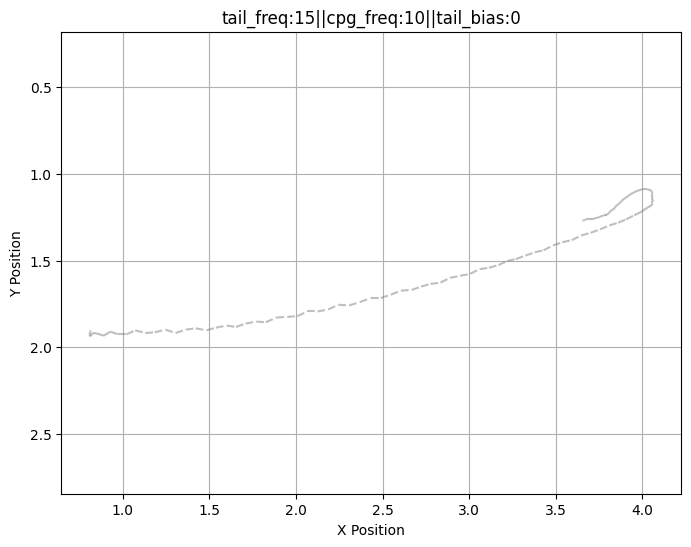

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


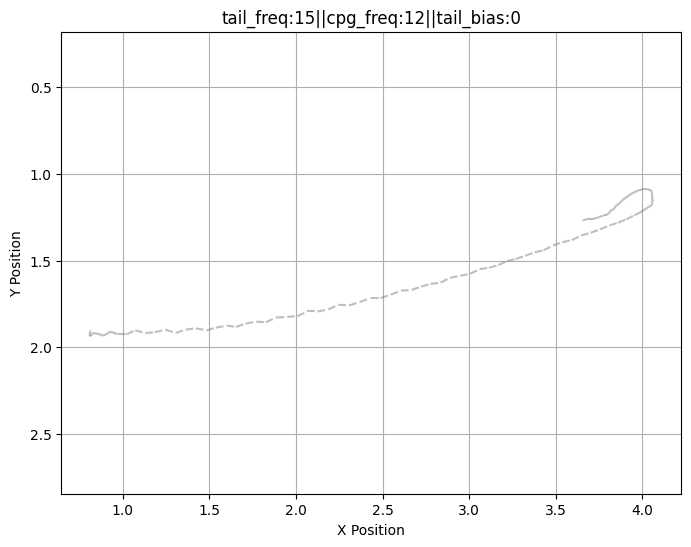

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


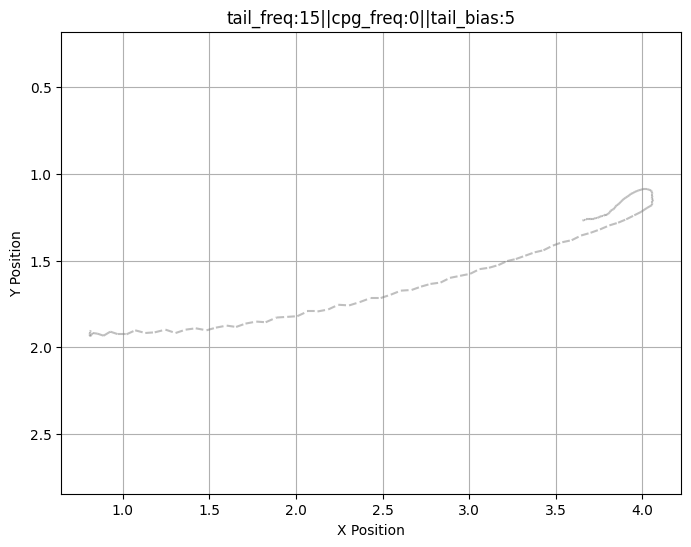

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


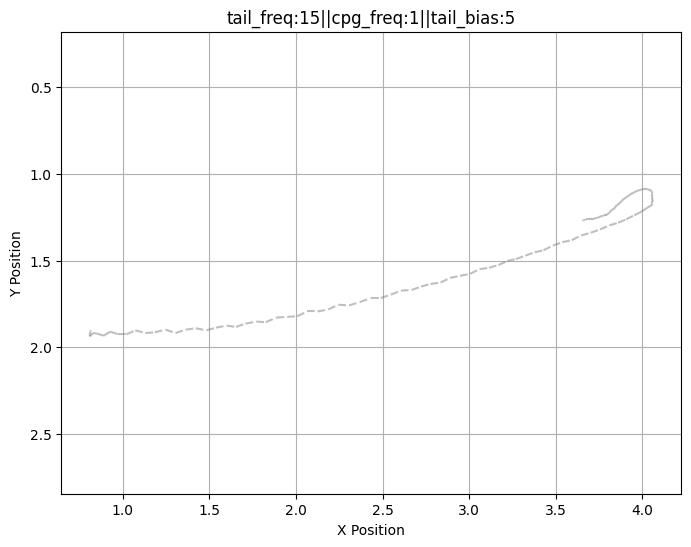

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


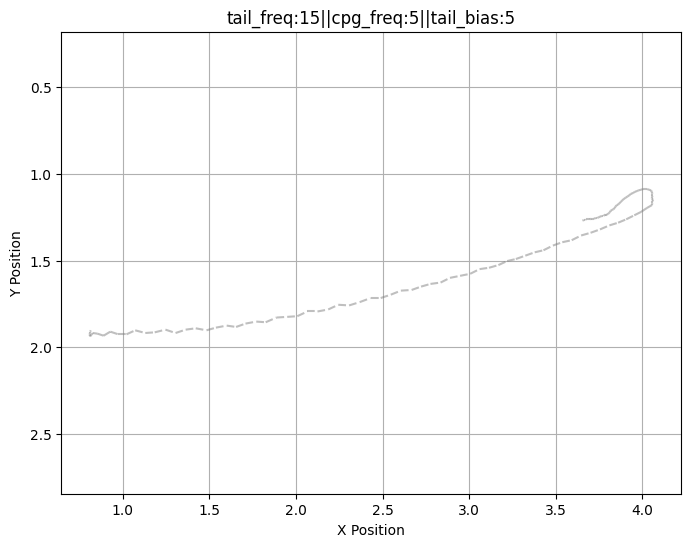

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


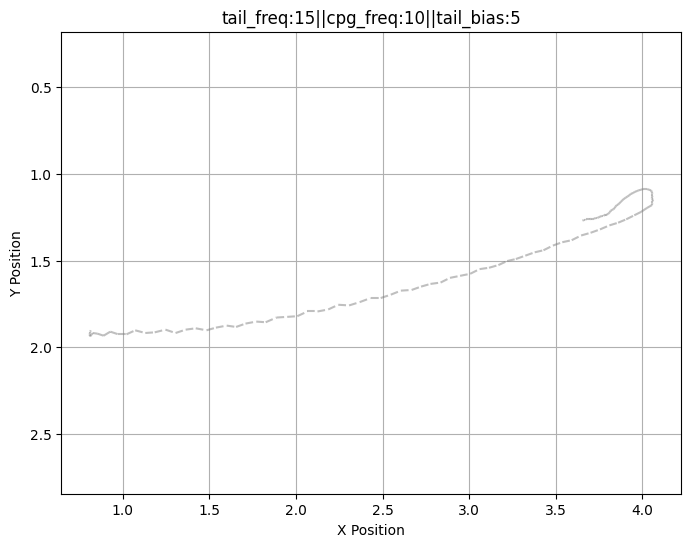

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


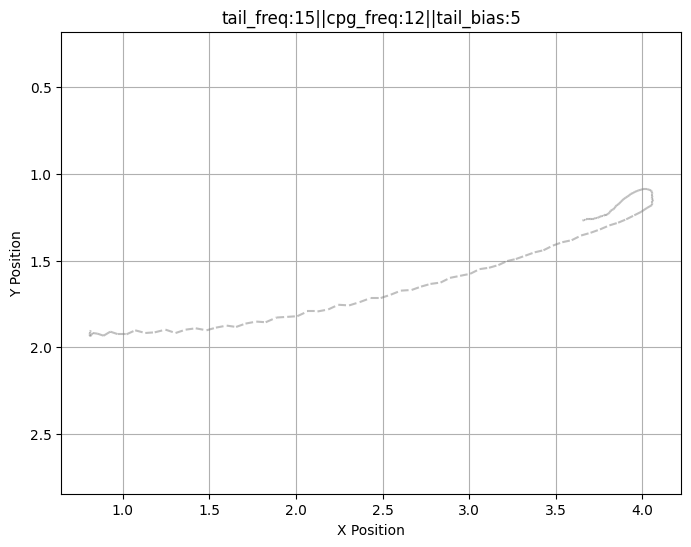

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


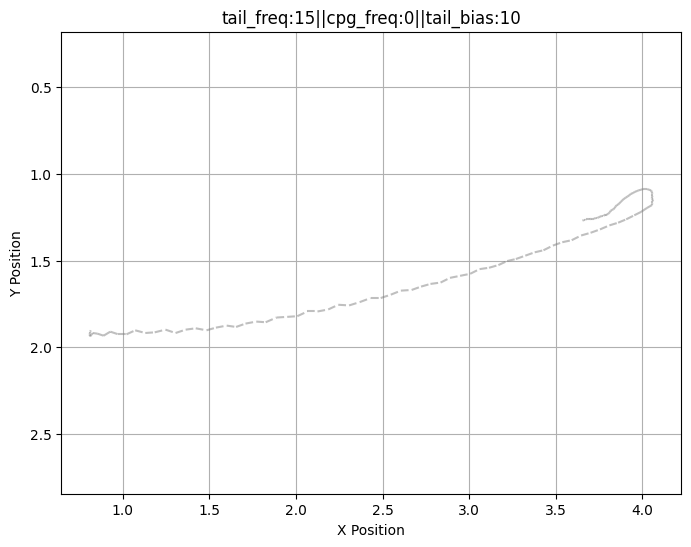

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


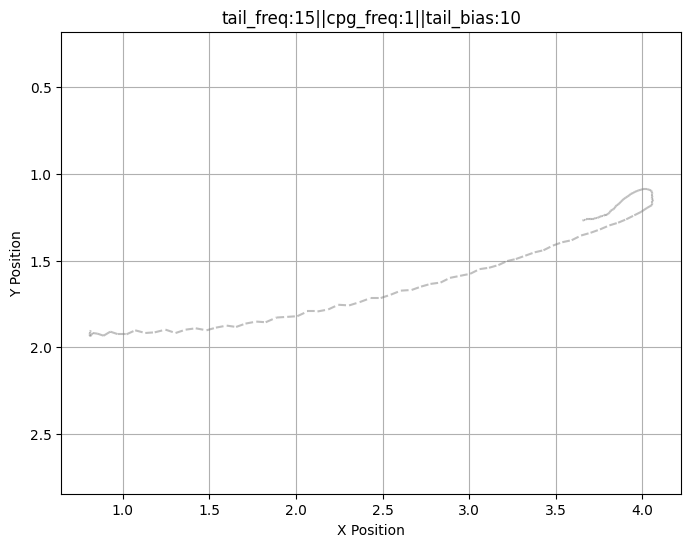

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


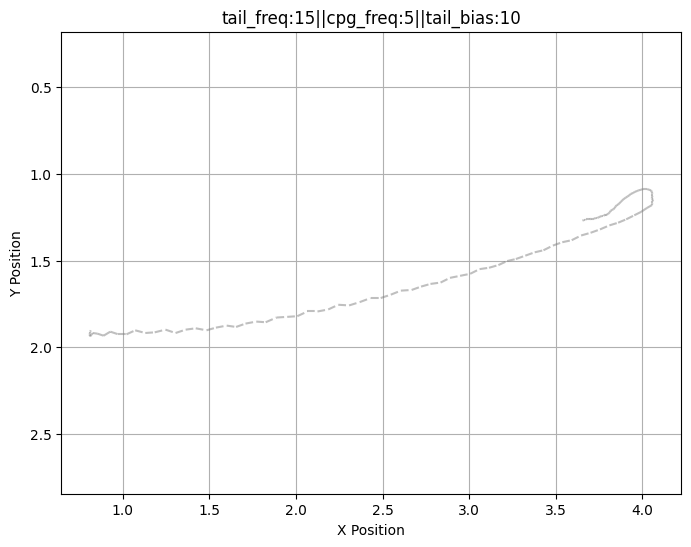

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


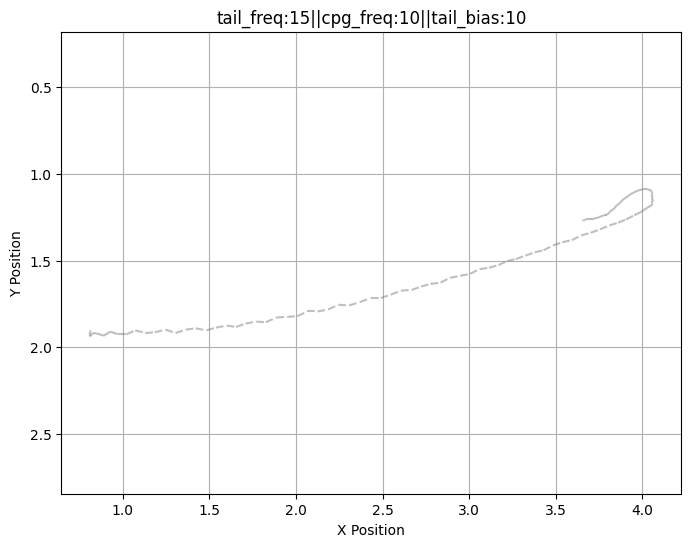

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


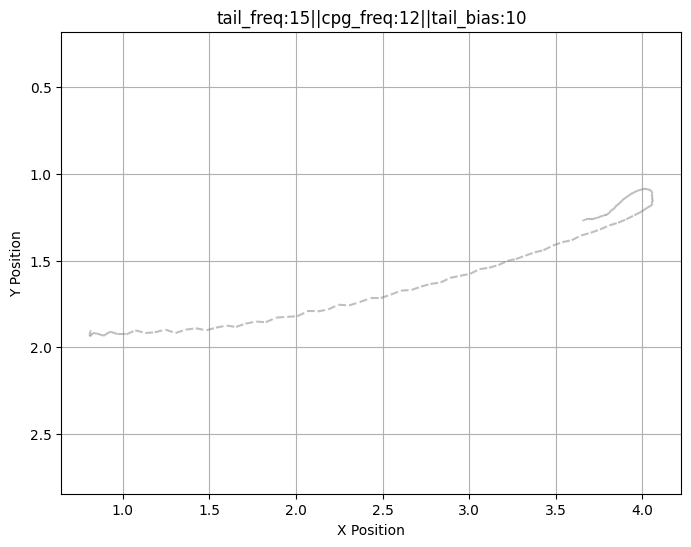

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


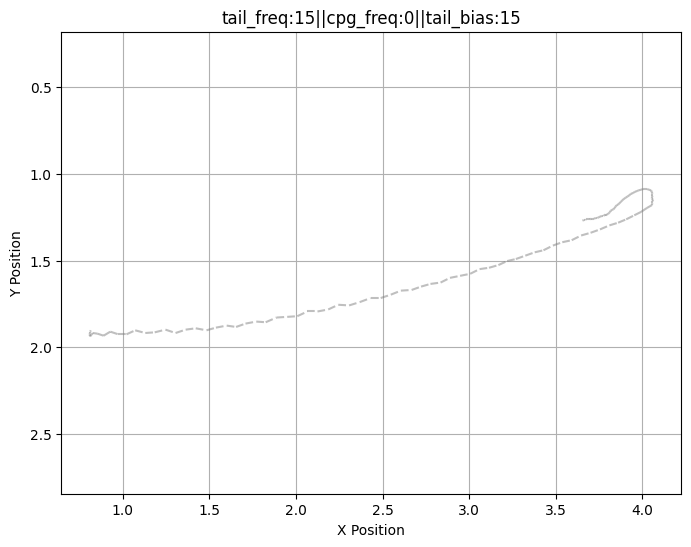

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


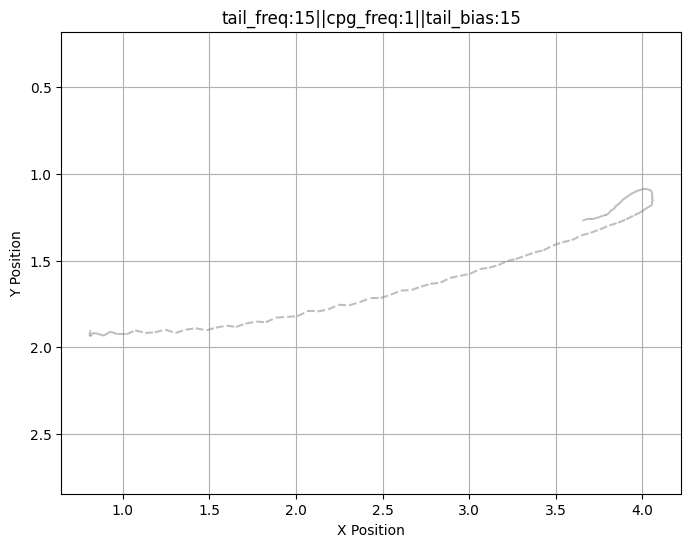

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


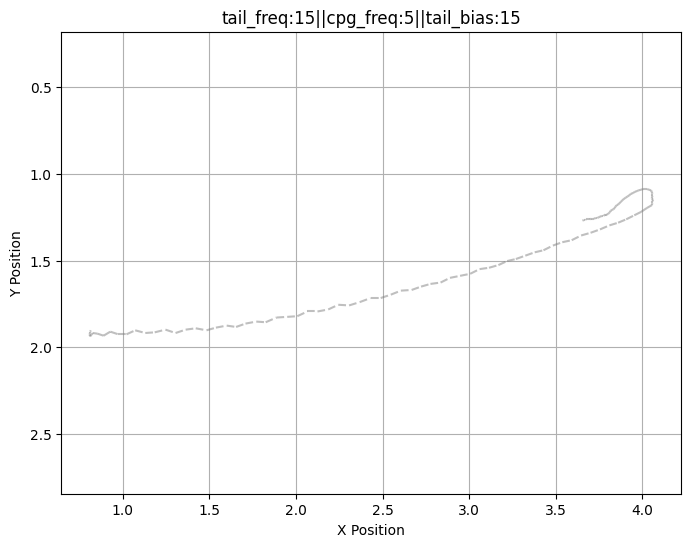

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


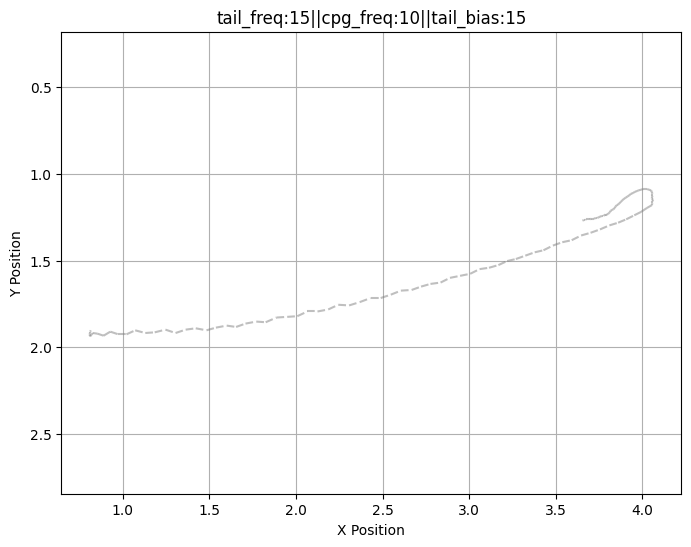

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


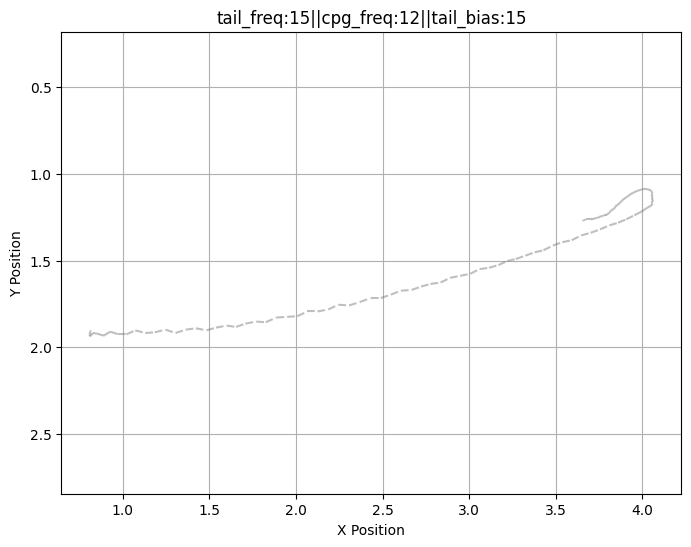

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


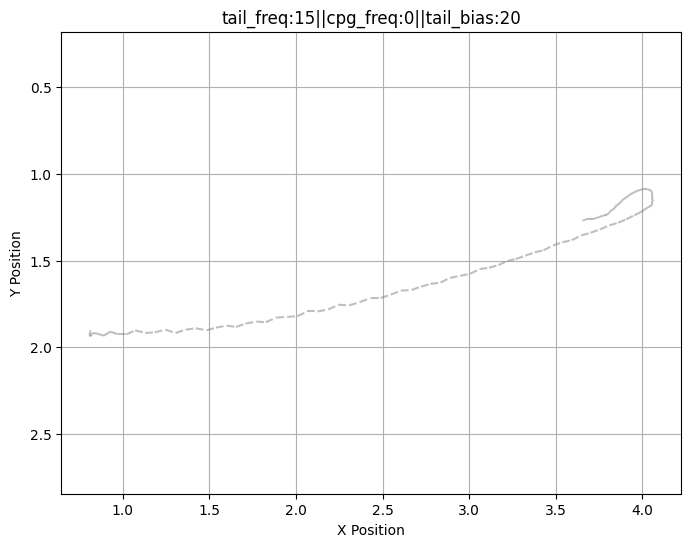

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


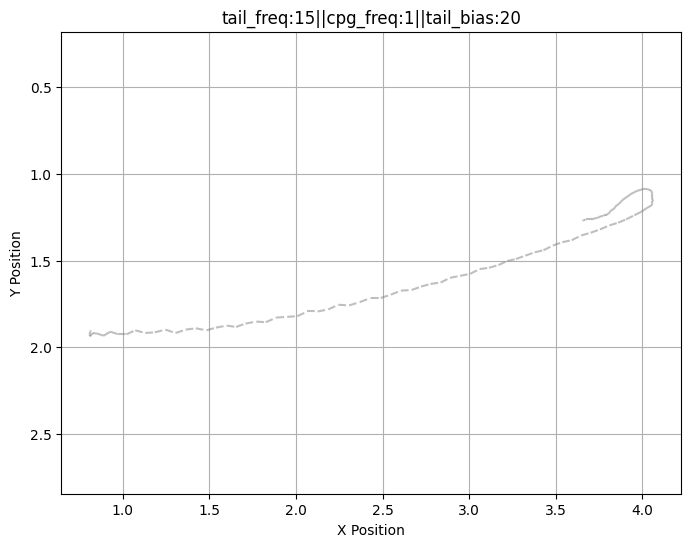

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


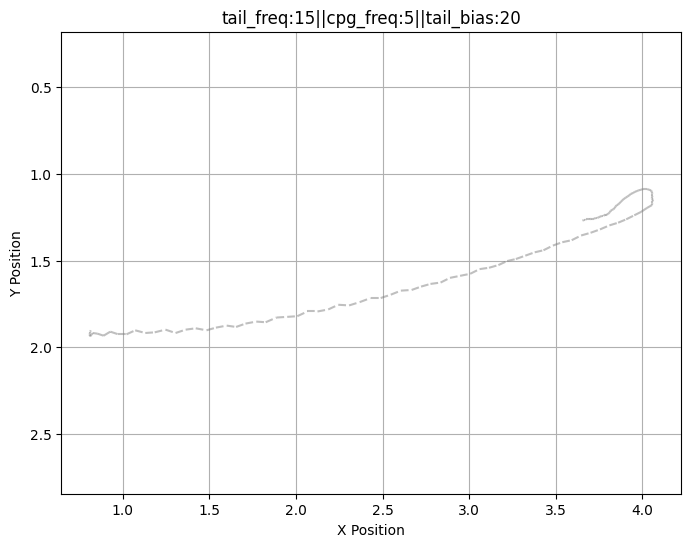

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


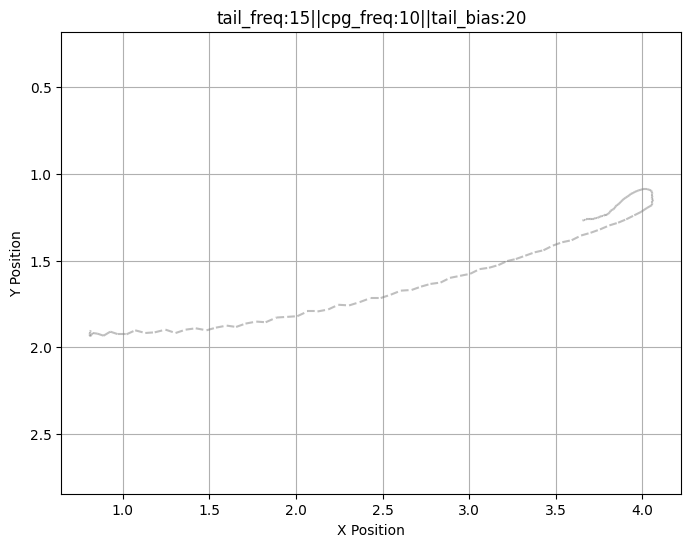

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


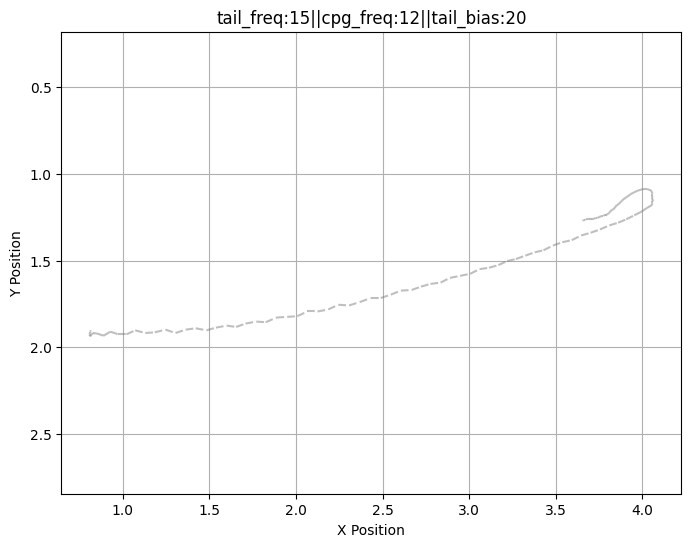

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


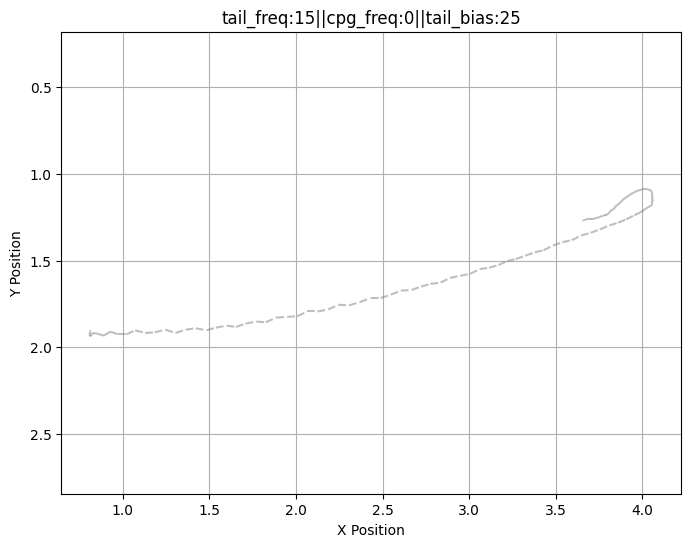

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


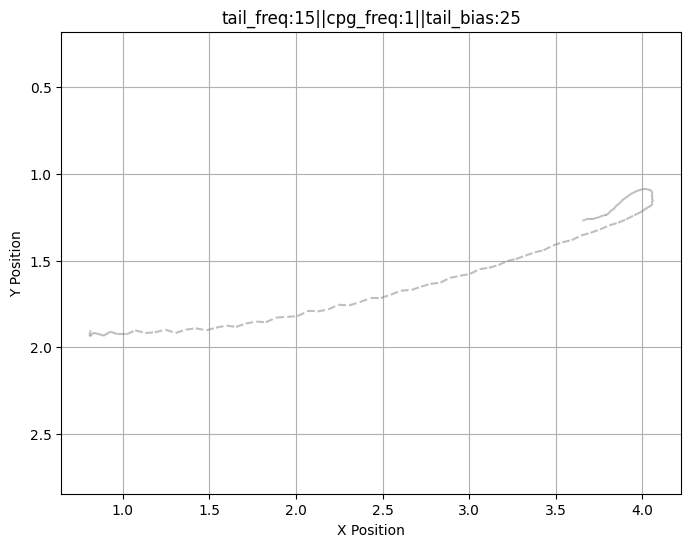

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


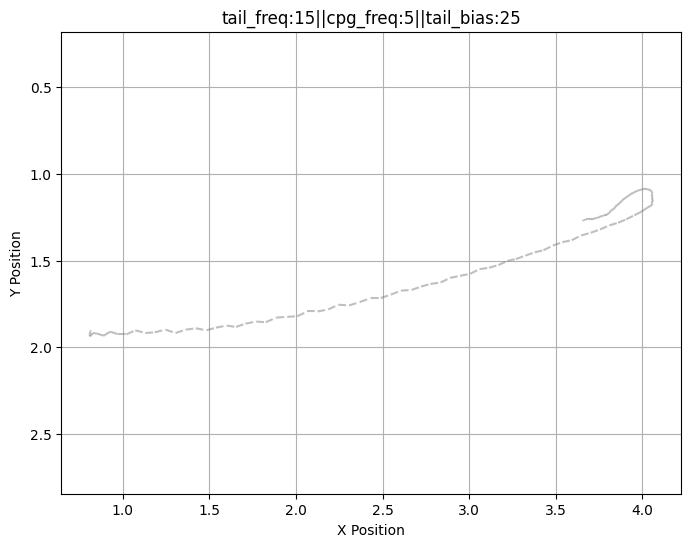

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


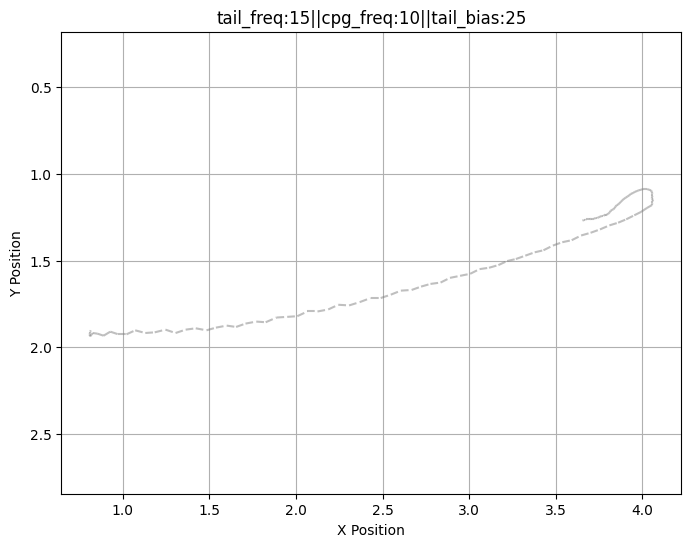

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


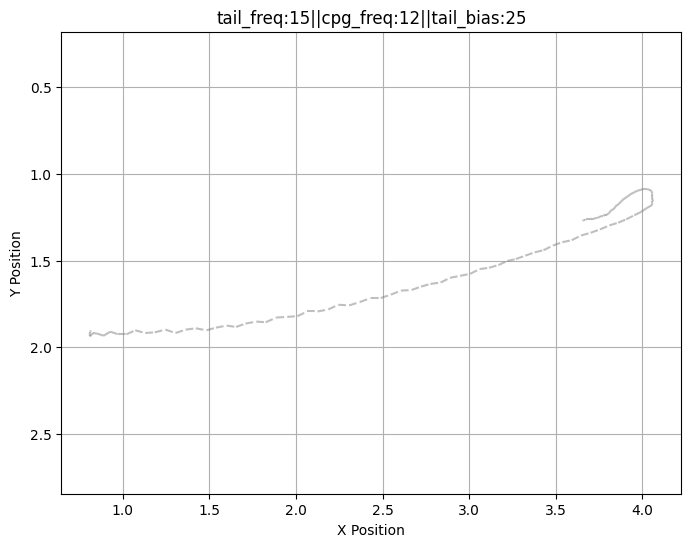

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


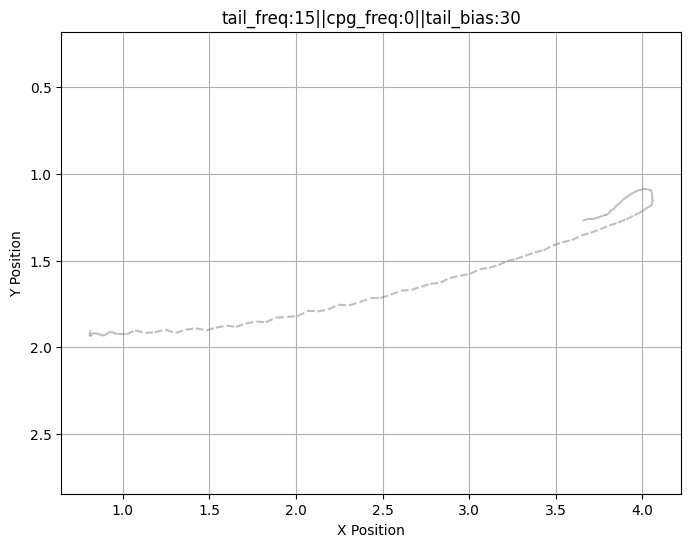

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


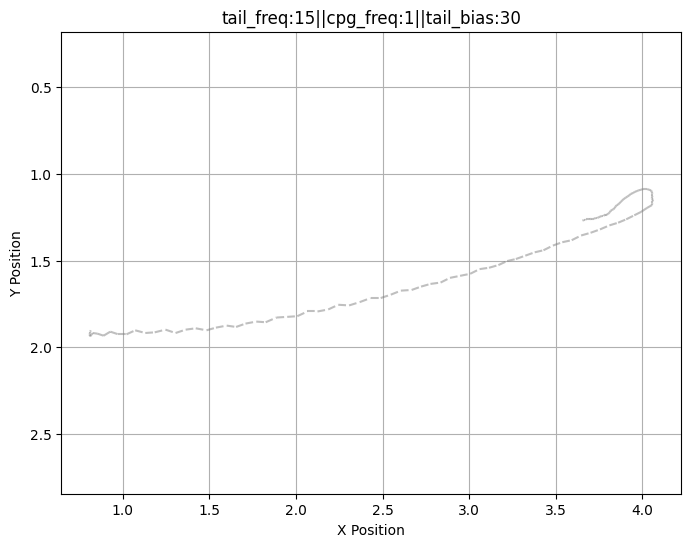

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


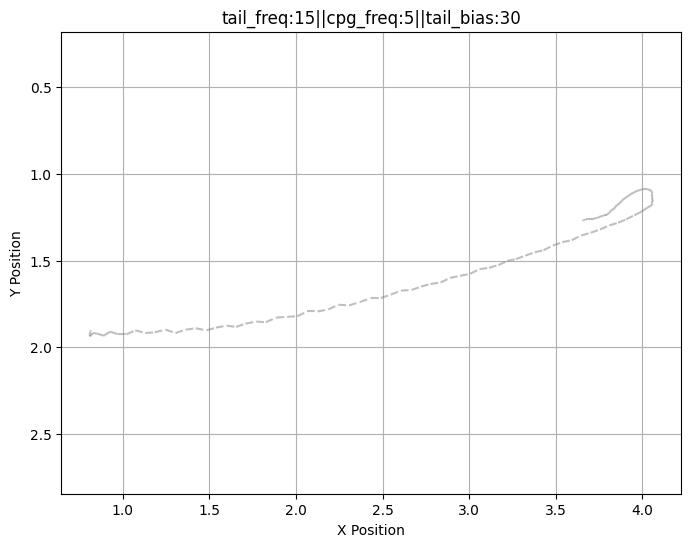

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


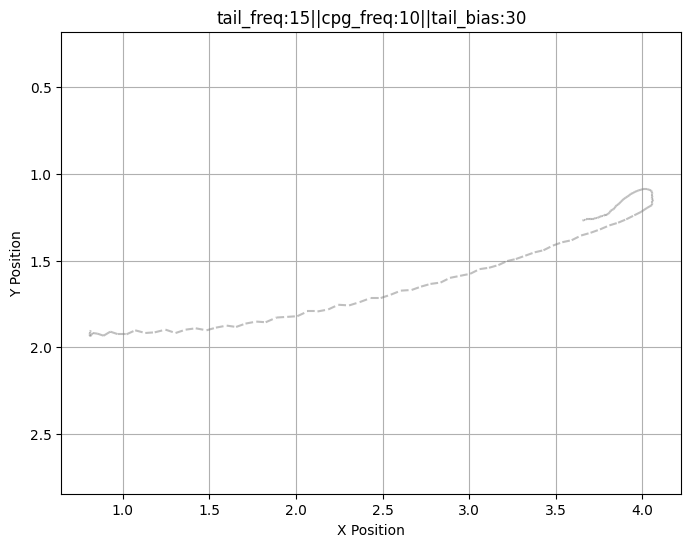

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


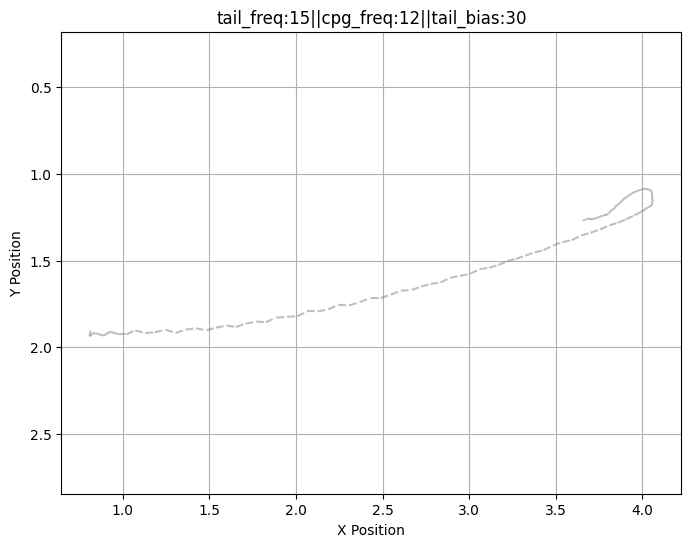

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


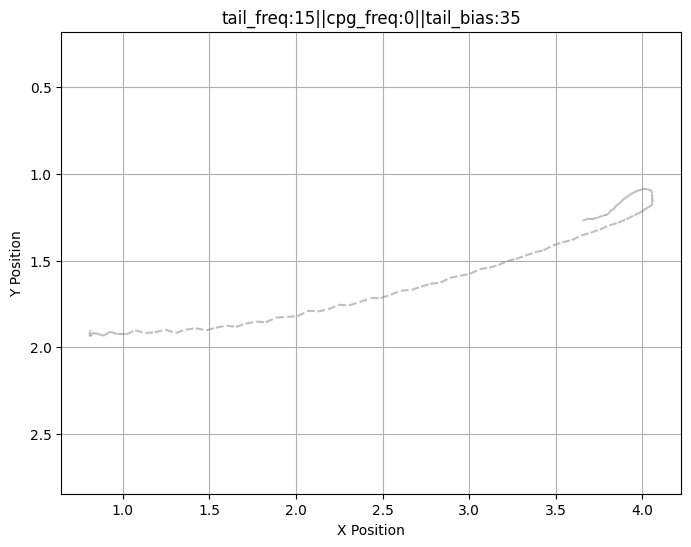

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


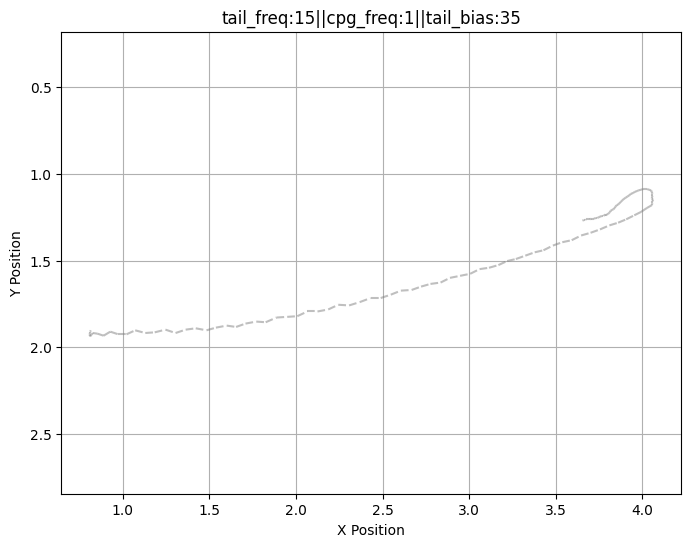

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


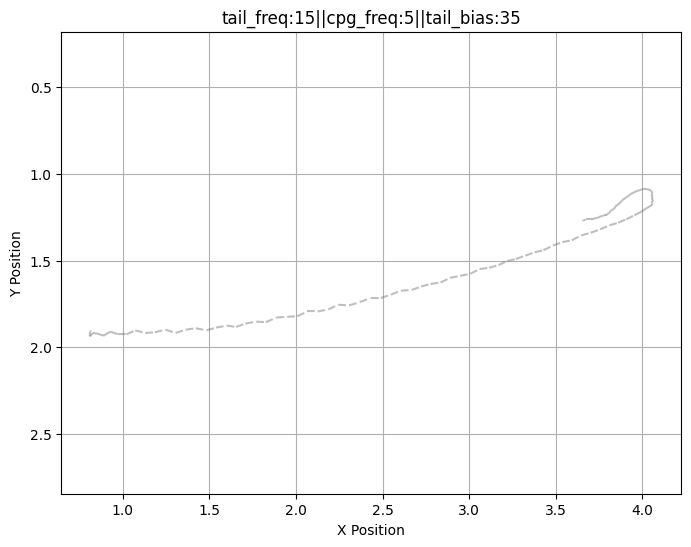

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


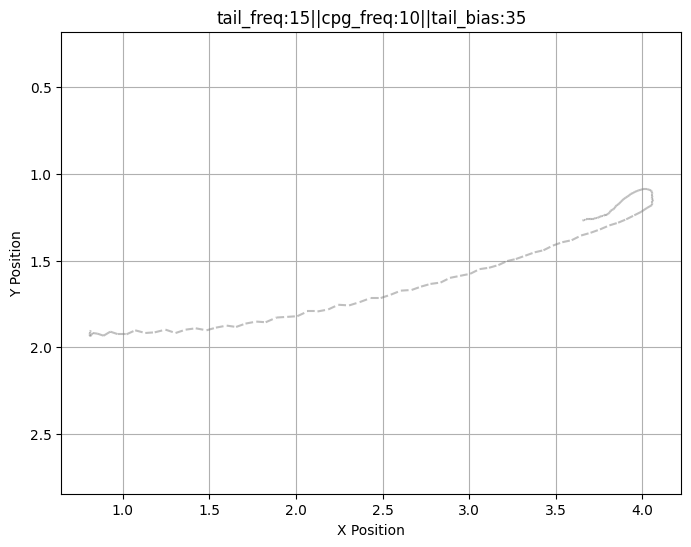

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


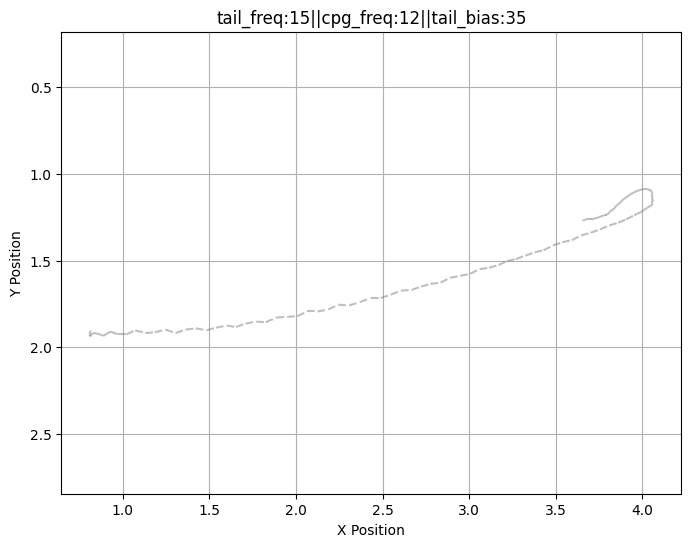

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


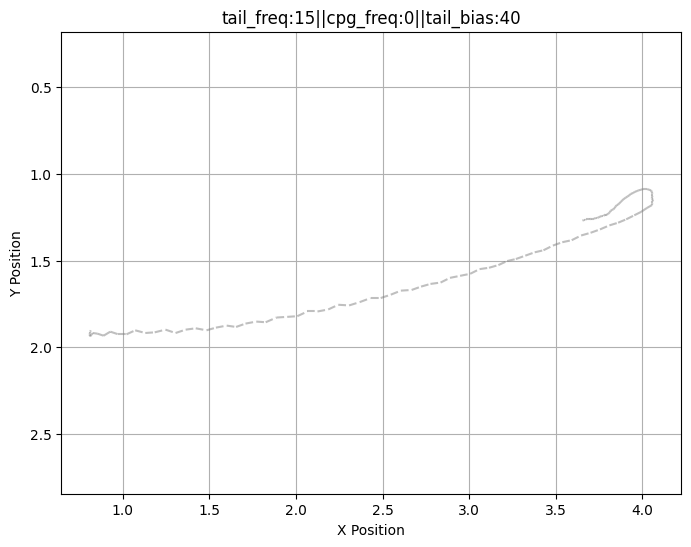

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


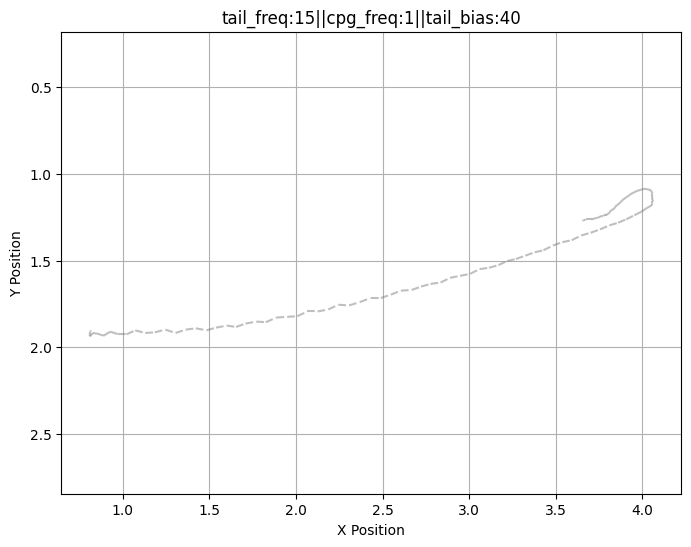

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


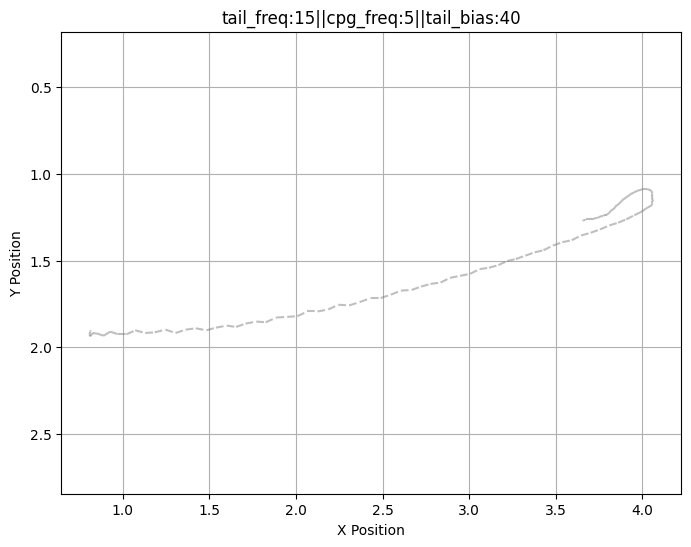

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


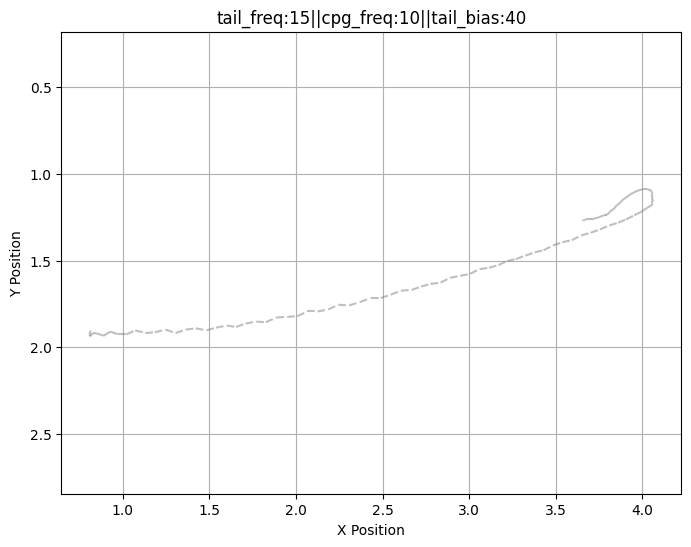

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


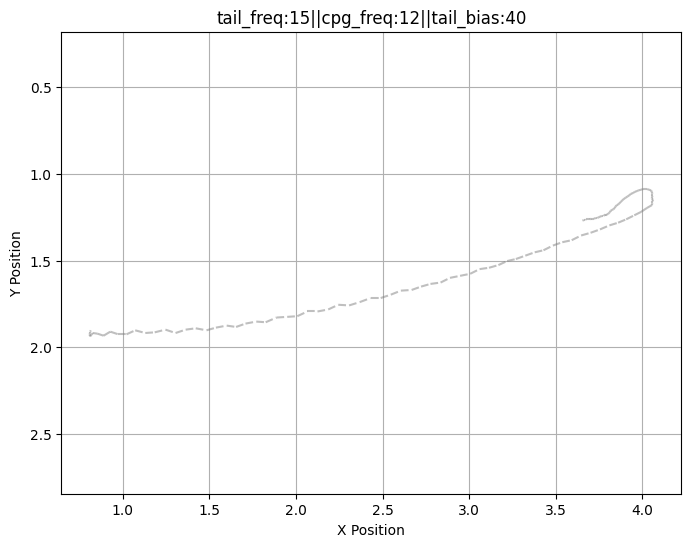

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


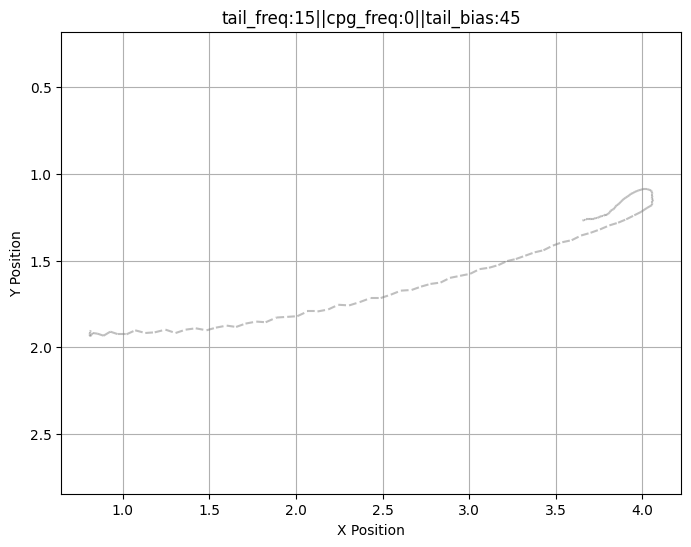

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


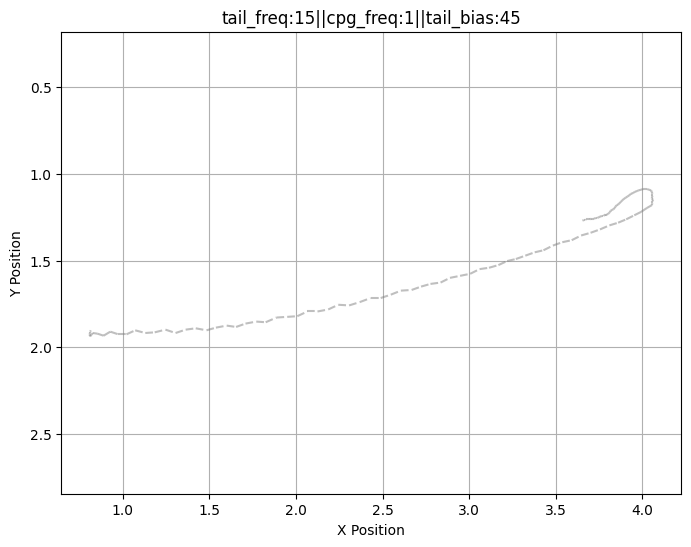

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


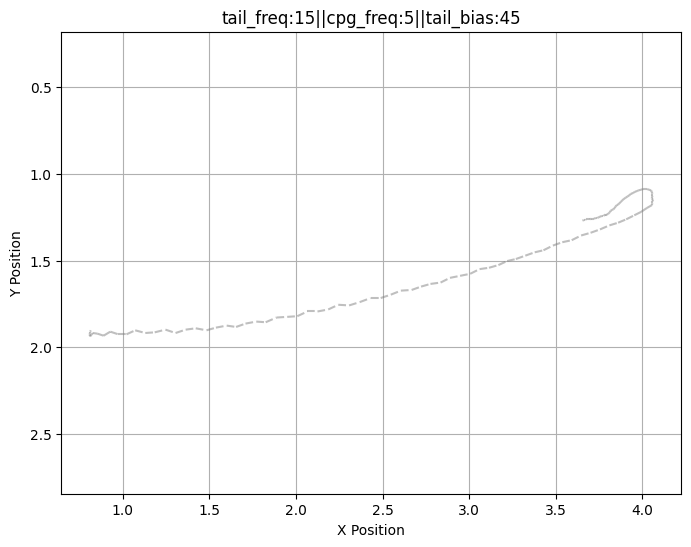

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


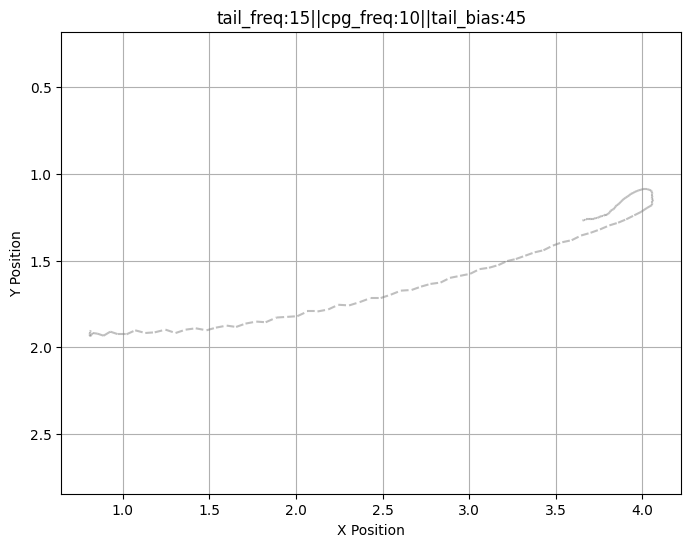

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


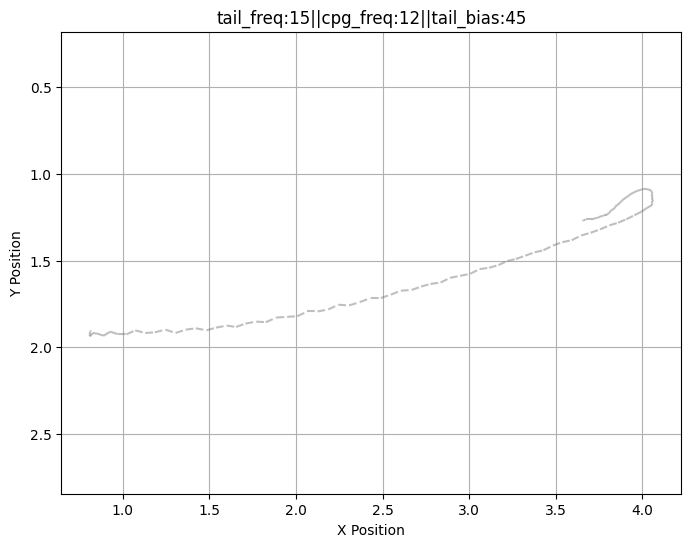

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


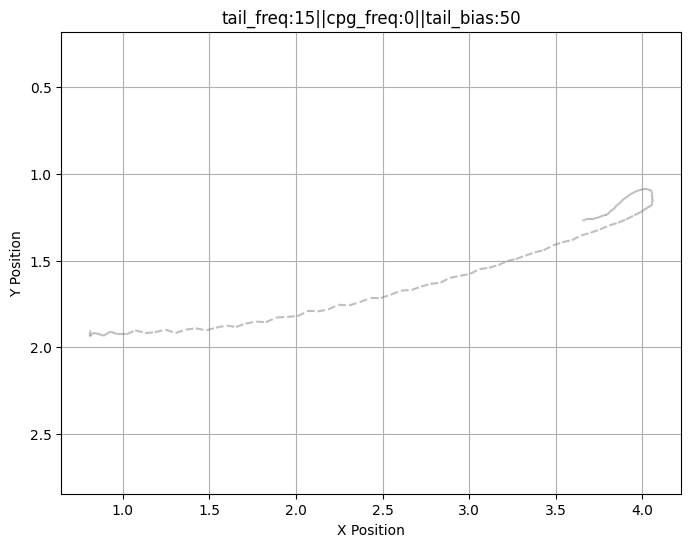

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


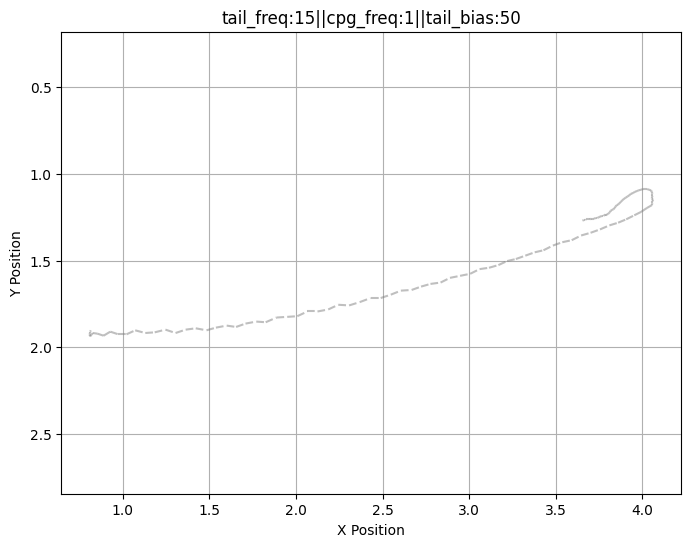

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


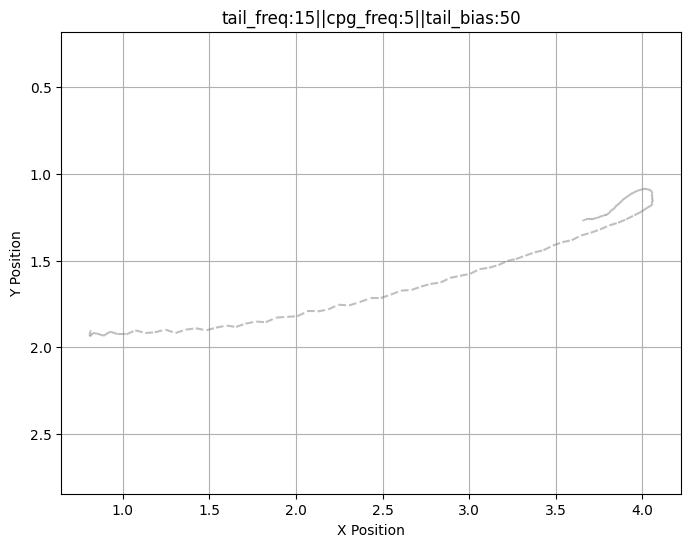

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


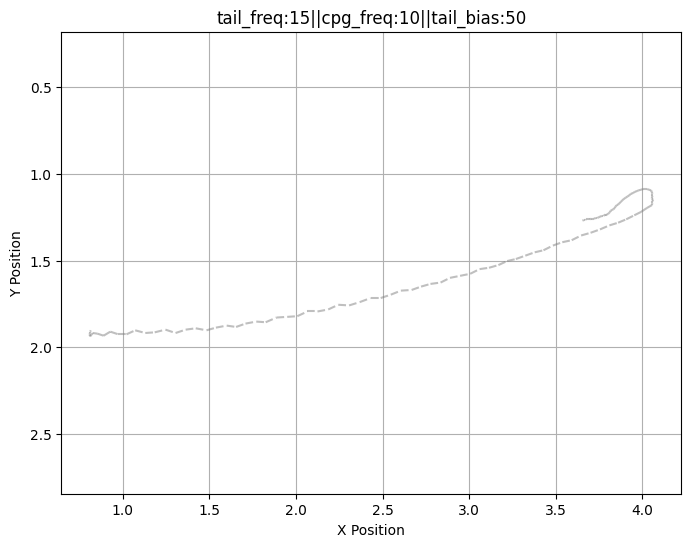

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


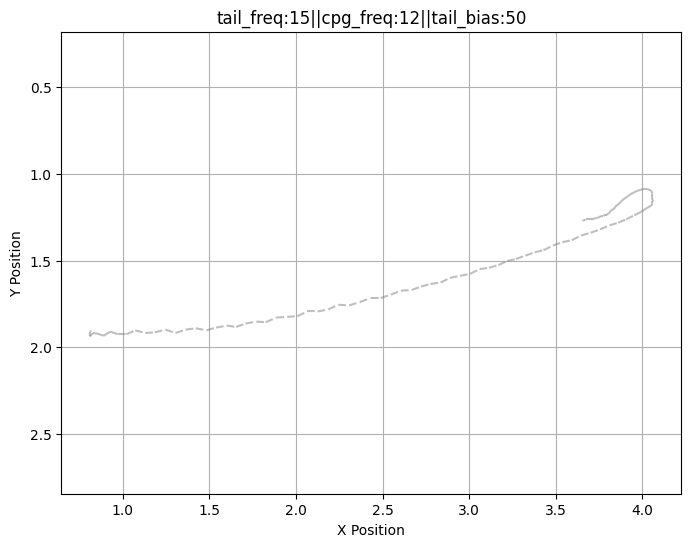

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


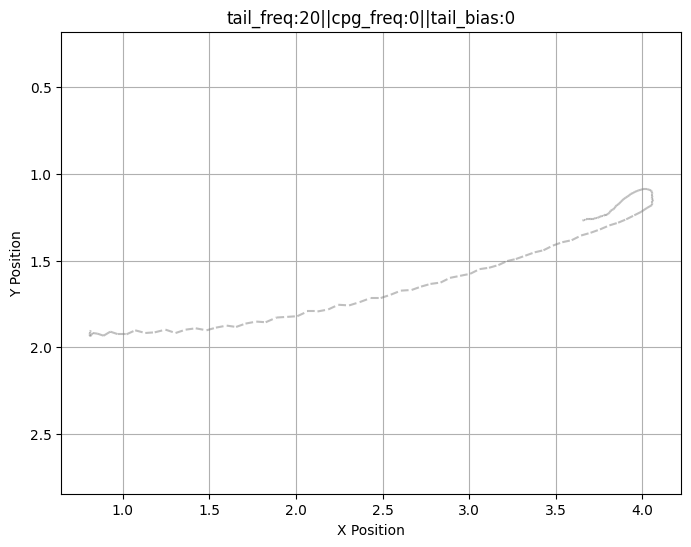

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


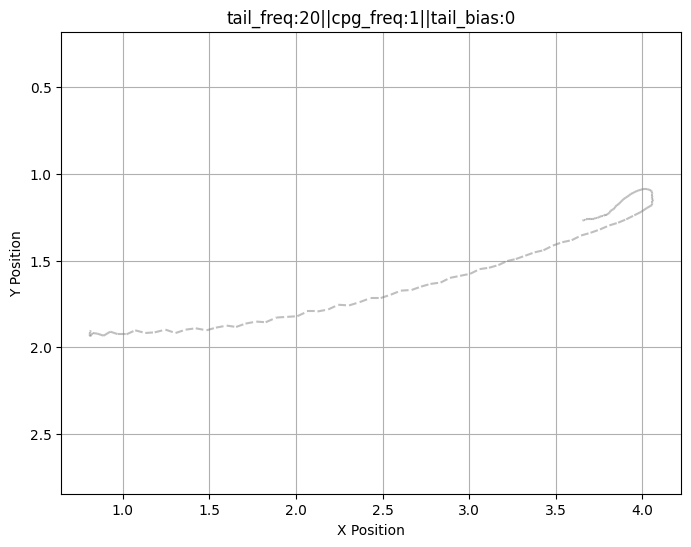

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


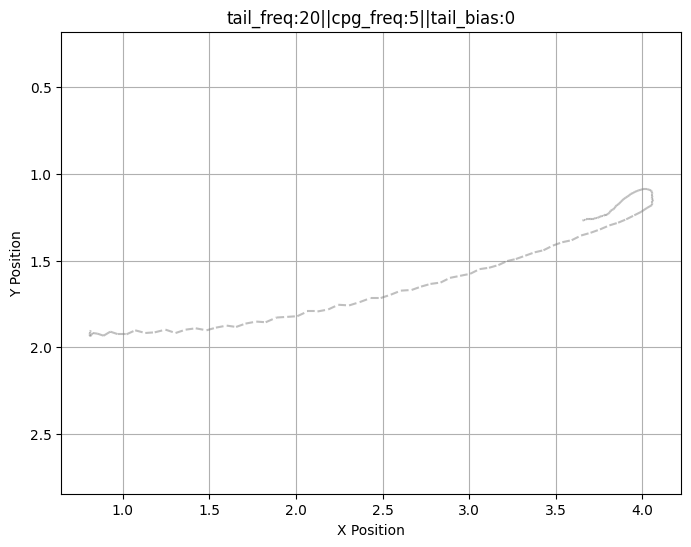

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


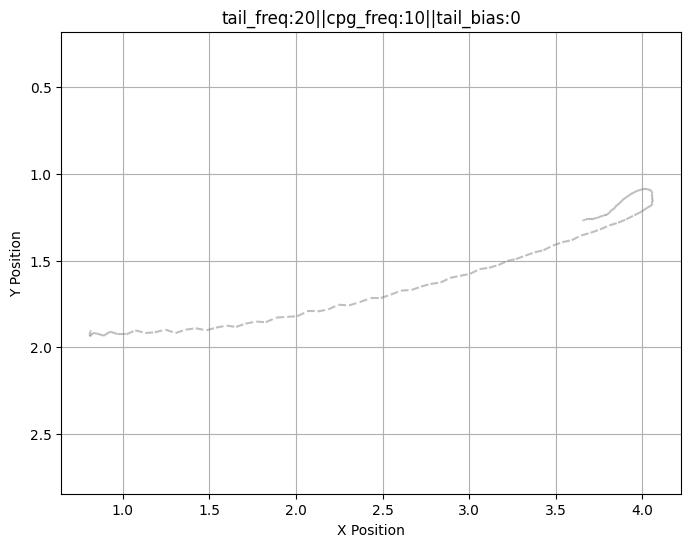

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


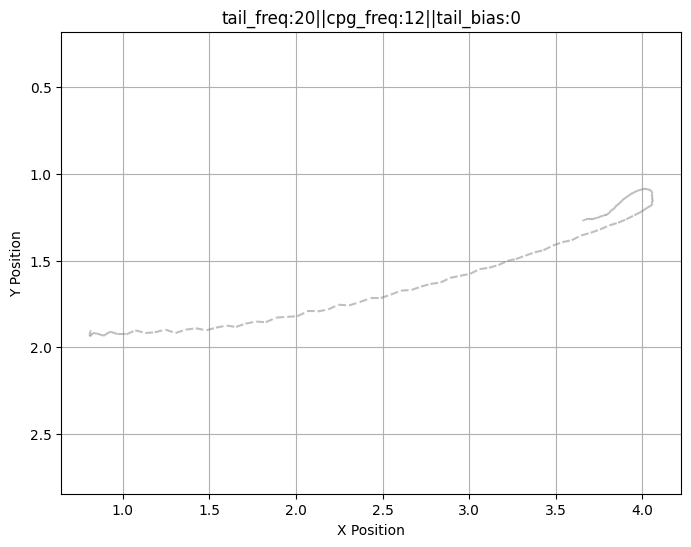

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


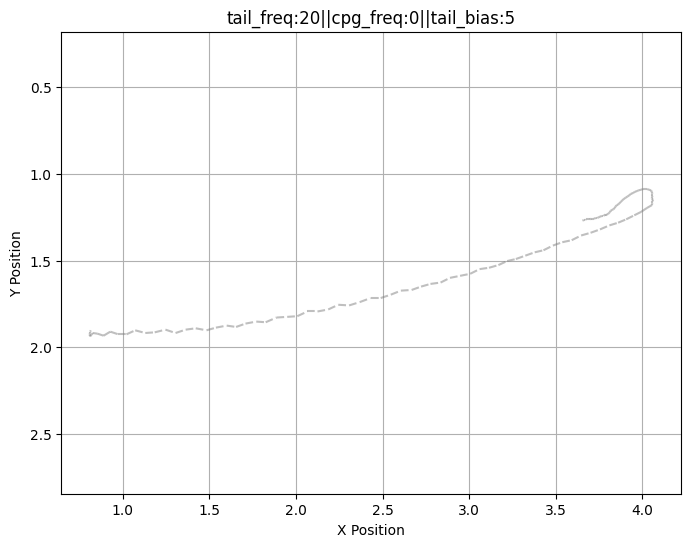

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


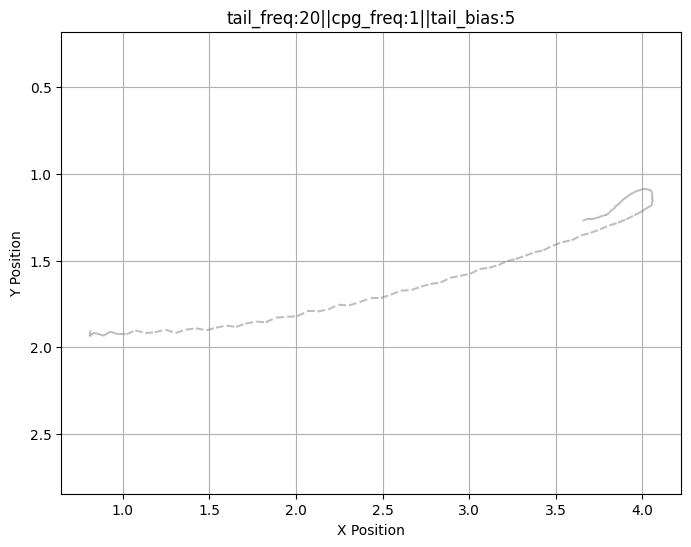

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


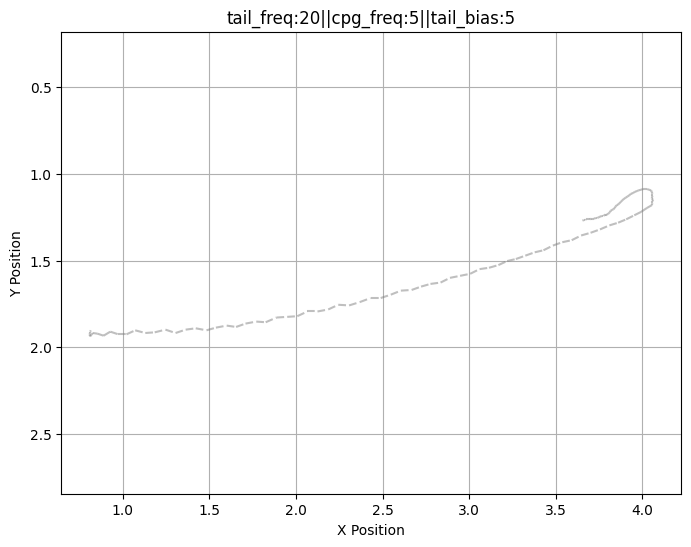

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


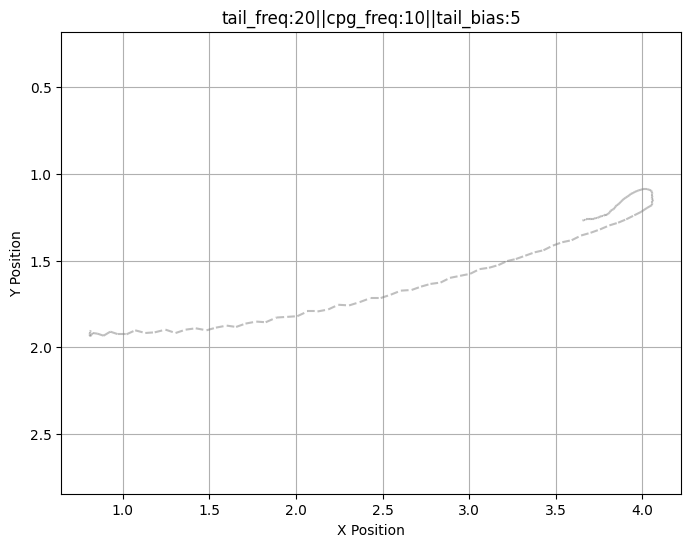

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


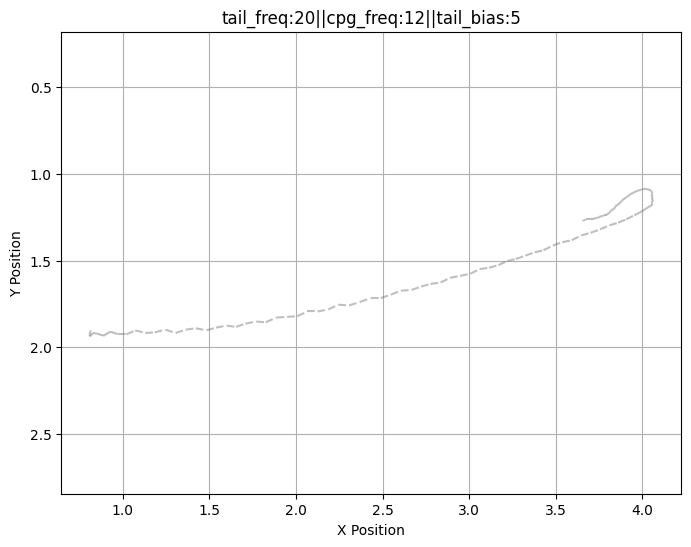

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


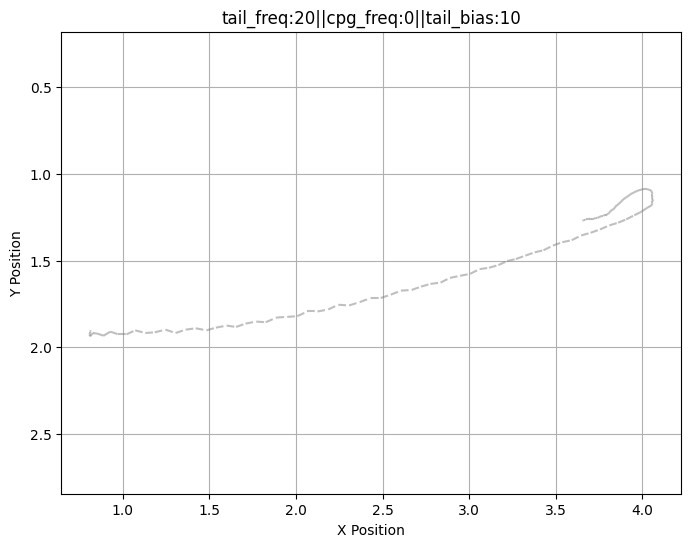

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


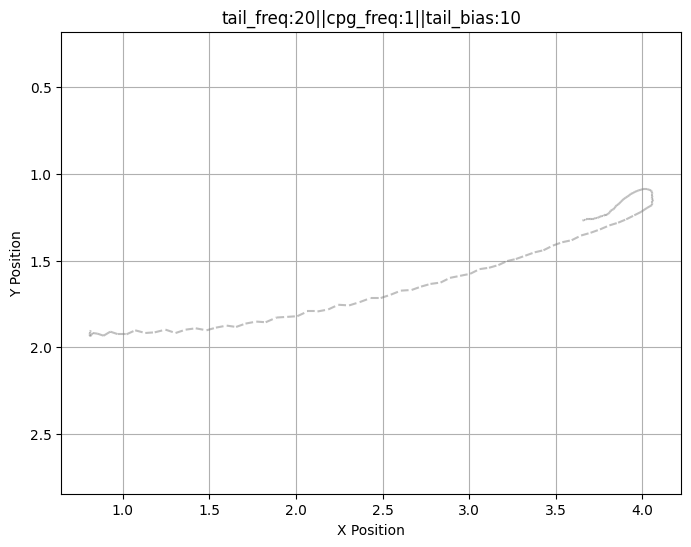

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


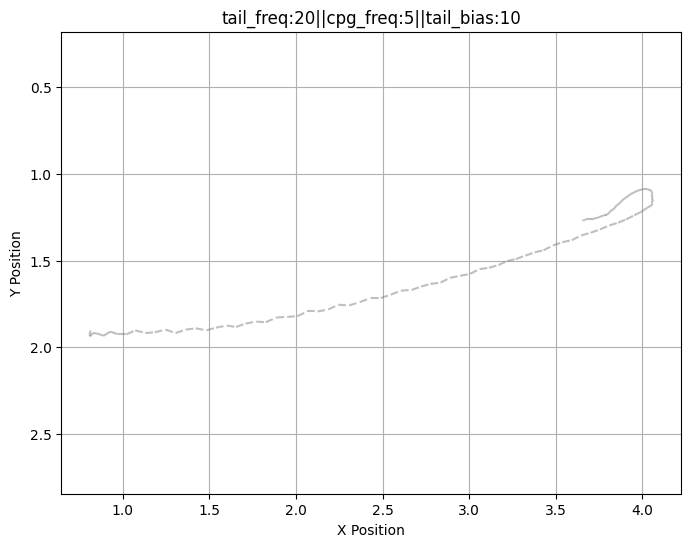

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


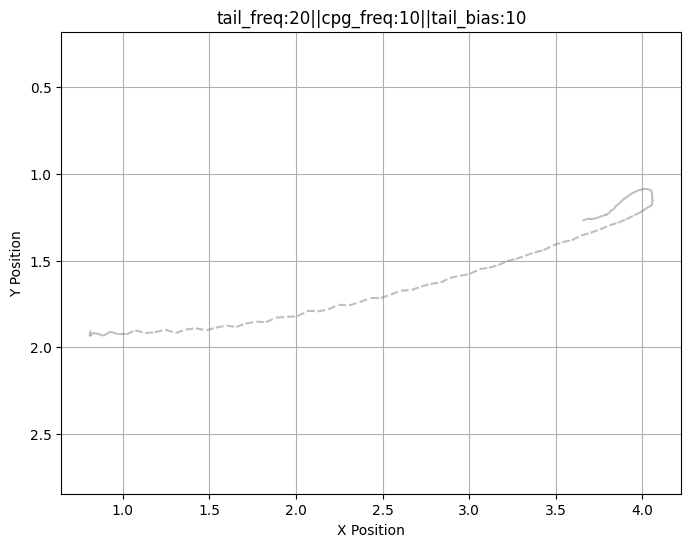

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


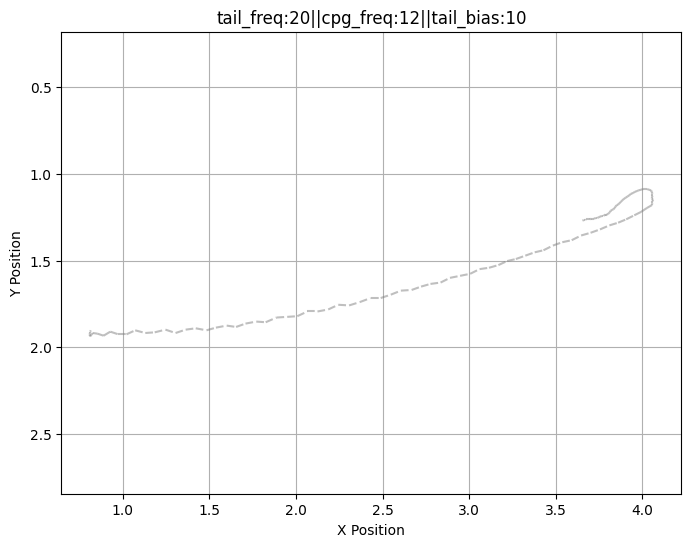

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


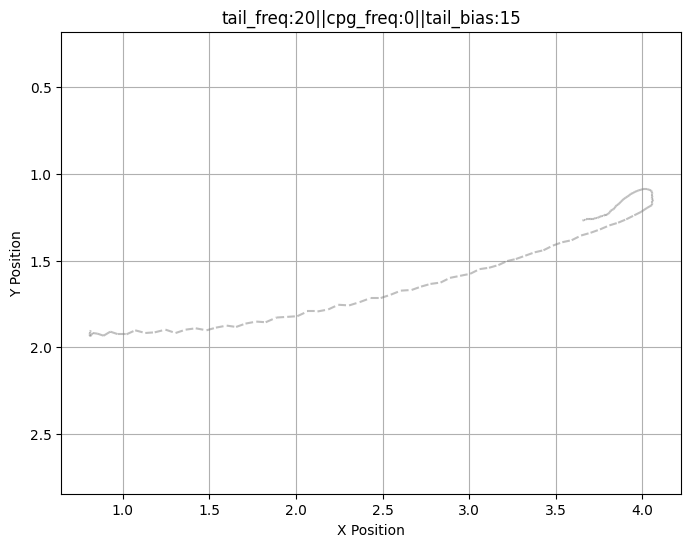

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


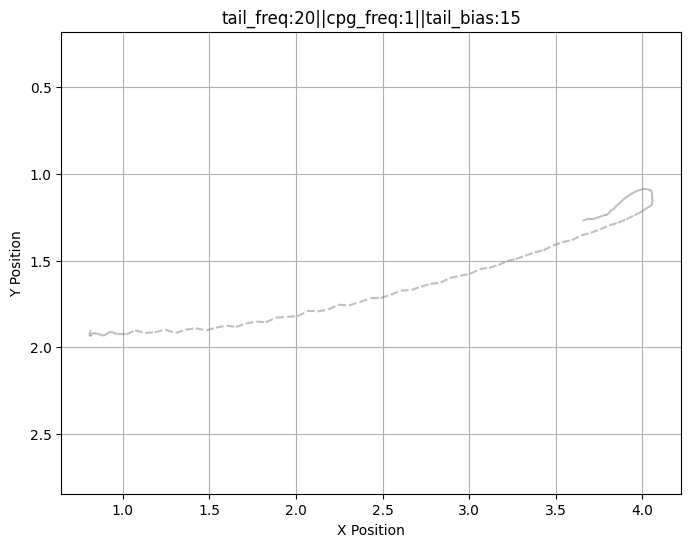

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


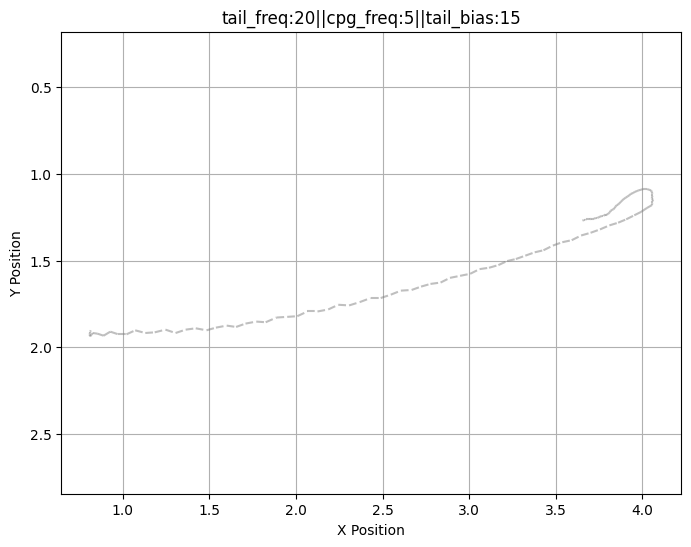

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


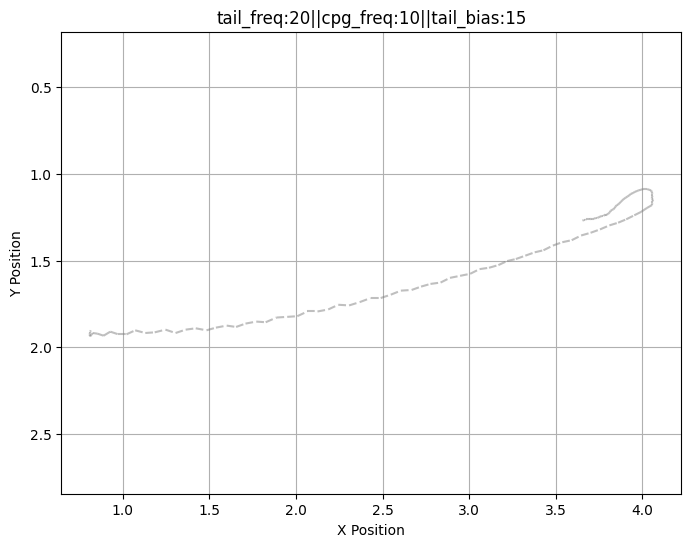

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


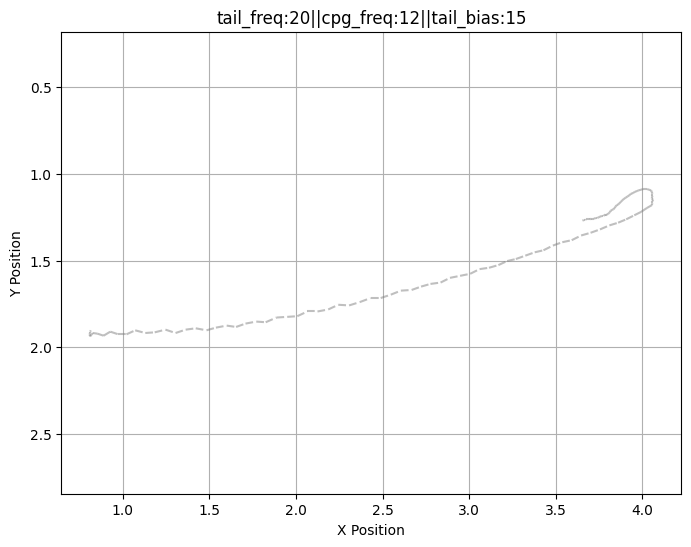

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


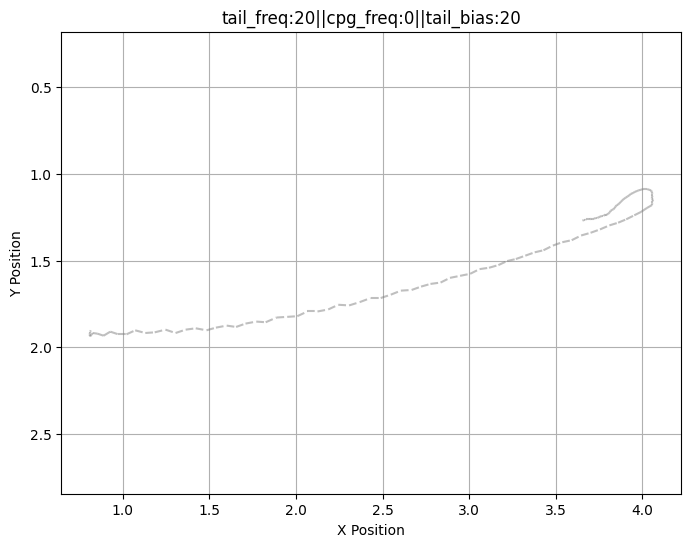

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


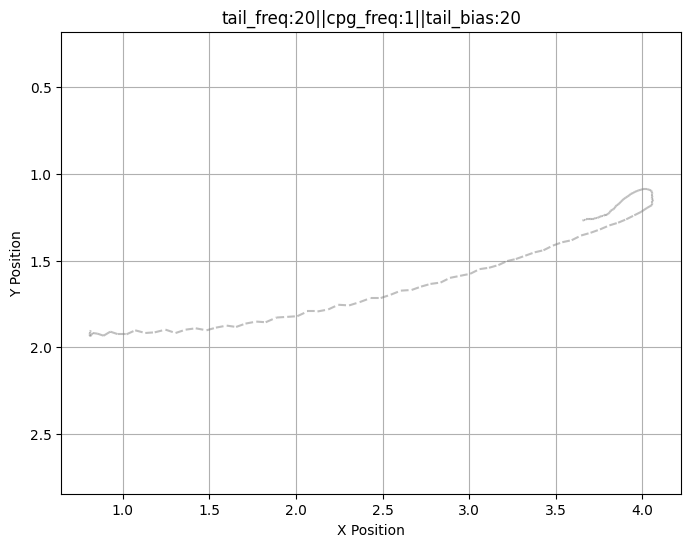

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


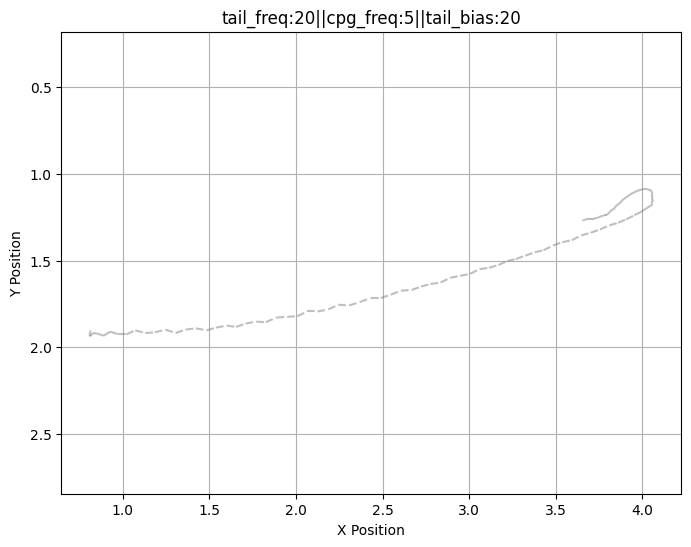

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


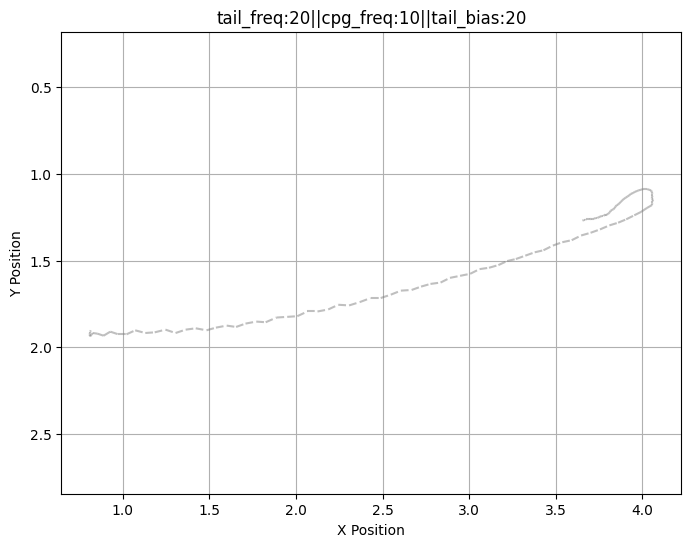

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


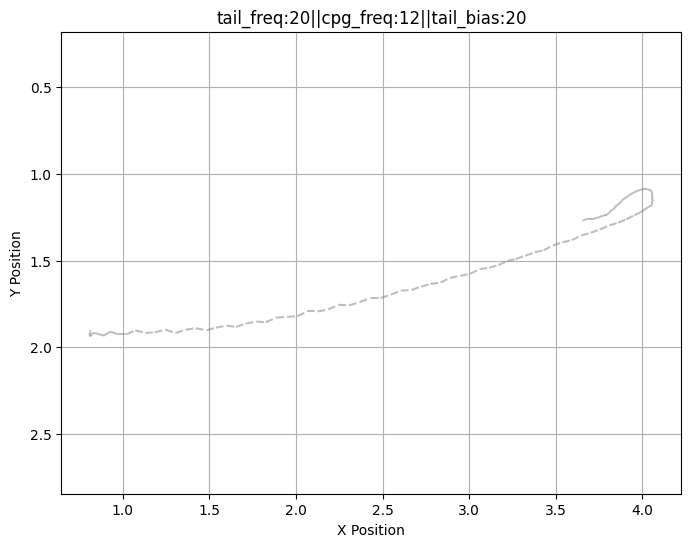

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


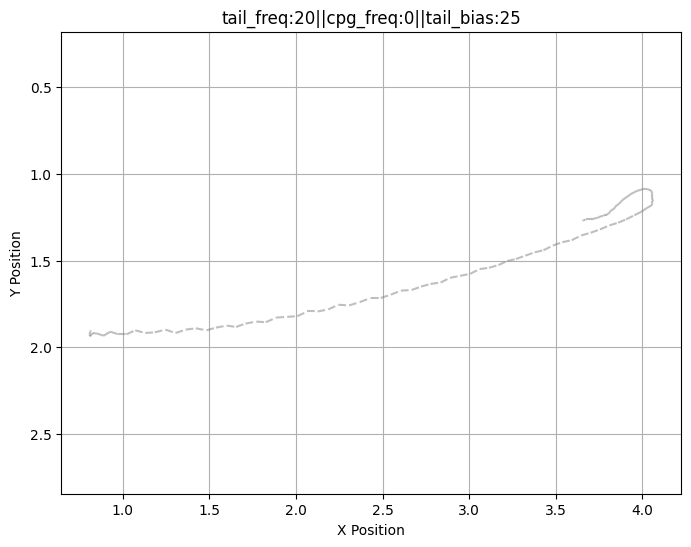

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


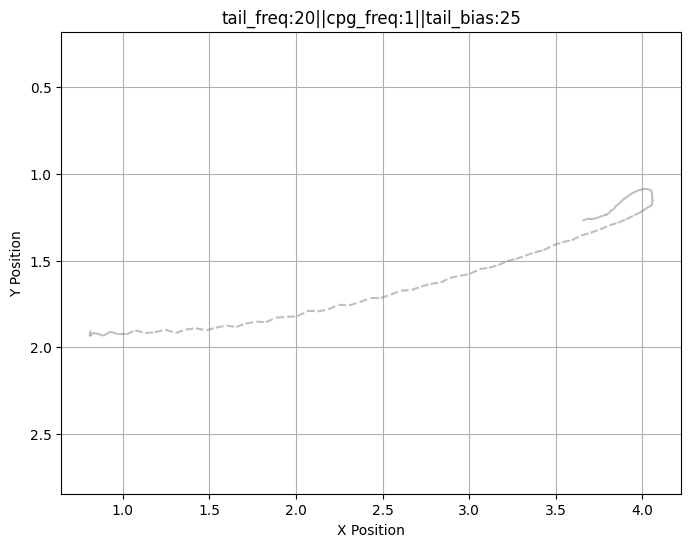

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


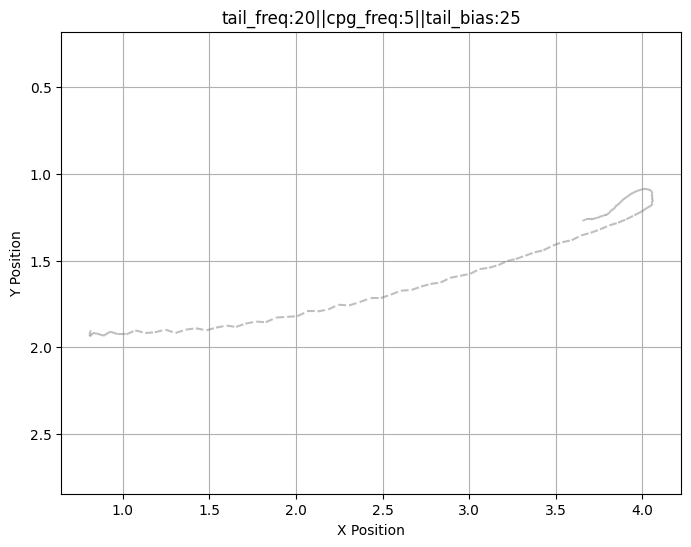

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


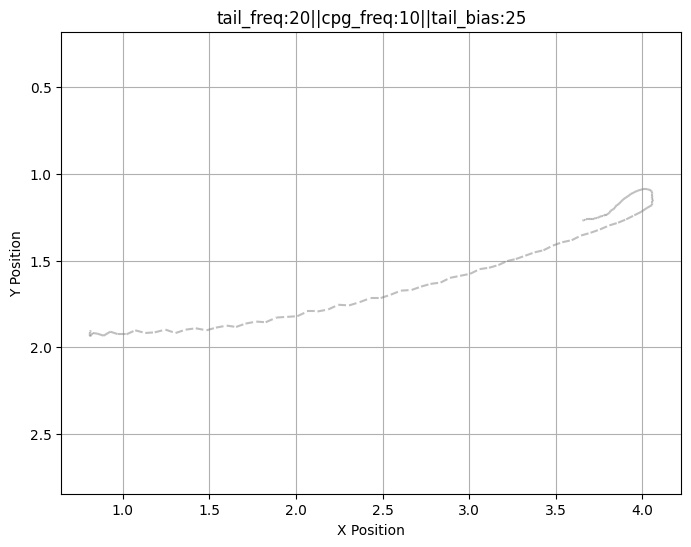

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


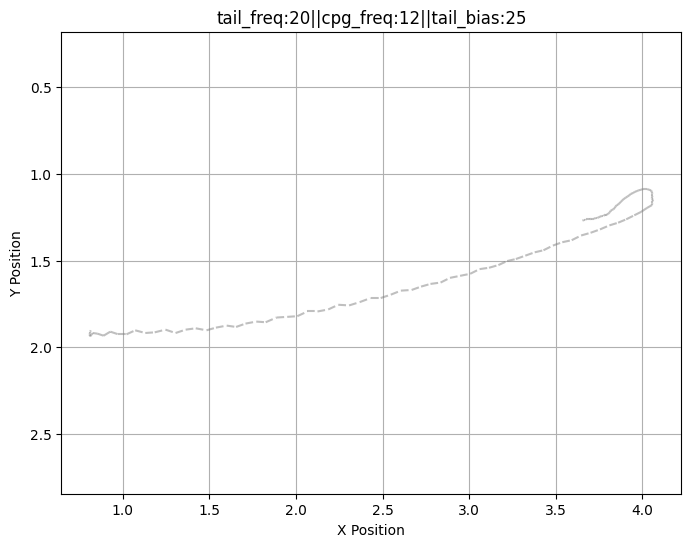

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


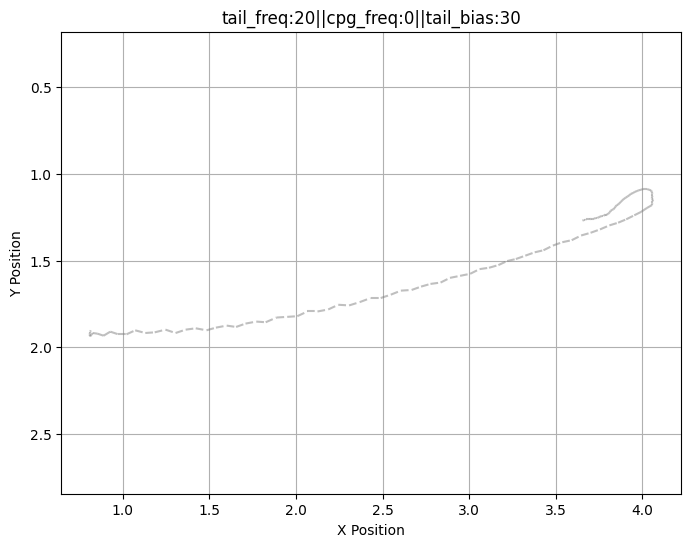

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


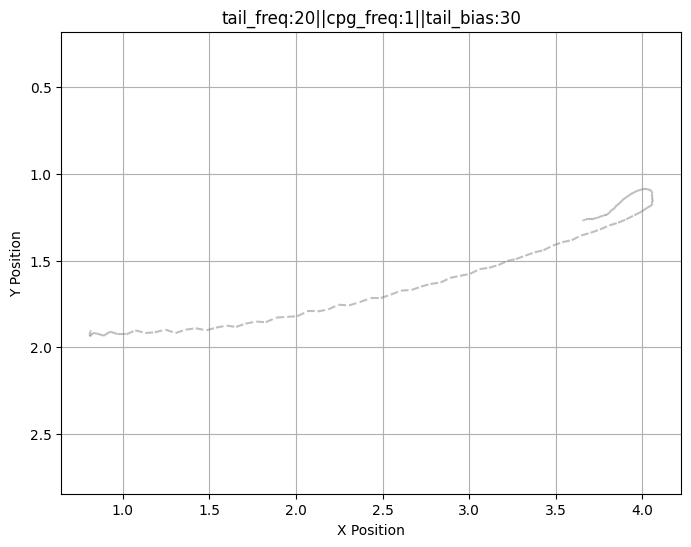

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


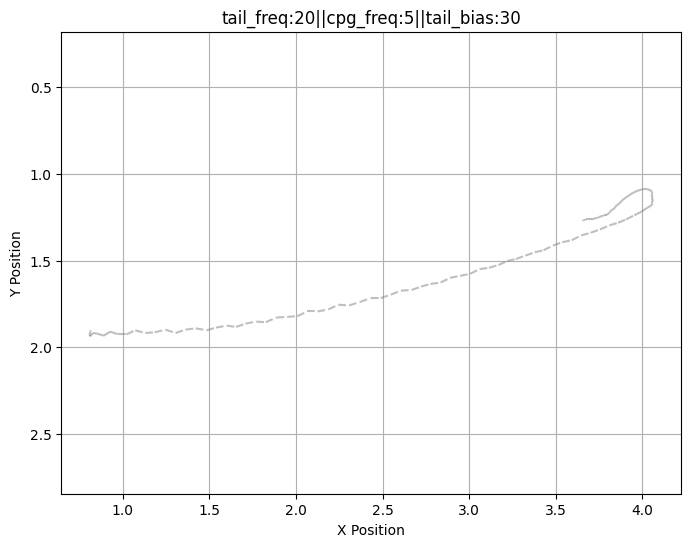

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


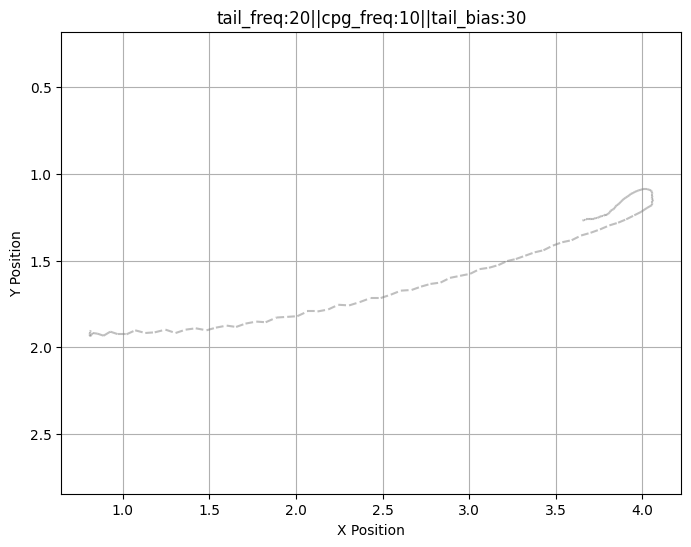

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


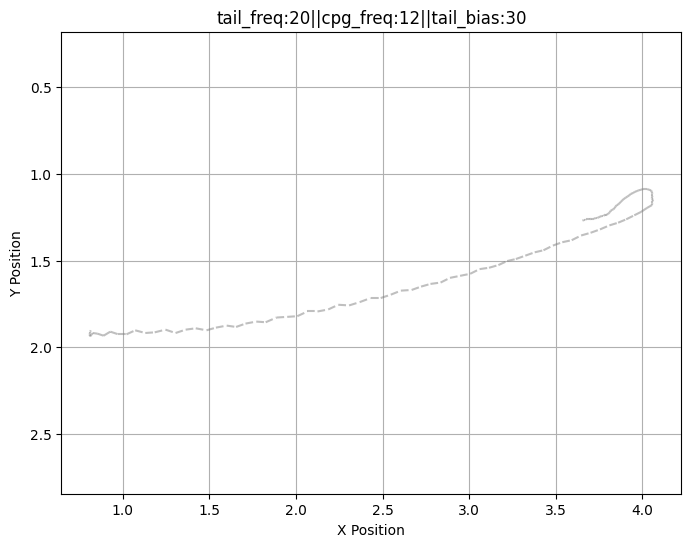

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


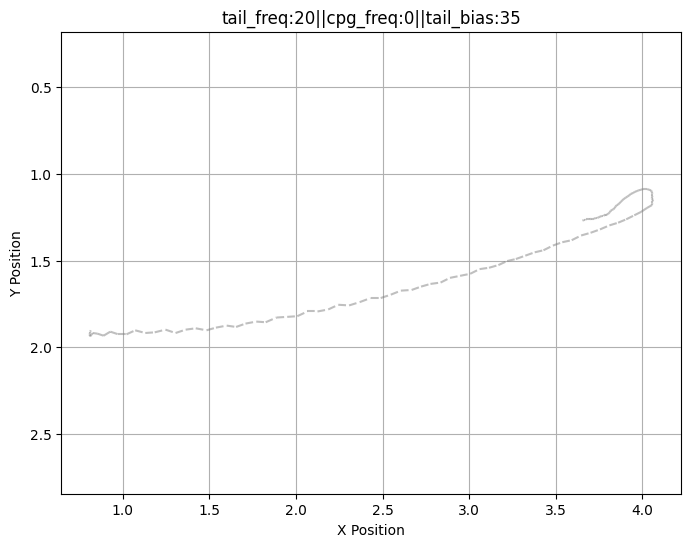

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


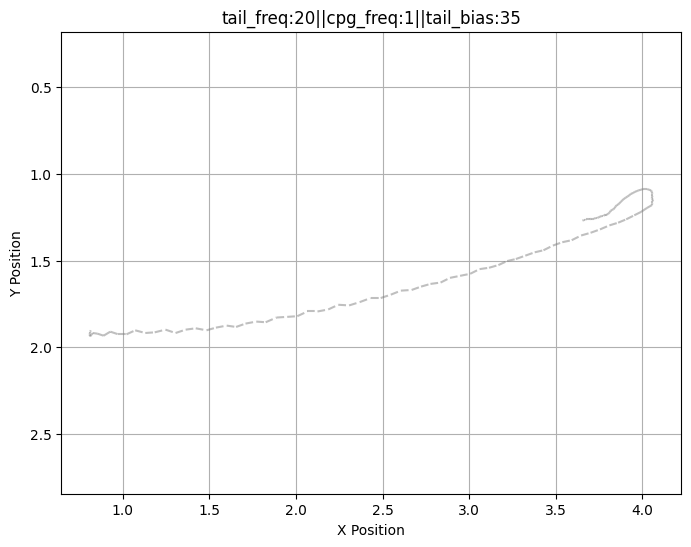

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


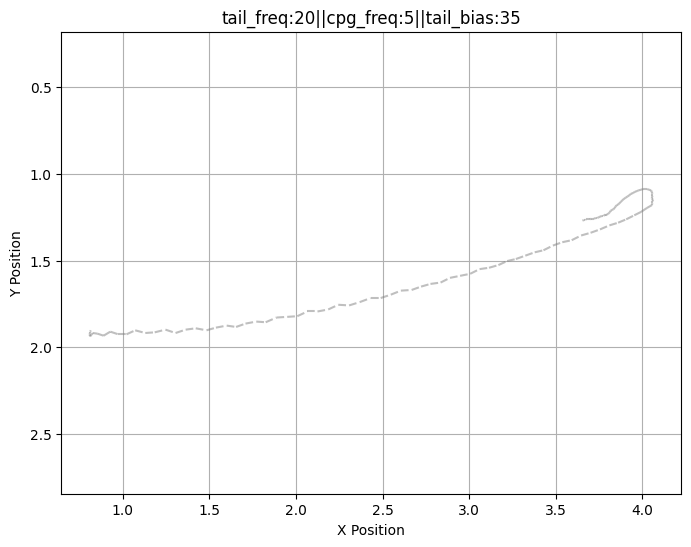

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


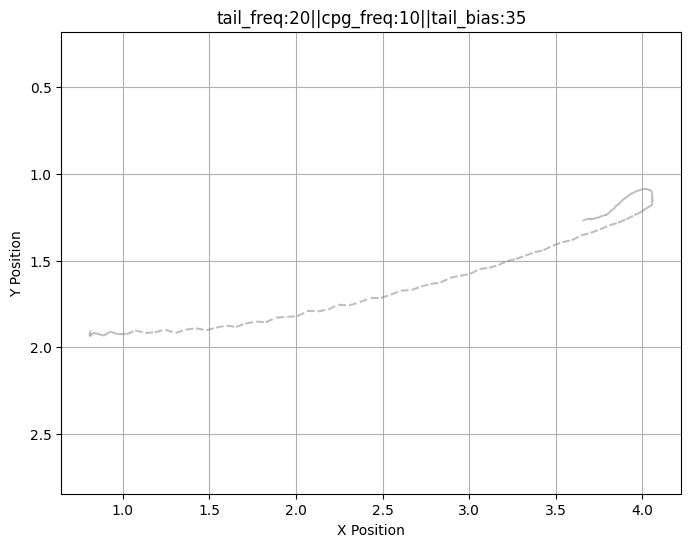

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


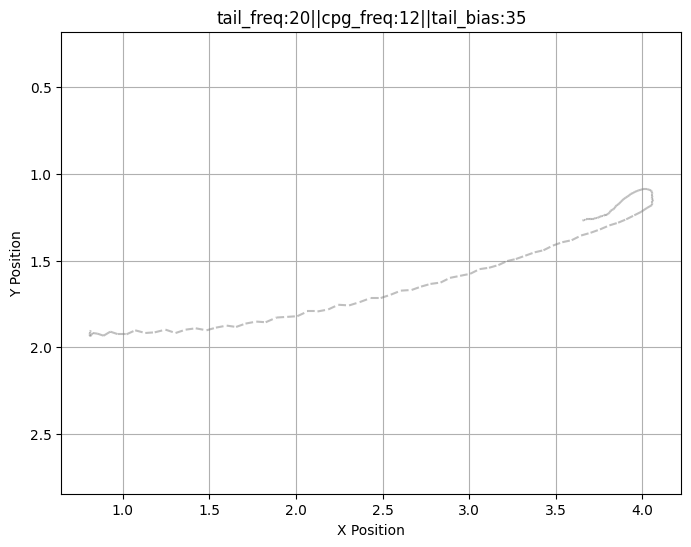

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


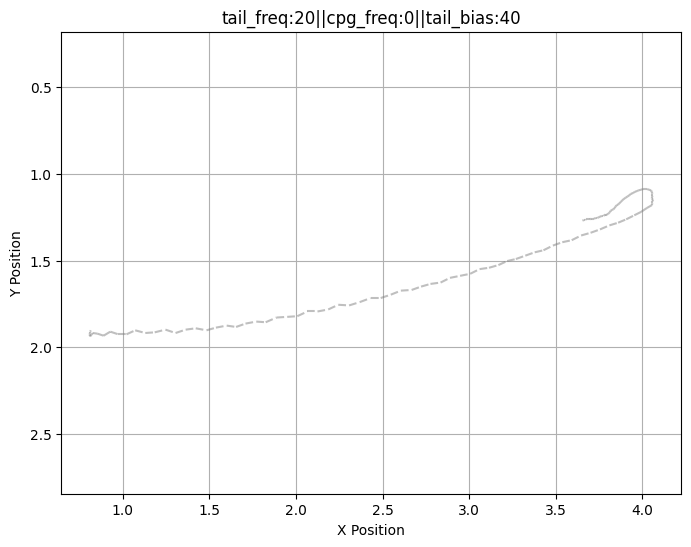

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


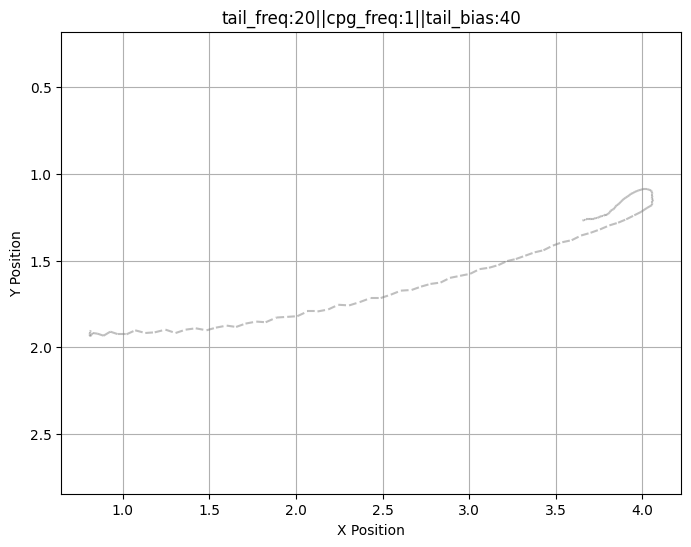

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


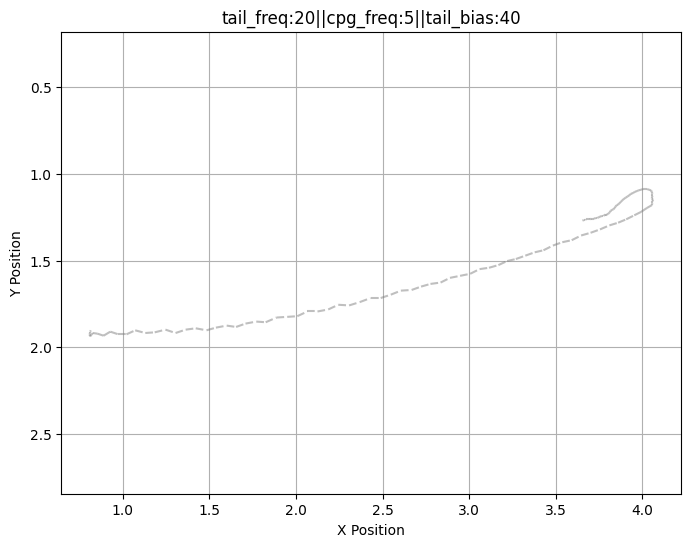

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


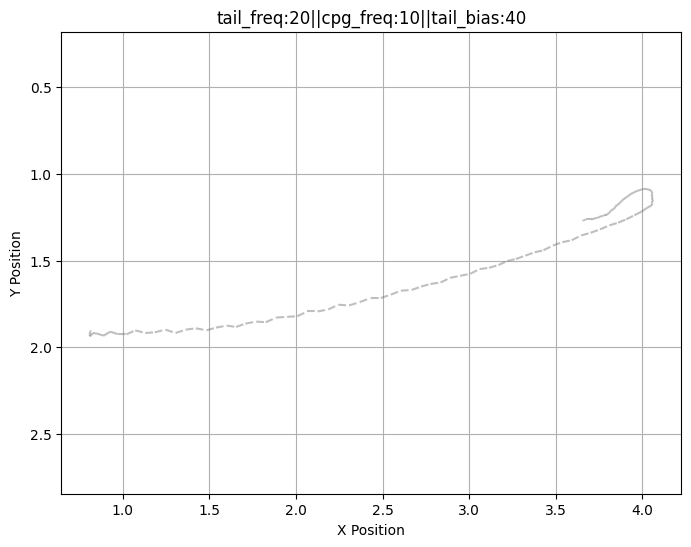

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


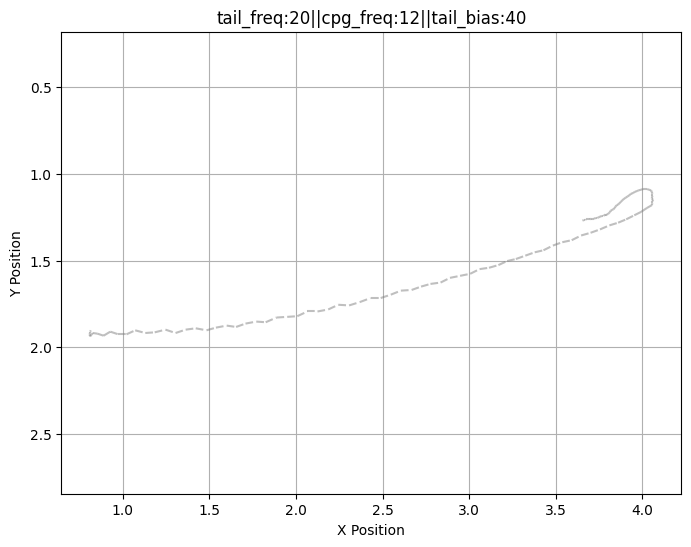

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


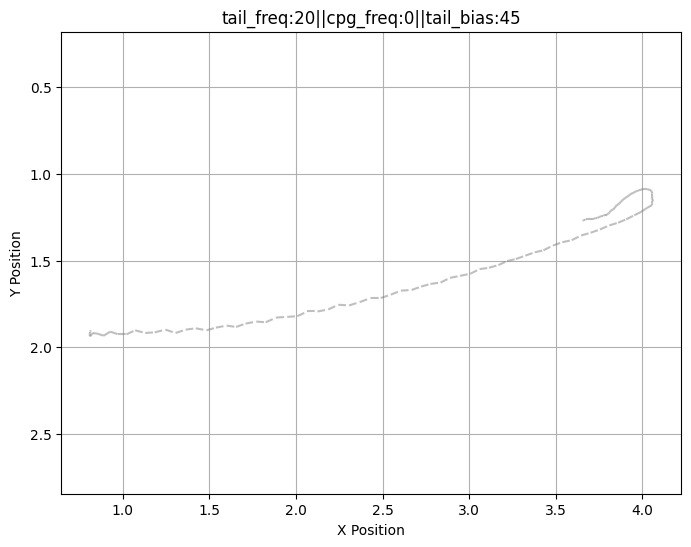

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


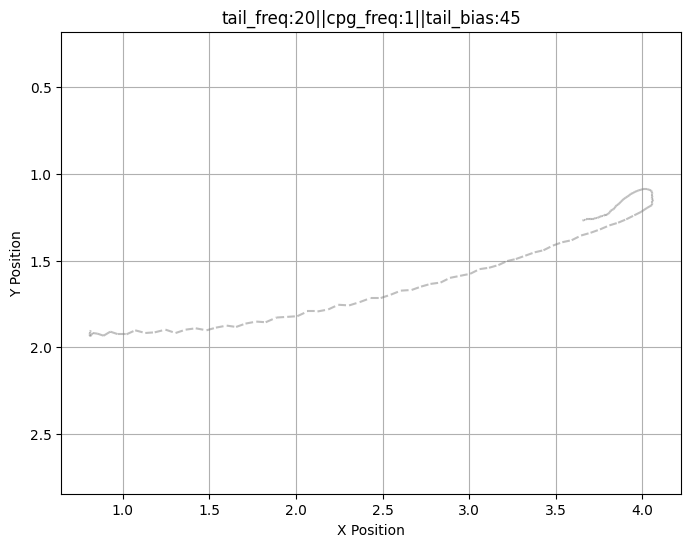

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


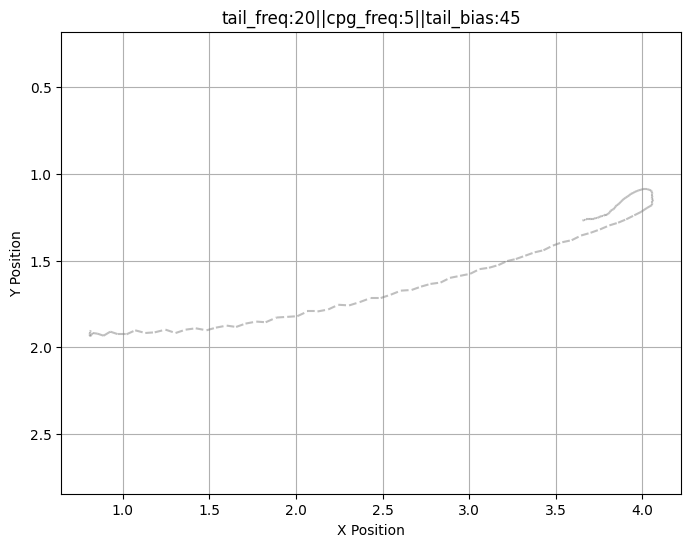

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


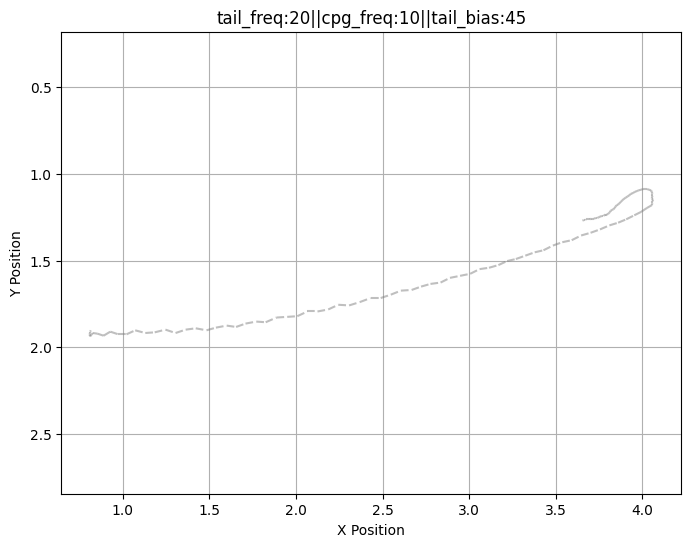

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


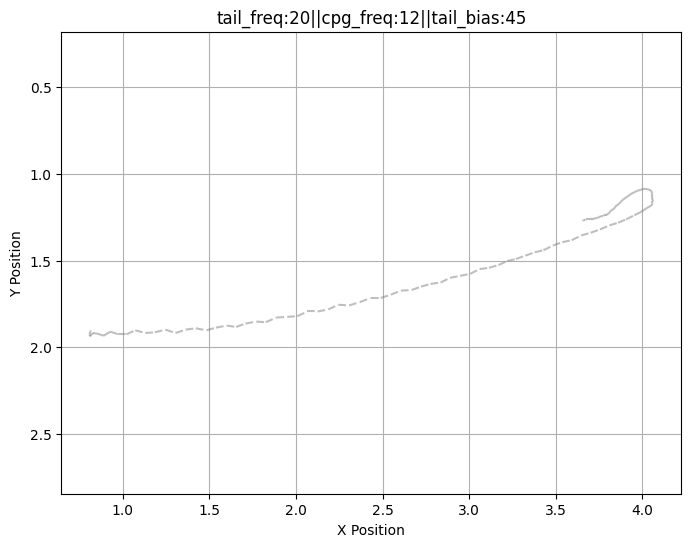

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


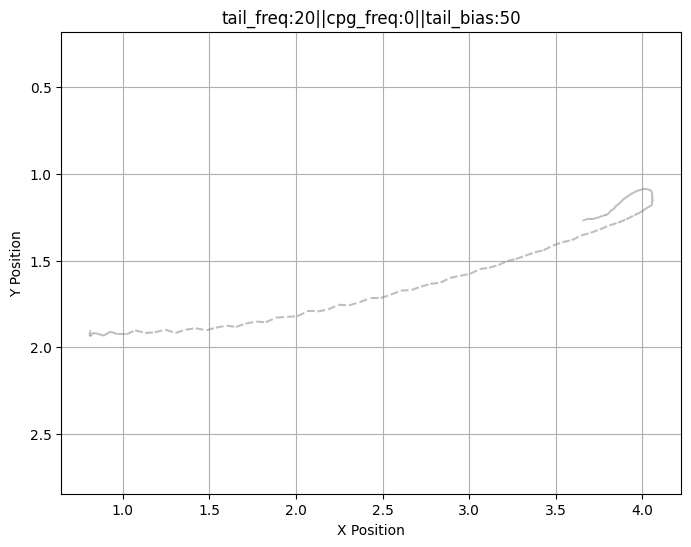

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


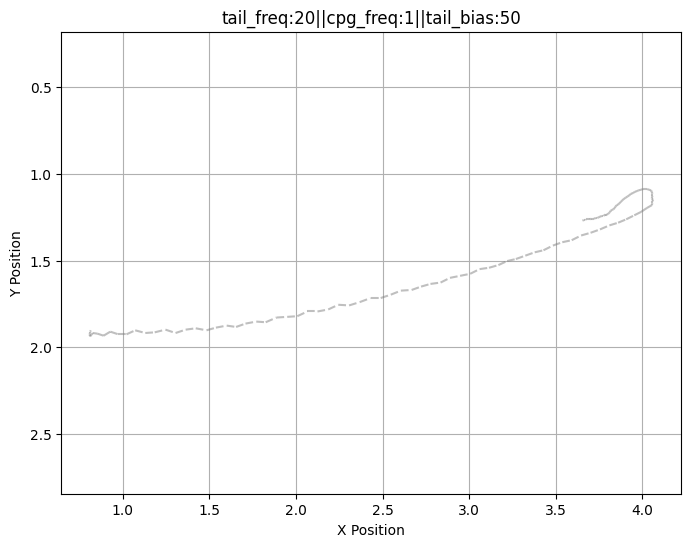

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


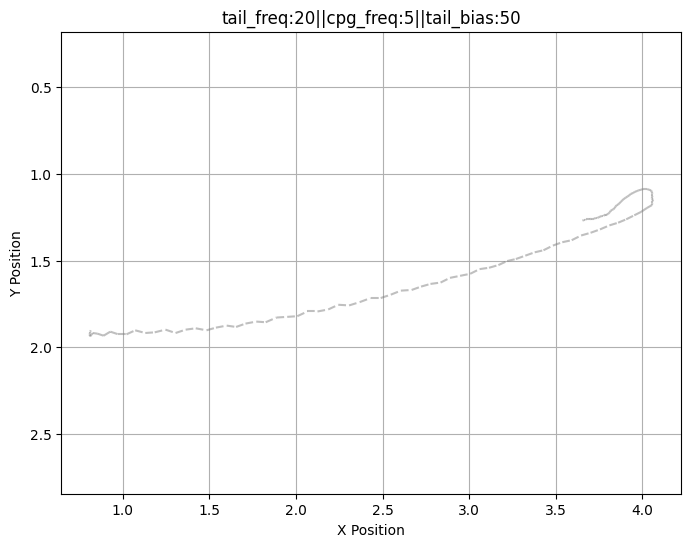

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


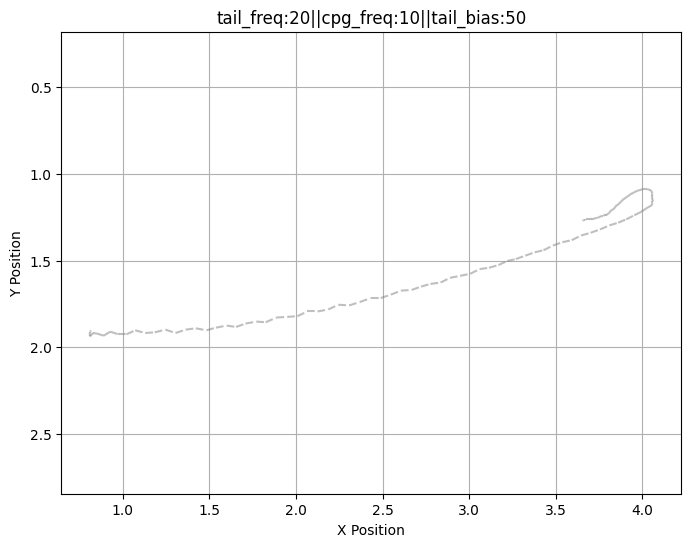

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\dynamic_fitting\\data\\不收鳍最大测速.csv']


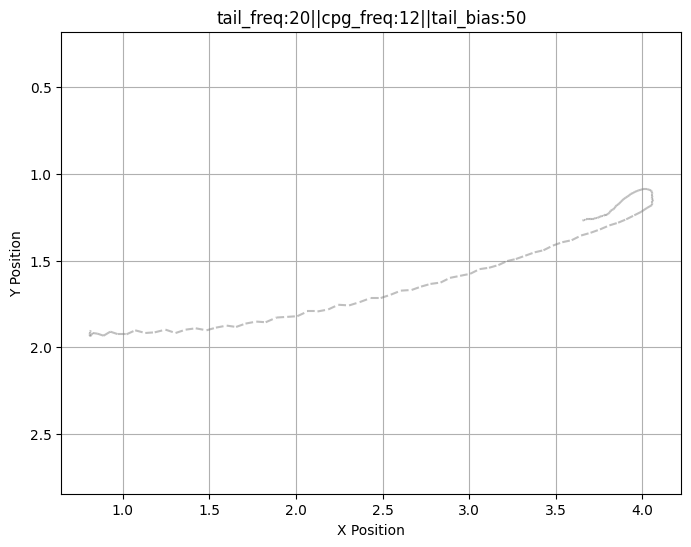

[0.2639306707250853, 0.33915119835809737, 0.4098153417531267, 0.46712097921172774, 0.48358547567614674, 0.49266902161013126, 0.49303434726493234, 0.491344366575866, 0.4901869788711432, 0.48868361586736325, 0.4913418109243006, 0.48673081170672533, 0.47635246667959447, 0.4509853913204619, 0.41413406239240624, 0.38323787264842285, 0.3536367238510468, 0.3244145967459958, 0.29886321334144383, 0.27193210058748785, 0.24608802437373356, 0.22424911415224436, 0.1979201894158038, 0.17257024739888857, 0.14442077657857372, 0.2612833519414401, 0.2534123243915146, 0.0759451894008594, 0.07344921023475368, 0.07451105428885191, 0.07669284981269273, 0.07576734748682175, 0.07412569436583594, 0.07214832131032949]
avg_stable_velocity_fowards: 0.07313700783808272
avg_stable_curvatures: 5.142303392399836
avg_stable_omegas: 0.268377663920037
avg_stable_angles: 0.0


In [6]:
folder_path = "D:\work\科研项目\snippet\BacksteppingMethod\multimodule_dynamic\data"#"./data"

# 使用glob获取所有csv文件路径
Tail_freq_list = [0, 5, 10, 15, 20]
Tail_biases_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
CPG_freq_list = [0, 1, 5, 10, 12]

for tail_freq in Tail_freq_list:
	for tail_bias in Tail_biases_list:
		for cpg_freq in CPG_freq_list:
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['tail_x'].diff().abs()>=1) |
						(df['tail_y'].diff().abs()>=1)) ]
				
				# df['head_x'] = df['head_x'] / 515 * 2
				# df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				# path_points_x = np.array(df['head_x'])
				# path_points_y = np.array(df['head_y'])
				# head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (tail_points) # + tail_points)/2
				
				# 绘制机器人的路径和方向（稀疏采样）
				fig, ax = plt.subplots(figsize=(8, 6))

				# 设置稀疏采样间隔
				sample_interval = int(len(timestamps)/100)  

				# 遍历采样后的点
				for i in range(0, len(tail_points), sample_interval):
					# head = head_points[i]
					tail = tail_points[i]
					
					# 计算机器人的朝向向量
					direction = tail  
					pos = tail 
					# 画出机器人的位置（箭头的起点）
					# ax.quiver(tail[0], tail[1], direction[0], direction[1], angles='xy', scale_units='xy', scale=1, color='blue', headwidth=2)
					
					# 画出路径
					if i > 0:
						prev_pos = robot_points[i - sample_interval]
						ax.plot([prev_pos[0], pos[0]], [prev_pos[1], pos[1]], color='gray', linestyle='--', alpha=0.5)

				# # 设置图形参数
				ax.set_aspect('equal', 'box')
				ax.set_xlabel('X Position')
				ax.set_ylabel('Y Position')
				# 设置y轴的方向反转
				plt.gca().invert_yaxis()
				plt.axis('equal')
				plt.grid(True)
				plt.title("tail_freq:"+ str(tail_freq)+"||cpg_freq:" +  str(cpg_freq)+ "||tail_bias:"+str(tail_bias))
				plt.show()

				# 调用函数并打印结果
				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(tail_points, timestamps)
				# 输出结果
				print(velocity_fowards)
				print("avg_stable_velocity_fowards:", avg_stable_velocity_fowards)
				print("avg_stable_curvatures:", avg_stable_curvatures)
				print("avg_stable_omegas:", avg_stable_omegas)
				print("avg_stable_angles:", avg_stable_angles)

Cd_0x = 0.1445
Cd_1x = 0.1309
Cd_1y = 0.4098
Cd_2x = 0.1070
Cd_2y = 0.2273


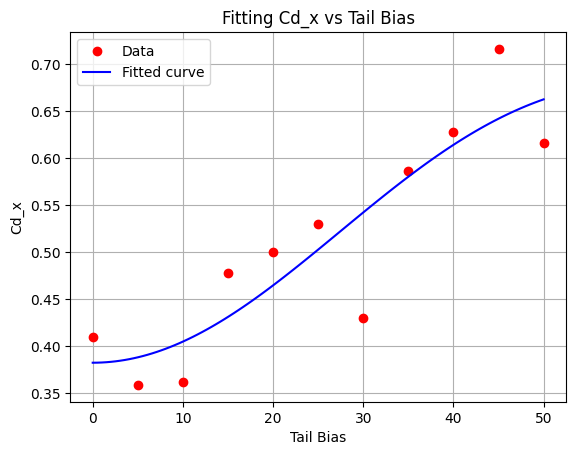

In [35]:

#  拟合系数 Cd_0x, Cd_1_x, Cd_1,y, Cd_2x, Cd_2y
# 使用glob获取所有csv文件路径
Tail_freq_list = [0]
Tail_biases_list = [0, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]
CPG_freq_list = [10]

Force_pec = [3.8]
Cd_xs = np.zeros(len(Tail_biases_list))
u_xs = np.zeros(len(Tail_biases_list))
for tail_freq in Tail_freq_list:
	for  tail_bias_id,tail_bias in enumerate(Tail_biases_list):
		for  cpg_freq_id, cpg_freq in enumerate(CPG_freq_list):
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				# print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['tail_x'].diff().abs()>=1) |
						(df['tail_y'].diff().abs()>=1)) ]
				
				# df['head_x'] = df['head_x'] / 515 * 2
				# df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				# path_points_x = np.array(df['head_x'])
				# path_points_y = np.array(df['head_y'])
				# head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (tail_points) # + tail_points)/2

				# 调用函数并打印结果
				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(tail_points, timestamps)

				Force = Force_pec[cpg_freq_id]
				Cd_xs[tail_bias_id] = Force / 500 / avg_stable_velocity_fowards**2
				u_xs[tail_bias_id] = avg_stable_velocity_fowards


# 拟合函数
def Cd_x_model(tail_bias, Cd_0x, Cd_1x, Cd_1y, Cd_2x, Cd_2y):
	return Cd_0x + Cd_1x * np.cos(np.radians(tail_bias))**2 + Cd_1y * np.sin(np.radians(tail_bias))**2 + \
		   Cd_2x * np.cos(2 * np.radians(tail_bias))**2+ Cd_2y * np.sin(2 * np.radians(tail_bias))**2

# 设置参数的上下限，确保参数为正值
lower_bounds = [0, 0, 0, 0, 0]  # 所有参数的下限为0，避免负值
upper_bounds = [np.inf, np.inf, np.inf, np.inf, np.inf]  # 上限为无穷大
# 使用curve_fit拟合
initial_guess = [1, 1,1, 1, 1]
params, covariance = curve_fit(Cd_x_model, Tail_biases_list, Cd_xs,  p0=initial_guess, bounds=(lower_bounds, upper_bounds), maxfev=100000)

# 提取拟合得到的参数
Cd_0x, Cd_1x, Cd_1y, Cd_2x, Cd_2y = params
print(f"Cd_0x = {Cd_0x:.4f}")
print(f"Cd_1x = {Cd_1x:.4f}")
print(f"Cd_1y = {Cd_1y:.4f}")
print(f"Cd_2x = {Cd_2x:.4f}")
print(f"Cd_2y = {Cd_2y:.4f}")

# 绘制拟合曲线
tail_bias_fine = np.linspace(0, 50, 100)  # 为了绘制光滑的曲线
Cd_x_fitted = Cd_x_model(tail_bias_fine, *params)

plt.plot(Tail_biases_list, Cd_xs, 'ro', label='Data')  # 原始数据
plt.plot(tail_bias_fine, Cd_x_fitted, 'b-', label='Fitted curve')  # 拟合曲线
plt.xlabel('Tail Bias')
plt.ylabel('Cd_x')
plt.legend()
plt.title('Fitting Cd_x vs Tail Bias')
plt.grid(True)
plt.show()

['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/5-0-0.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/5-0-15.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/5-0-20.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/5-0-25.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/10-0-0.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/10-0-15.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/10-0-20.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/10-0-25.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/15-0-0.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/15-0-15.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\multimodule_dynamic\\data/15-0-20.csv']
['D:\\work\\科研项目\\snippet\\BacksteppingMethod\\mul

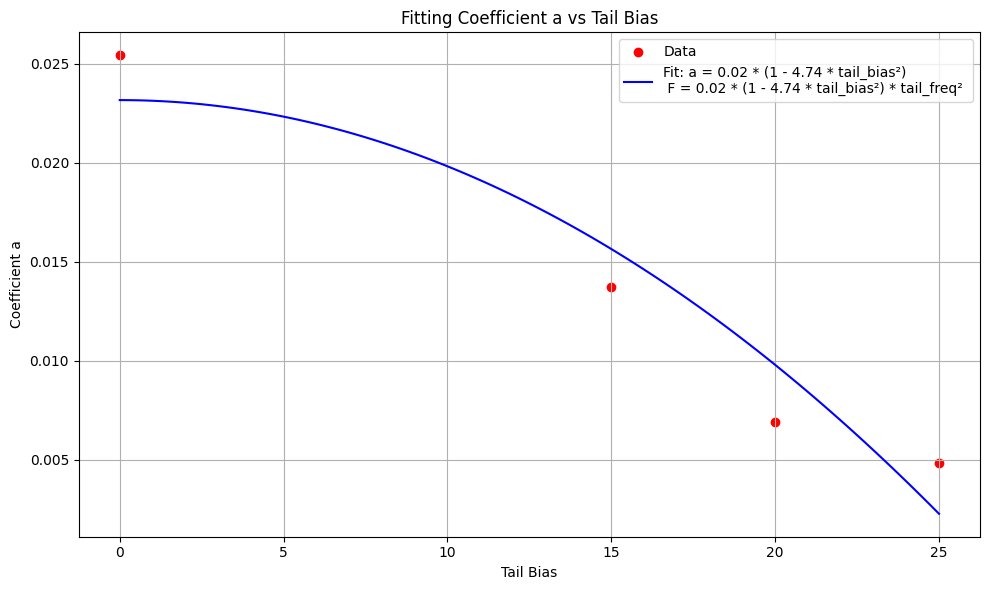

Fitted k1: 0.02317
Fitted k2: 4.73662


In [36]:

# 拟合 F_tail(Tail_freq, Tail_bias)

Tail_freq_list = [5, 10, 15, 20]
Tail_biases_list = [0, 15, 20, 25]
# CPG_freq_list = [0, 1, 5, 10, 12]
# Force_pec = [0, 0, 1.05, 3.8, 4.75]
CPG_freq_list = [ 0,]
Force_pec = [0]
Force_tail = np.zeros([len(Tail_freq_list), len(Tail_biases_list)])

for tail_freq_id, tail_freq in enumerate(Tail_freq_list):
	for  tail_bias_id,tail_bias in enumerate(Tail_biases_list):
		for  cpg_freq_id, cpg_freq in enumerate(CPG_freq_list):
			csv_file = glob.glob(folder_path + "/" + str(tail_freq) + '-' + str(cpg_freq) + '-' + str(tail_bias)+".csv")
			if len(csv_file) != 0:
				print(csv_file)
				df = pd.read_csv(csv_file[0], header=None, names=['timestamp', 'state0','state1','state2', 'head_x', 'head_y', 'tail_x', 'tail_y'])
				df = df[((df['head_x'].diff().abs()>=1) |
						(df['head_y'].diff().abs()>=1)) ]
				
				df['head_x'] = df['head_x'] / 515 * 2
				df['head_y'] = df['head_y'] / 515 * 2
				df['tail_x'] = df['tail_x'] / 515 * 2
				df['tail_y'] = df['tail_y'] / 515 * 2

				# 示例路径点数据（二维点集，包含噪点）
				path_points_x = np.array(df['tail_x'])
				path_points_y = np.array(df['tail_y'])
				tail_points = np.column_stack((path_points_x, path_points_y))
				path_points_x = np.array(df['head_x'])
				path_points_y = np.array(df['head_y'])
				head_points = np.column_stack((path_points_x, path_points_y))
				timestamps = np.array(df['timestamp'])
				robot_points = (head_points) # + tail_points)/2

				avg_stable_velocity_fowards, avg_stable_curvatures, avg_stable_omegas, avg_stable_angles, stable_velocity_fowards, stable_curvatures, stable_omegas, stable_angles, velocity_fowards = calculate_curvature_and_angles(head_points, timestamps)
				# print(avg_stable_velocity_fowards)
				
				Force_tail[tail_freq_id, tail_bias_id] = 500 * avg_stable_velocity_fowards**2 *Cd_xs[tail_bias_id]- Force_pec[cpg_freq_id]

# 绘制图形
plt.figure(figsize=(10, 6))

# 拟合函数
def fit_func(x, a):
	return a * x**2 

# 拟合 a 和 tail_bias 的关系 a = k1 * (1 - k2 * tail_bias^2)
def fit_a_relation(tail_bias, k1, k2):
    return k1 * (1 - k2 * (tail_bias*3.1415/180)**2)

ks = [] # k =  amp*2 * (a - b * bias^2)
# 绘制每个tail_bias的曲线，并拟合
for tail_bias_id, tail_bias in enumerate(Tail_biases_list):
	plt.plot(Tail_freq_list, Force_tail[:, tail_bias_id], 'o-', label=f"Tail Bias {tail_bias}")

	# 拟合数据
	params, _ = curve_fit(fit_func, Tail_freq_list, Force_tail[:, tail_bias_id])
	fitted_y = fit_func(np.array(Tail_freq_list), *params)

	# 绘制拟合曲线
	plt.plot(Tail_freq_list, fitted_y, '--', label=f"Fit - Tail Bias {tail_bias}")

	# 获取拟合参数
	a = params[0]
	equation = f"F = {a:.5f} * Tail_freq²"  # 显示拟合公式
	ks.append(a)

	# 在图形的最后一个点附近标注拟合公式
	plt.text(Tail_freq_list[-1], fitted_y[-1], equation, fontsize=10, verticalalignment='bottom', horizontalalignment='left')

# 图形参数设置
plt.xlabel("Tail Frequency (Tail_freq)")
plt.ylabel("Force Tail (N)")
plt.title("Force Tail vs Tail Frequency for Different Tail Bias")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 使用 curve_fit 对 a_vals 和 tail_bias_vals 进行拟合，得到 k1 和 k2
params_2, _ = curve_fit(fit_a_relation, Tail_biases_list, ks)
# 绘制拟合曲线
plt.figure(figsize=(10, 6))

# 绘制 a 与 tail_bias 的散点图
plt.scatter(Tail_biases_list, ks, label="Data", color='red')

# 绘制拟合曲线
tail_bias_range = np.linspace(min(Tail_biases_list), max(Tail_biases_list), 100)
fitted_ks = fit_a_relation(tail_bias_range, *params_2)
plt.plot(tail_bias_range, fitted_ks, label=f"Fit: a = {params_2[0]:.2f} * (1 - {params_2[1]:.2f} * tail_bias²) \n F = {params_2[0]:.2f} * (1 - {params_2[1]:.2f} * tail_bias²) * tail_freq² ", color='blue')

# 图形参数设置
plt.xlabel("Tail Bias")
plt.ylabel("Coefficient a")
plt.title("Fitting Coefficient a vs Tail Bias")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# 输出拟合结果
k1, k2 = params_2
print(f"Fitted k1: {k1:.5f}")
print(f"Fitted k2: {k2:.5f}")

In [48]:
np.sqrt((Force_tail[1,0] + 3.8) / 500 / .42)

0.18041952132490663

In [47]:
Force_tail[1,0]

3.035752771772772